In [1]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def calculate_gaze_vector_image(image_path, model, resize = False, debug = False):

    image_save_prefix = image_path.split('/')[-1].split('.')[0]

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if resize:
        image = cv2.resize(image, (128, 128))
        image = image / 255.0

    int_image = np.expand_dims(image, axis=0)  # Add batch dimension: (1, height, width)
    input_image = np.expand_dims(int_image, axis=-1)  # Add channel dimension: (1, height, width, 1)

    # Predict mask
    predicted_mask =  model.predict(input_image)[0, :, :, 0]  # (128, 128)

    start_time = time.time()*1000
    #scalar region
    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(predicted_mask >= scalar_lower_bound, predicted_mask <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(predicted_mask >= iris_lower_bound, predicted_mask <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    distances = [np.linalg.norm(np.array([center_x, center_y]) - point[0]) for point in largest_iris_contour]
    iris_radius = round(np.mean(distances)) if distances else 0

    print(f"Iris radius: {iris_radius}")

    all_points = np.vstack([cnt.reshape(-1, 2) for cnt in scalar_contours])
    leftmost_idx = np.argmin(all_points[:, 0])
    rightmost_idx = np.argmax(all_points[:, 0])
    
    leftmost = tuple(all_points[leftmost_idx])
    rightmost = tuple(all_points[rightmost_idx])

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    distance_left_middle = round(np.linalg.norm(np.array(leftmost) - np.array(middle_point)))

    if debug:
    
        norm_predicted_mask = (predicted_mask - predicted_mask.min()) / (predicted_mask.max() - predicted_mask.min() + 1e-8)
        # Convert grayscale input image to RGB
        input_image_rgb = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        # Create a color mask for the predicted mask (e.g., green overlay)
        color_mask = np.zeros_like(input_image_rgb)
        color_mask[..., 1] = (norm_predicted_mask * 255).astype(np.uint8)  # Green channel

        # Blend the input image and the color mask
        alpha = 0.3  # Transparency factor
        input_image_rgb = cv2.addWeighted(input_image_rgb, 1 - alpha, color_mask, alpha, 0)

        # Draw circles at leftmost and rightmost points
        cv2.circle(input_image_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
        cv2.circle(input_image_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
        cv2.circle(input_image_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Yellow circle
        cv2.circle(input_image_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
        cv2.line(input_image_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
        cv2.arrowedLine(input_image_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.5)
        cv2.circle(input_image_rgb, middle_point, radius=distance_left_middle, color=(0, 255, 0), thickness=1)  # Green circle
        cv2.circle(input_image_rgb, iris_center, radius=iris_radius, color=(225, 0, 0), thickness=1) 

        predicted_mask_rgb = input_image_rgb

        # Display the mask with circles
        plt.figure(figsize=(8, 8))
        plt.imshow(predicted_mask_rgb)
        plt.title('Predicted Mask with Circles')
        plt.axis('off')
        plt.show()

    # # Create the directory if it doesn't exist
    # output_dir = "gaze_vector_prediction"
    # os.makedirs(output_dir, exist_ok=True)

    # # Define the output file path
    # output_file_path = os.path.join(output_dir, image_save_prefix+"_vectors.png")

    # # Save the image
    # cv2.imwrite(output_file_path, cv2.cvtColor(predicted_mask_rgb, cv2.COLOR_RGB2BGR))
    # print(f"Image saved to {output_file_path}")
    iris_center_vector = np.array(iris_center)
    middle_point_vector = np.array(middle_point)
    end_time = time.time()*1000
    print(f"Time taken: {end_time - start_time} ms")
    return iris_center_vector , middle_point_vector

2025-05-17 20:34:28.359551: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 20:34:28.549016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747494268.596603  141667 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747494268.611834  141667 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747494268.762944  141667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def calculate_gaze_vector_from_lable_img(label_path, debug = False):
    label = np.load(label_path)
    label = cv2.resize(label, (128, 128))
    label = label / np.max(label)

    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(label >= scalar_lower_bound, label <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(label >= iris_lower_bound, label <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    # Calculate iris radius as the mean distance from center to all contour points
    distances = [np.linalg.norm(np.array([center_x, center_y]) - point[0]) for point in largest_iris_contour]
    iris_radius = round(np.mean(distances)) if distances else 0
    print(f"Iris radius: {iris_radius}")

    # Initialize leftmost and rightmost points
    leftmost = (128, 128)
    rightmost = (0, 0)

    # Find extreme points from all contours
    for contour in scalar_contours:
        for point in contour:
            x, y = point[0]
            if x < leftmost[0]:
                leftmost = (x, y)
            if x > rightmost[0]:
                rightmost = (x, y)

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    distance_left_middle = round(np.linalg.norm(np.array(leftmost) - np.array(middle_point)))
    print(f"Distance between Leftmost and Middle Point: {distance_left_middle}")
    # Convert predicted mask to RGB to draw colored circles

    if debug:
  
        predicted_mask_rgb = cv2.cvtColor((label * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

        # Draw circles at leftmost and rightmost points
        cv2.circle(predicted_mask_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
        cv2.circle(predicted_mask_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
        cv2.circle(predicted_mask_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Red circle
        cv2.circle(predicted_mask_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
        cv2.line(predicted_mask_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
        cv2.arrowedLine(predicted_mask_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.5)
        cv2.circle(predicted_mask_rgb, middle_point, radius=distance_left_middle, color=(0, 255, 0), thickness=1)  # Green circle
        cv2.circle(predicted_mask_rgb, iris_center, radius=iris_radius, color=(225, 0, 0), thickness=1) 

        plt.figure(figsize=(8, 8))
        plt.imshow(predicted_mask_rgb)
        plt.title('Predicted Mask with Circles')
        plt.axis('off')
        plt.show()

    iris_center_vector = np.array(iris_center)
    middle_point_vector = np.array(middle_point)
    return iris_center_vector, middle_point_vector

In [4]:
def pixel_to_camera_ray(pixel, camera_matrix):
    """
    Convert pixel coordinates to camera ray in 3D space.
    """
    # Inverse the camera matrix
    inv_camera_matrix = np.linalg.inv(camera_matrix)
    
    # Create a homogeneous coordinate for the pixel
    pixel_homogeneous = np.array([pixel[0], pixel[1], 1])
    
    # Calculate the camera ray
    camera_ray = inv_camera_matrix @ pixel_homogeneous
    return camera_ray[:3]  # Return only the x, y, z components


def calculate_gaze_vector(iris_center, middle_point, camera_matrix):
    """
    Calculate the gaze vector in 3D space.
    """
    # Convert pixel coordinates to camera rays
    iris_ray = pixel_to_camera_ray(iris_center, camera_matrix)
    middle_point_ray = pixel_to_camera_ray(middle_point, camera_matrix)

    # Normalize the rays
    iris_ray /= np.linalg.norm(iris_ray)
    middle_point_ray /= np.linalg.norm(middle_point_ray)

    # Calculate the gaze vector
    gaze_vector = middle_point_ray - iris_ray
    gaze_vector /= np.linalg.norm(gaze_vector)  # Normalize the gaze vector

    return gaze_vector


Error processing 0.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(93))


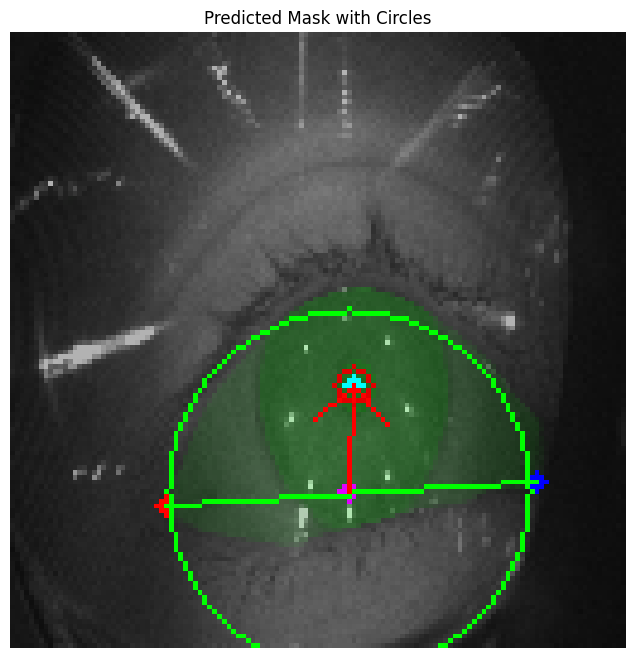

Time taken: 60.17138671875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(87))
Distance between Leftmost and Middle Point: 38
Error processing 1.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(110), np.int32(88))


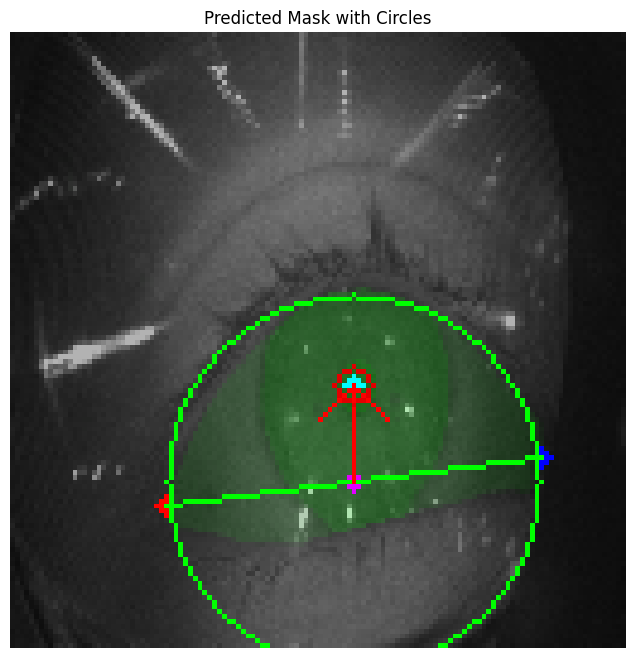

Time taken: 402.385986328125 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(92))
Distance between Leftmost and Middle Point: 38
Error processing 10.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(107), np.int32(97))


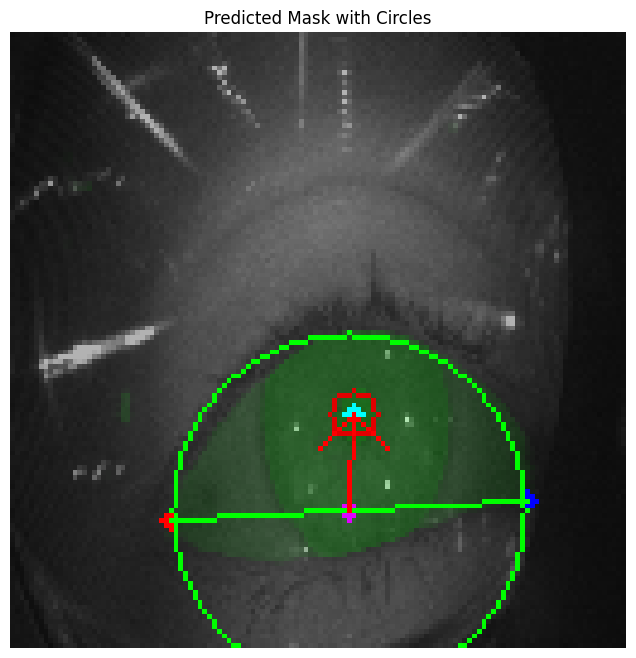

Time taken: 57.01123046875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(94))
Distance between Leftmost and Middle Point: 37
Error processing 100.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(88))


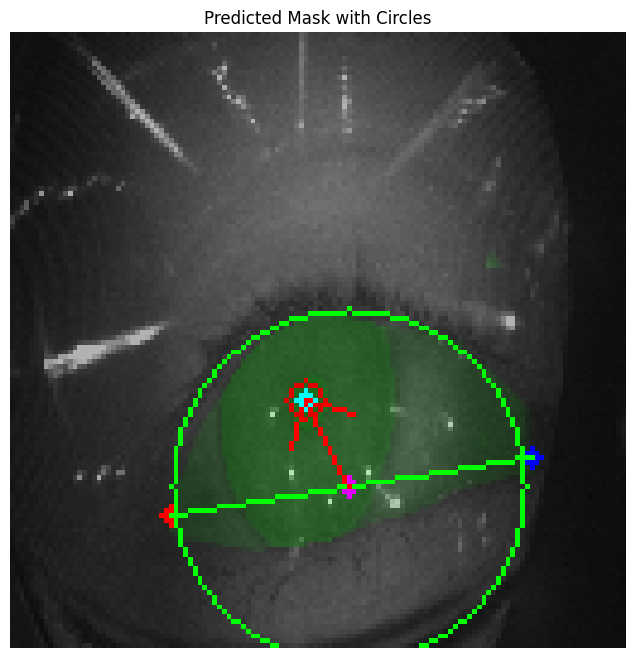

Time taken: 55.59619140625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(88))
Distance between Leftmost and Middle Point: 37
Error processing 101.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(82))


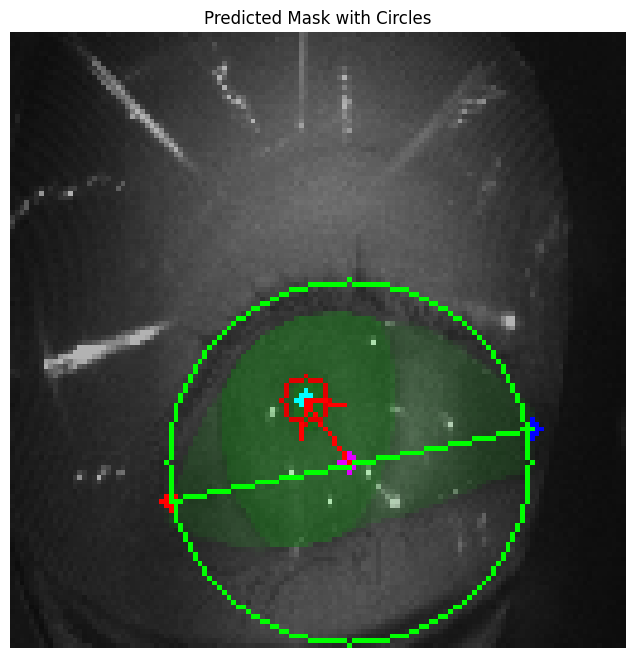

Time taken: 56.555419921875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(87))
Distance between Leftmost and Middle Point: 38
Error processing 102.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(89))


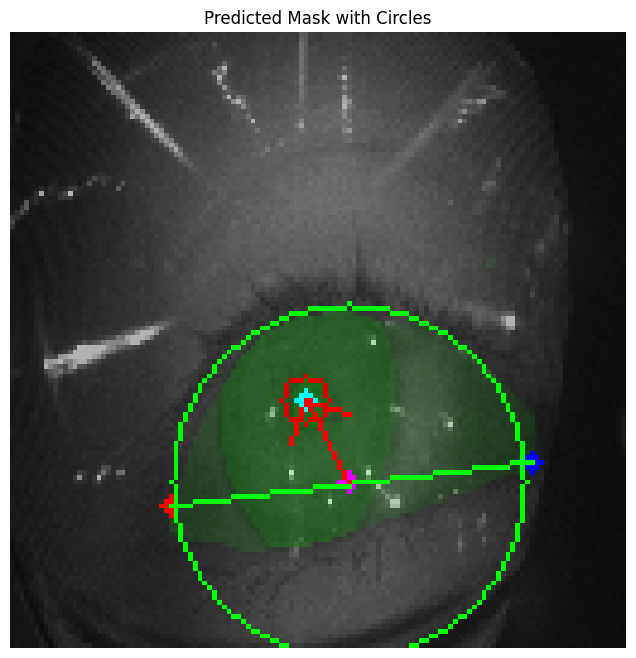

Time taken: 51.1689453125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(85))
Distance between Leftmost and Middle Point: 39
Error processing 103.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(90))


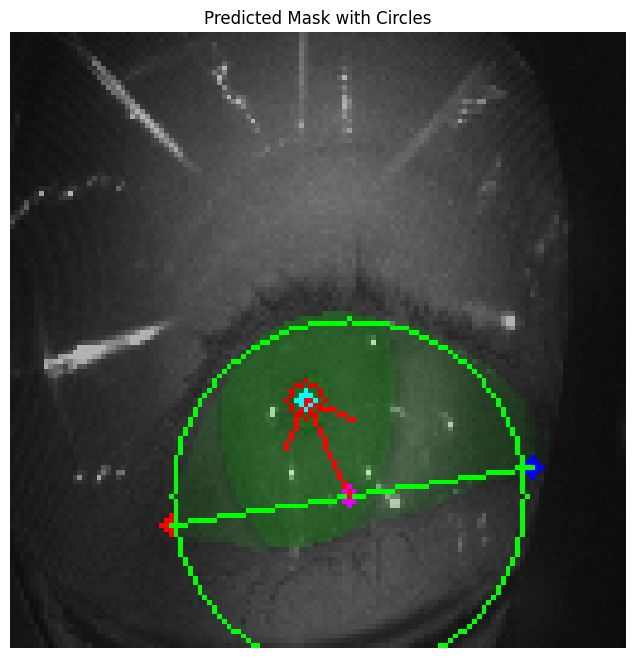

Time taken: 44.2802734375 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(106), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 104.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(90))


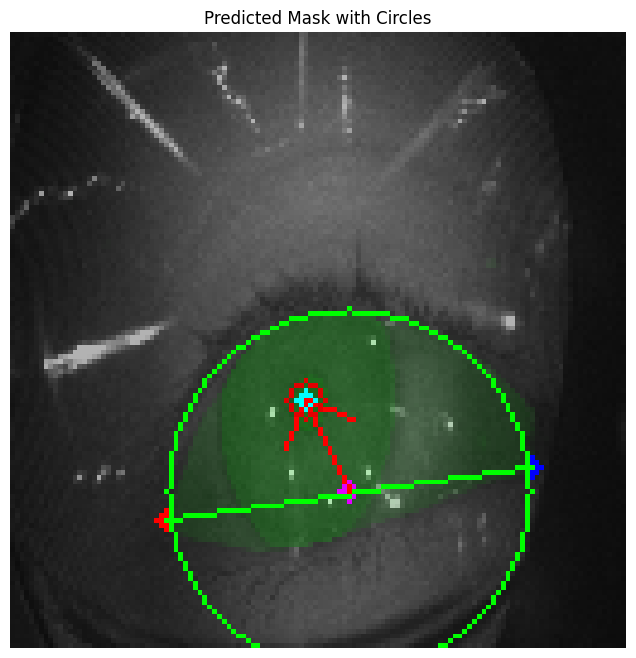

Time taken: 50.77001953125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(109), np.int32(83))
Distance between Leftmost and Middle Point: 39
Error processing 105.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(90))


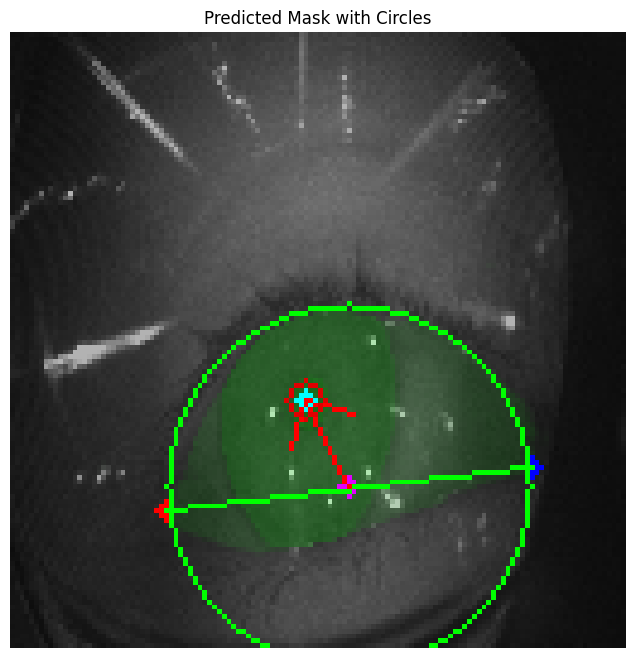

Time taken: 49.189208984375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(82))
Distance between Leftmost and Middle Point: 38
Error processing 106.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(107), np.int32(91))


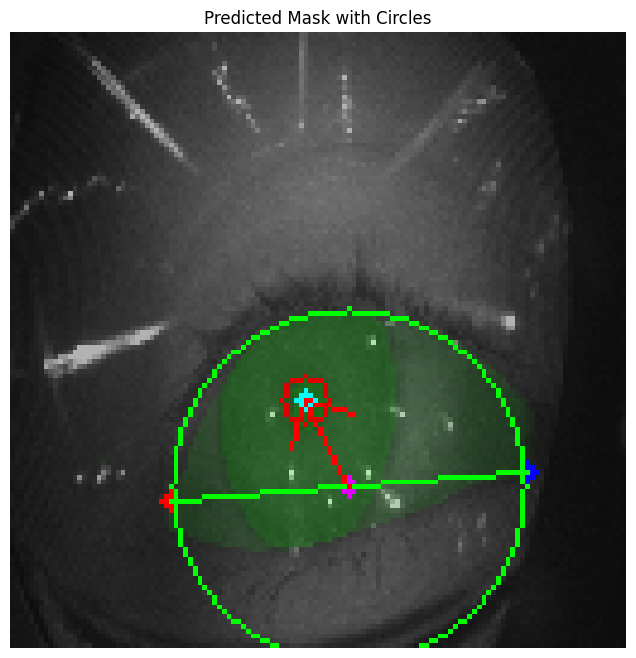

Time taken: 52.287841796875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(107), np.int32(86))
Distance between Leftmost and Middle Point: 38
Error processing 107.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(84))


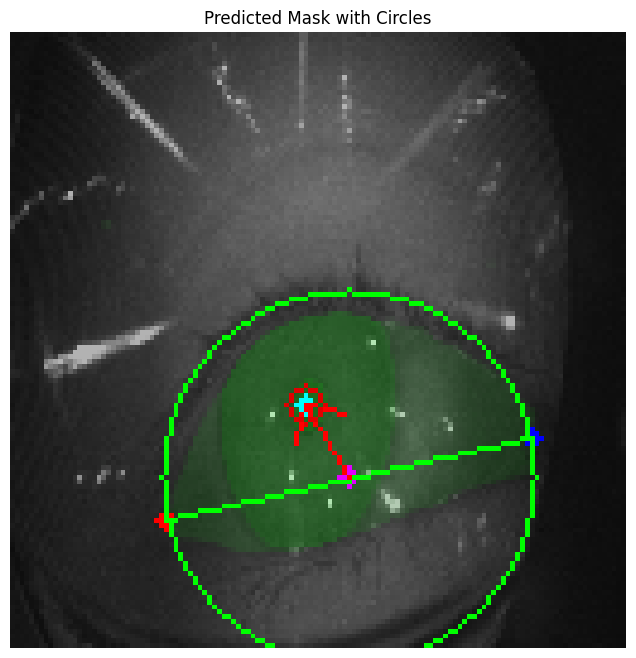

Time taken: 55.00048828125 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(85))
Distance between Leftmost and Middle Point: 39
Error processing 108.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(91))


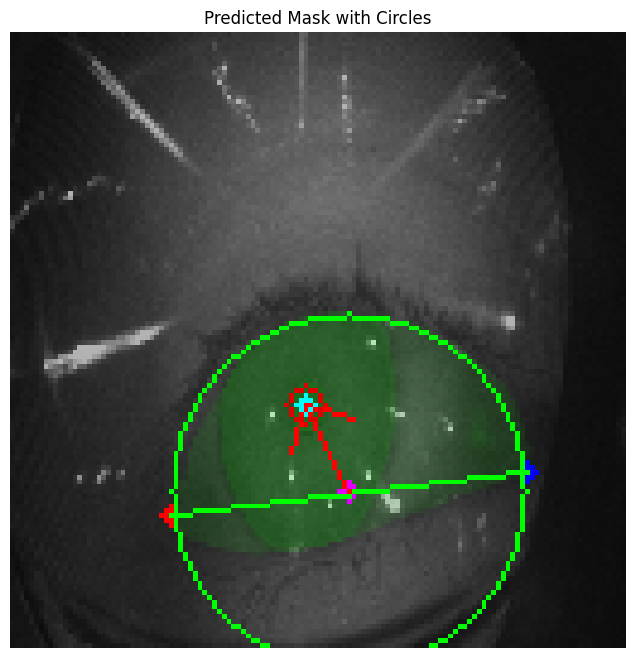

Time taken: 43.623291015625 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(107), np.int32(81))
Distance between Leftmost and Middle Point: 38
Error processing 109.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(82))


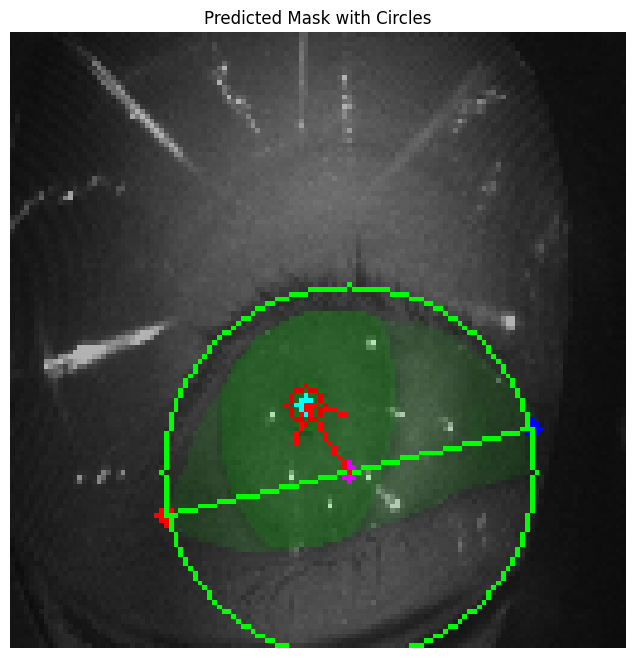

Time taken: 49.279296875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(107), np.int32(83))
Distance between Leftmost and Middle Point: 38
Error processing 11.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(109), np.int32(91))


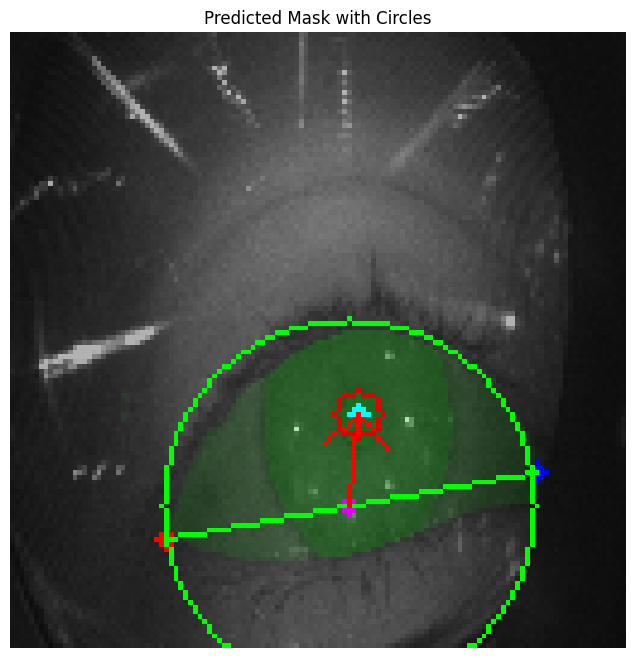

Time taken: 47.4306640625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(90))
Distance between Leftmost and Middle Point: 37
Error processing 110.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(107), np.int32(91))


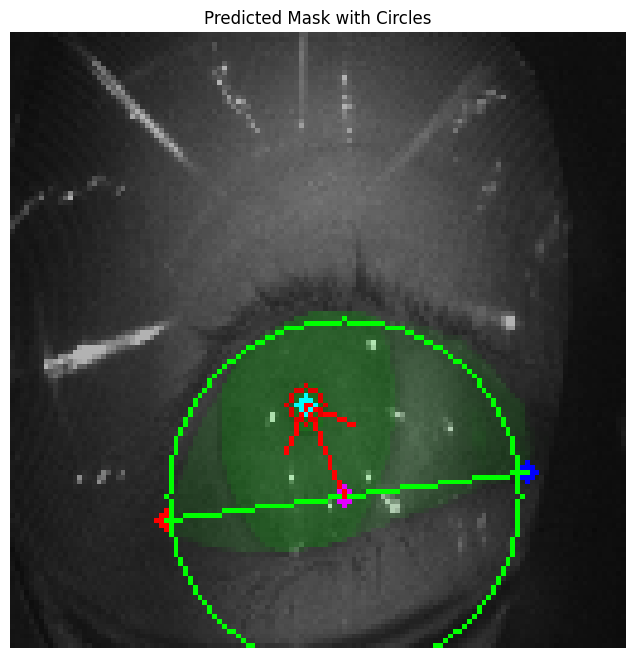

Time taken: 50.710205078125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(86))
Distance between Leftmost and Middle Point: 38
Error processing 111.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(107), np.int32(91))


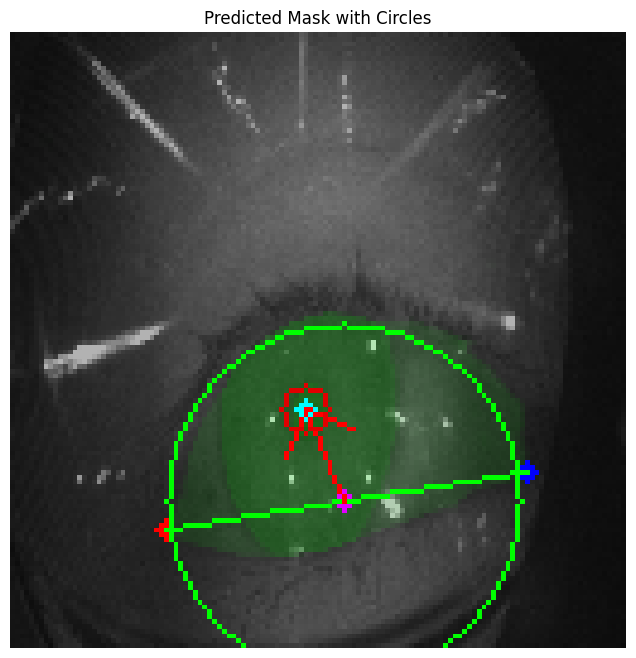

Time taken: 44.83154296875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(86))
Distance between Leftmost and Middle Point: 38
Error processing 112.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(110), np.int32(90))


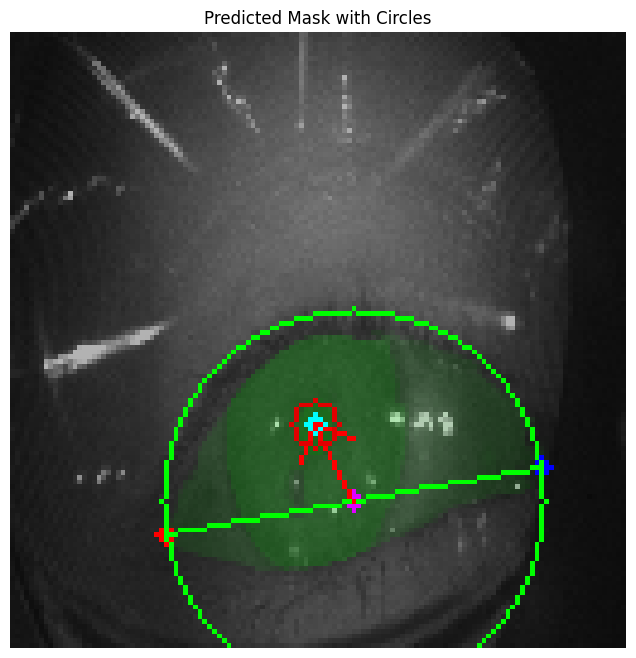

Time taken: 47.87744140625 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(107), np.int32(93))
Distance between Leftmost and Middle Point: 37
Error processing 113.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(107), np.int32(89))


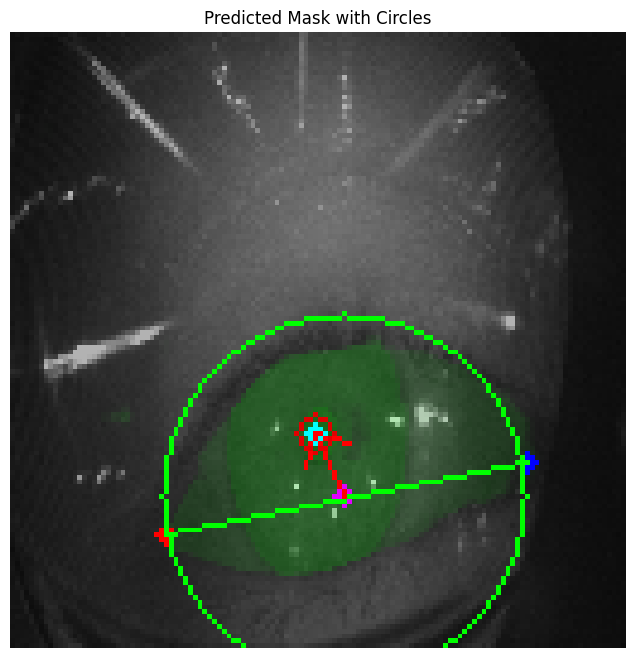

Time taken: 49.20068359375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 114.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(106))
Rightmost Point: (np.int32(106), np.int32(89))


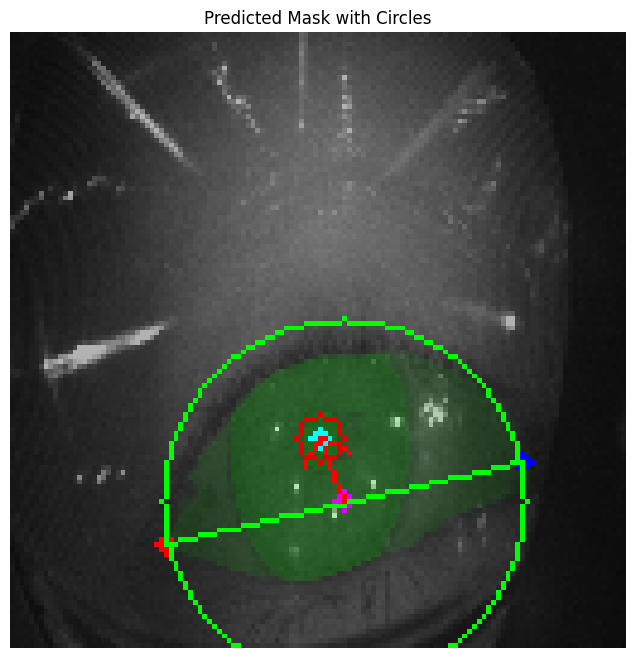

Time taken: 53.208984375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(104), np.int32(93))
Distance between Leftmost and Middle Point: 36
Error processing 115.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(107))
Rightmost Point: (np.int32(107), np.int32(82))


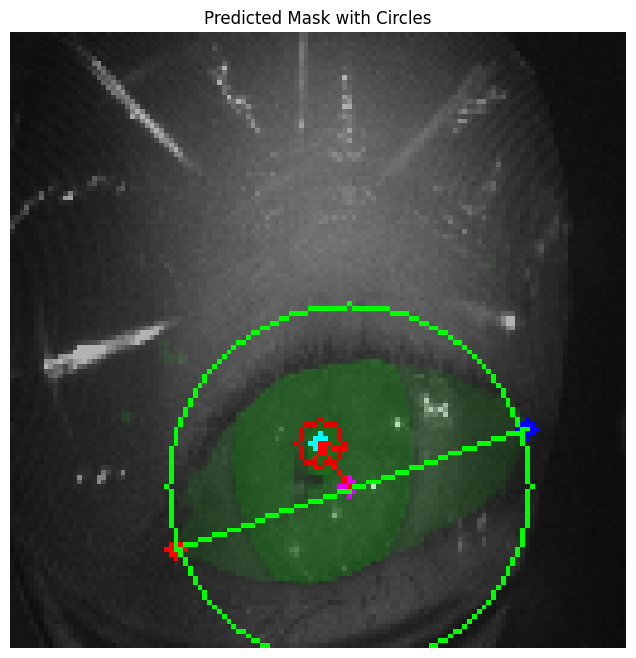

Time taken: 52.228515625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(83))
Distance between Leftmost and Middle Point: 37
Error processing 116.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(107))
Rightmost Point: (np.int32(106), np.int32(96))


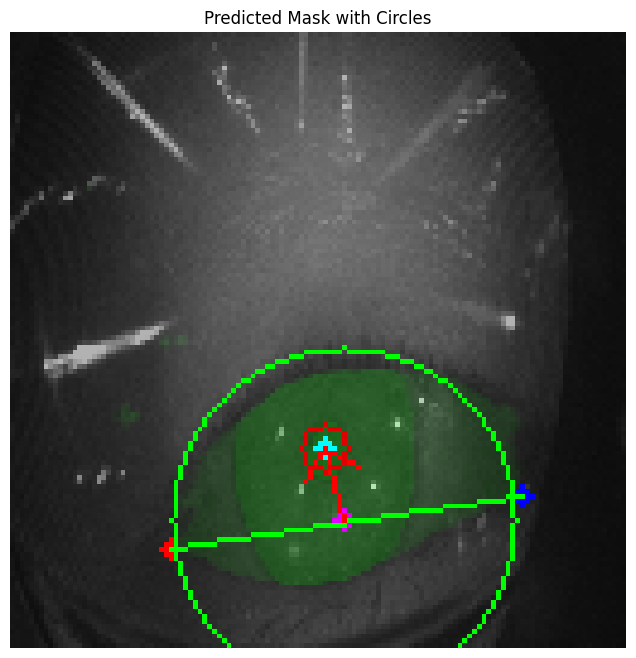

Time taken: 56.3388671875 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(83))
Distance between Leftmost and Middle Point: 37
Error processing 117.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(106))
Rightmost Point: (np.int32(106), np.int32(92))


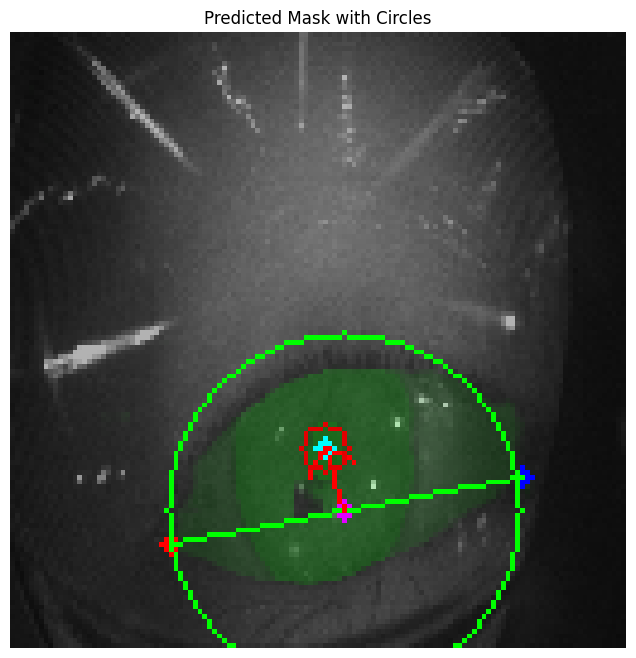

Time taken: 49.2880859375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 118.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(82))


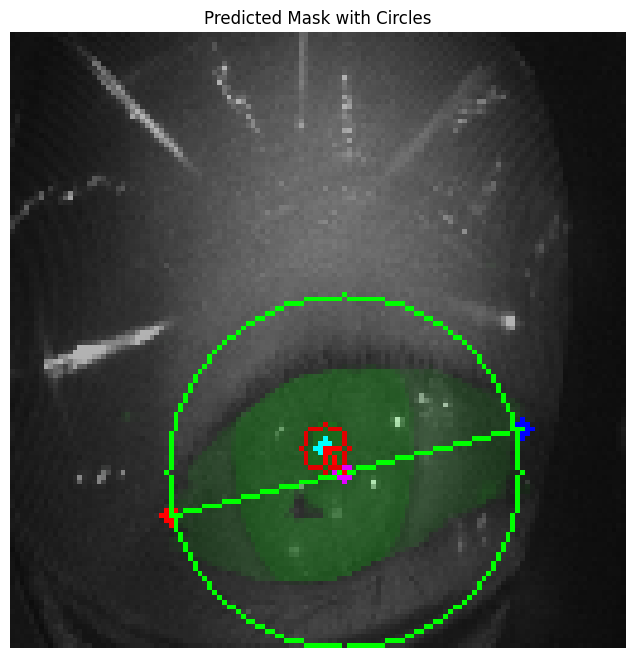

Time taken: 50.59033203125 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(93))
Distance between Leftmost and Middle Point: 36
Error processing 119.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Iris radius: 4
Leftmost Point: (np.int32(34), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(92))


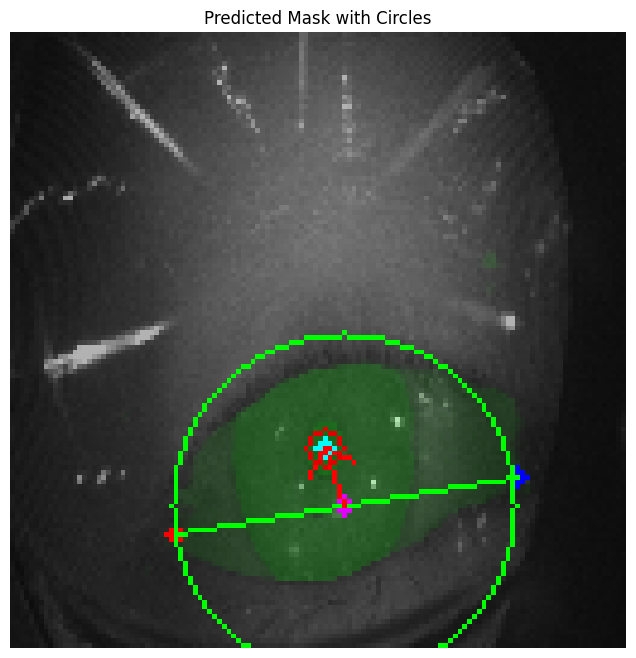

Time taken: 54.471435546875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 12.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(88))


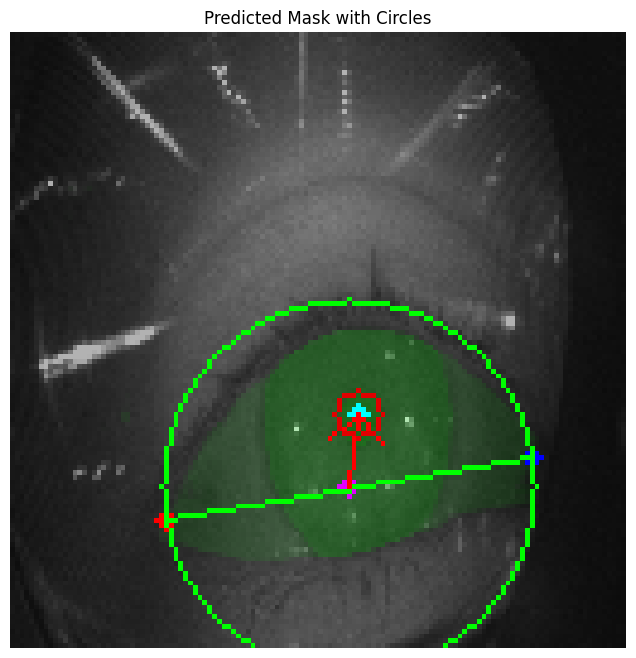

Time taken: 51.84521484375 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(103))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 38
Error processing 120.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(96))
Rightmost Point: (np.int32(106), np.int32(84))


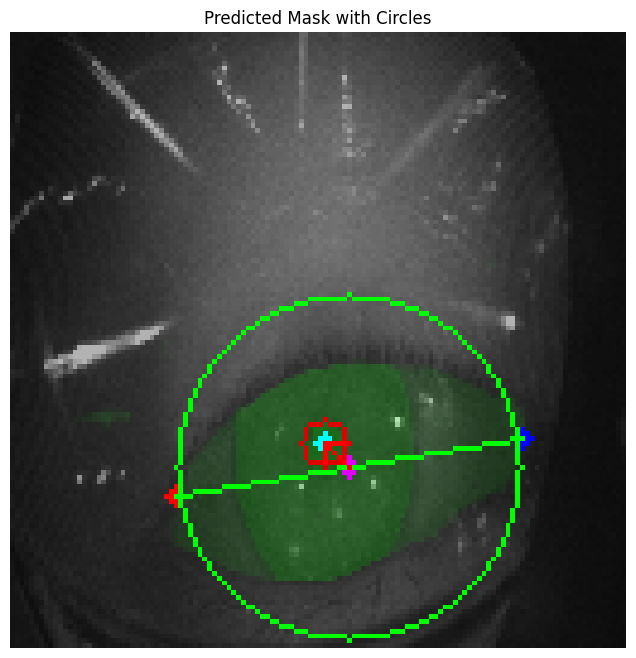

Time taken: 58.744384765625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(82))
Distance between Leftmost and Middle Point: 38
Error processing 121.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(97))
Rightmost Point: (np.int32(106), np.int32(81))


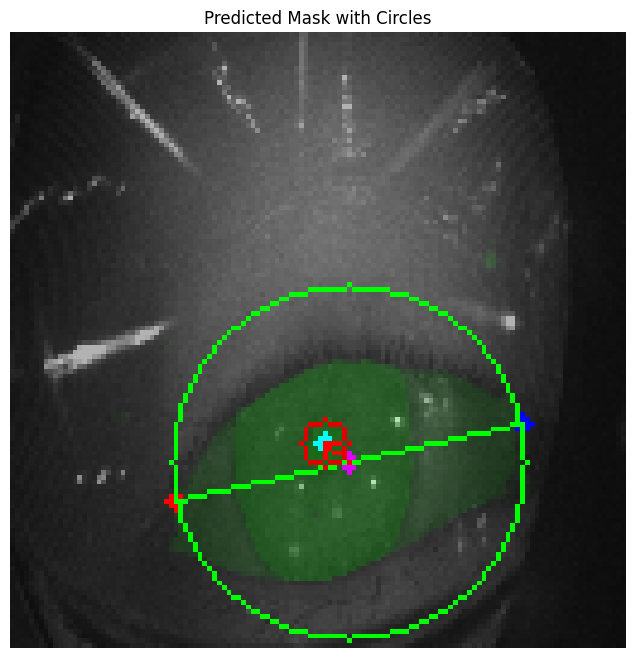

Time taken: 51.104736328125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(83))
Distance between Leftmost and Middle Point: 37
Error processing 122.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(106))
Rightmost Point: (np.int32(106), np.int32(81))


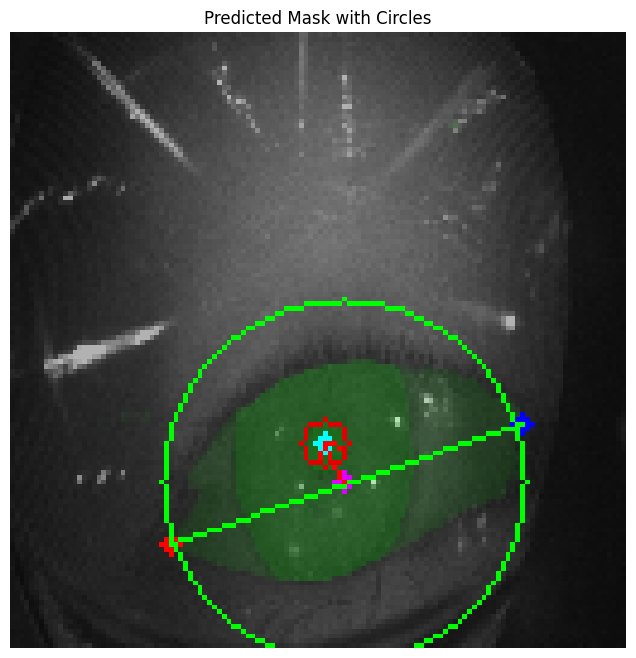

Time taken: 54.1884765625 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 123.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(80))


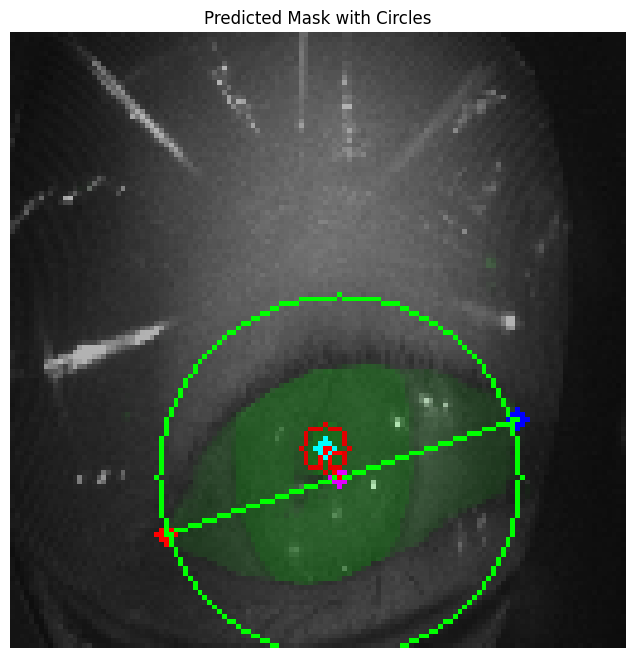

Time taken: 72.0966796875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 124.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(106))
Rightmost Point: (np.int32(106), np.int32(84))


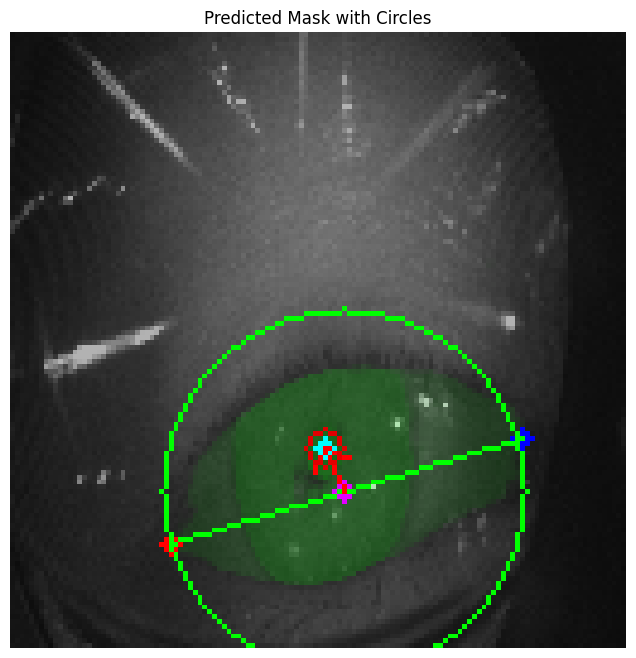

Time taken: 52.50341796875 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(101))
Rightmost Point: (np.int32(105), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 125.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(107), np.int32(88))


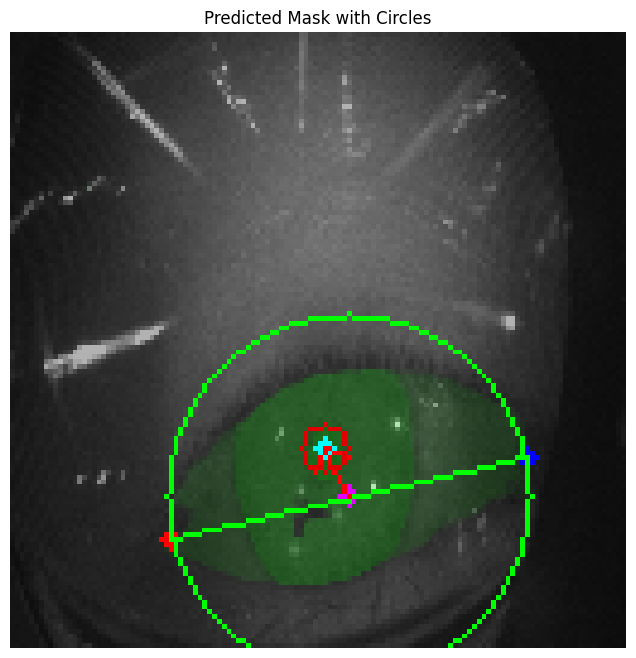

Time taken: 49.9365234375 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(83))
Distance between Leftmost and Middle Point: 37
Error processing 126.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(107), np.int32(95))


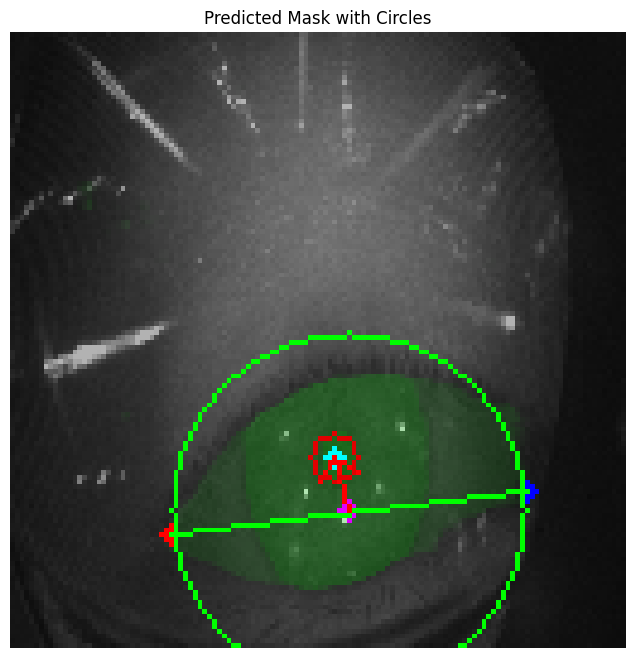

Time taken: 51.5224609375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(104), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 127.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(106))
Rightmost Point: (np.int32(106), np.int32(96))


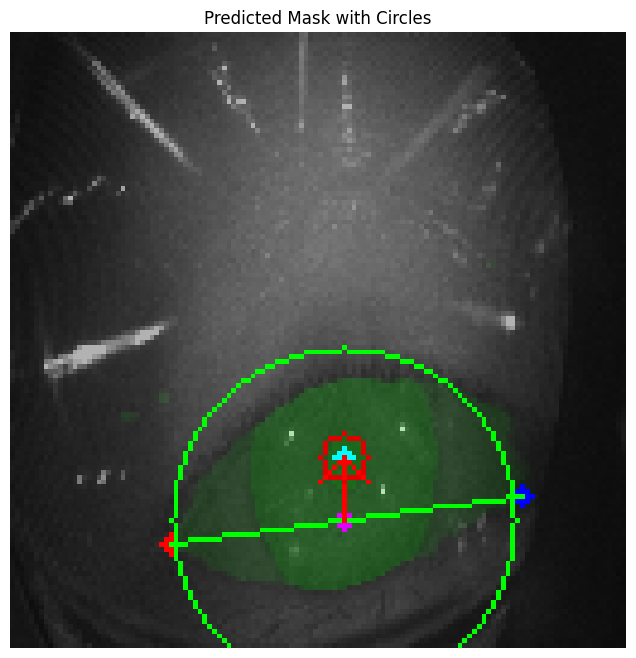

Time taken: 55.942626953125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(104), np.int32(87))
Distance between Leftmost and Middle Point: 36
Error processing 128.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(104))
Rightmost Point: (np.int32(107), np.int32(84))


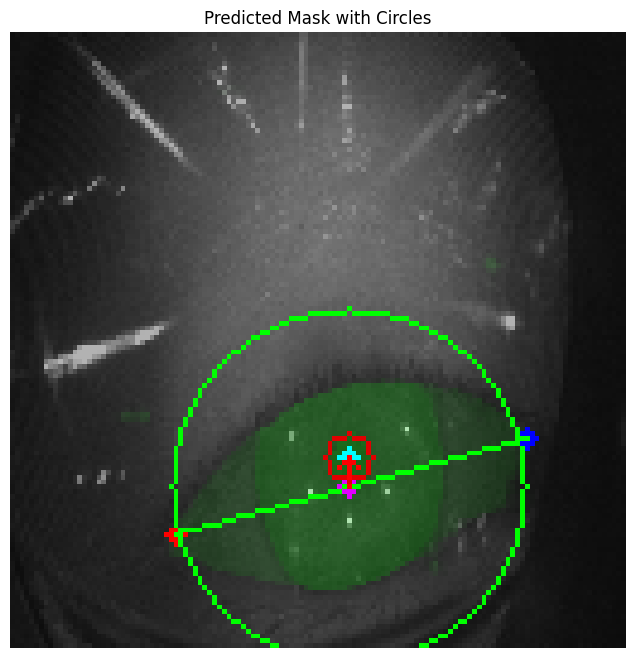

Time taken: 71.314453125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(104), np.int32(89))
Distance between Leftmost and Middle Point: 36
Error processing 129.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(106))
Rightmost Point: (np.int32(107), np.int32(84))


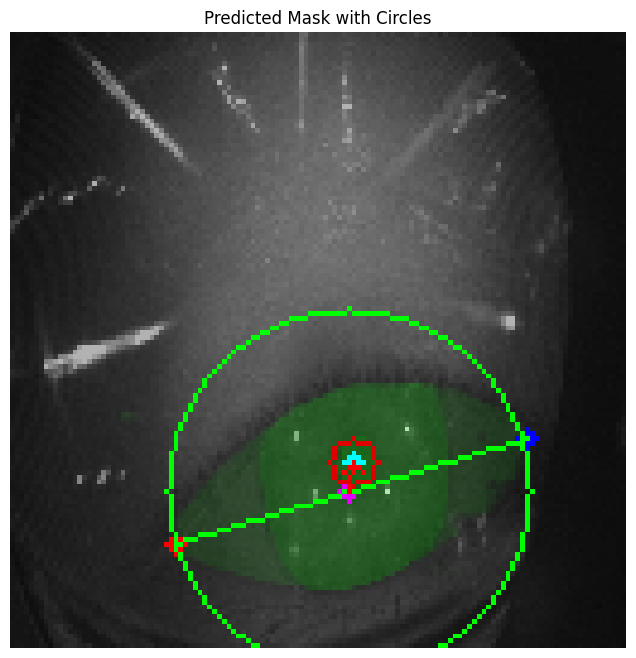

Time taken: 47.64404296875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 13.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(104))
Rightmost Point: (np.int32(108), np.int32(95))


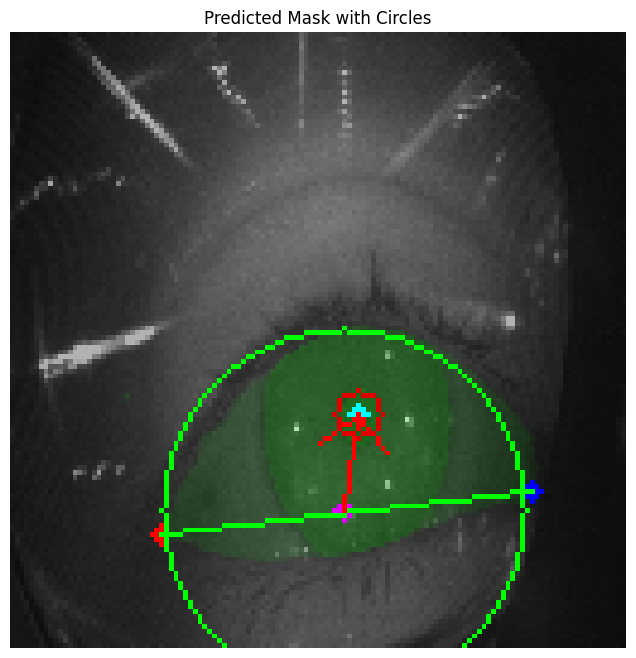

Time taken: 67.5302734375 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 130.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(107), np.int32(84))


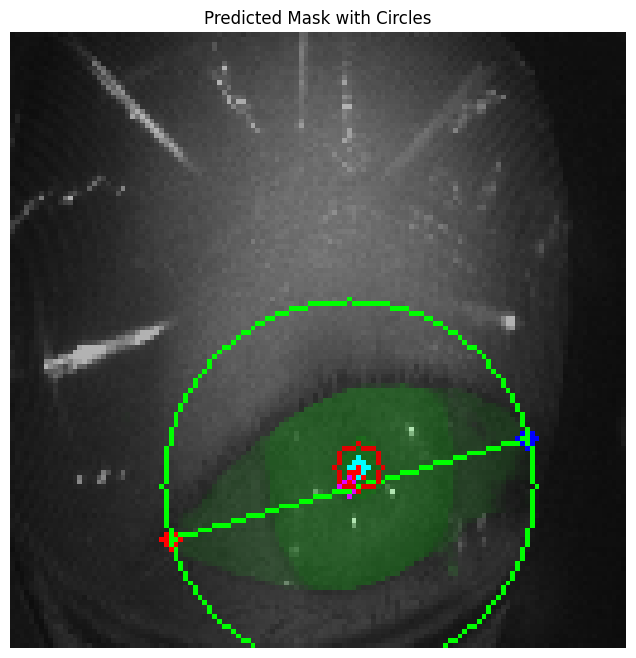

Time taken: 82.920166015625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(106), np.int32(85))
Distance between Leftmost and Middle Point: 37
Error processing 131.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(105))
Rightmost Point: (np.int32(106), np.int32(84))


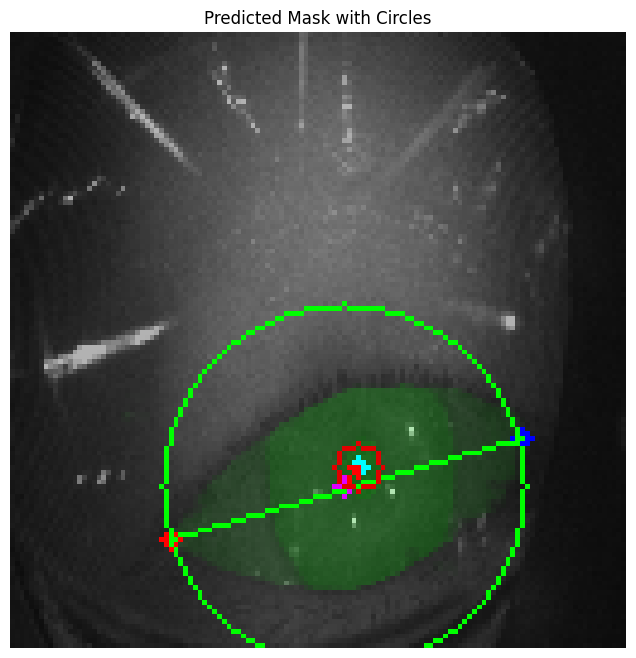

Time taken: 72.471923828125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(90))
Distance between Leftmost and Middle Point: 36
Error processing 132.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(92))


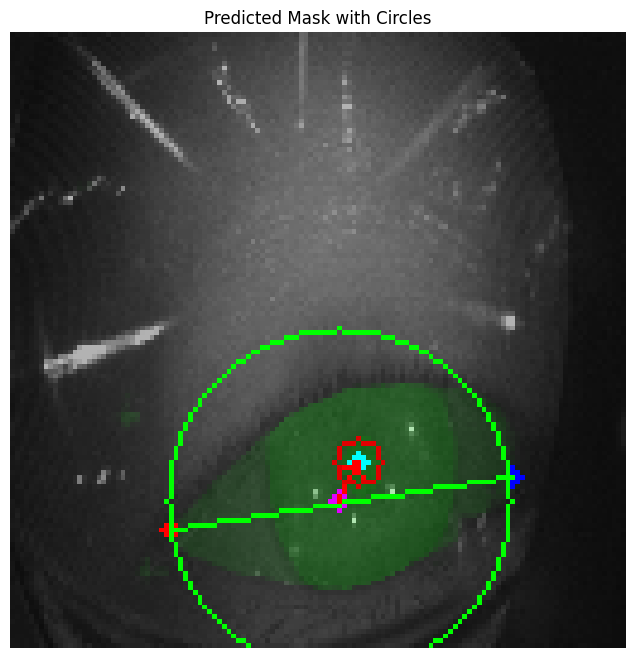

Time taken: 51.549072265625 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(84))
Distance between Leftmost and Middle Point: 38
Error processing 133.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Iris radius: 5
Leftmost Point: (np.int32(36), np.int32(105))
Rightmost Point: (np.int32(106), np.int32(85))


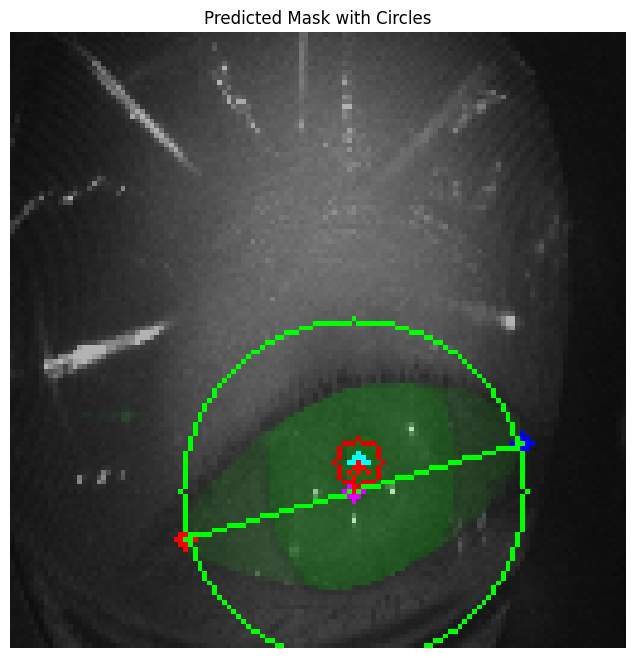

Time taken: 67.55419921875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 134.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Iris radius: 5
Leftmost Point: (np.int32(35), np.int32(106))
Rightmost Point: (np.int32(105), np.int32(89))


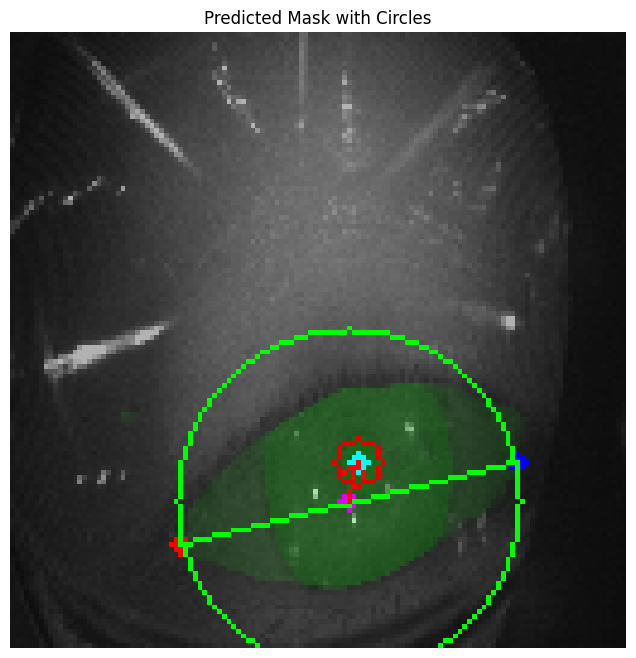

Time taken: 65.944580078125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(106), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 135.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(84))


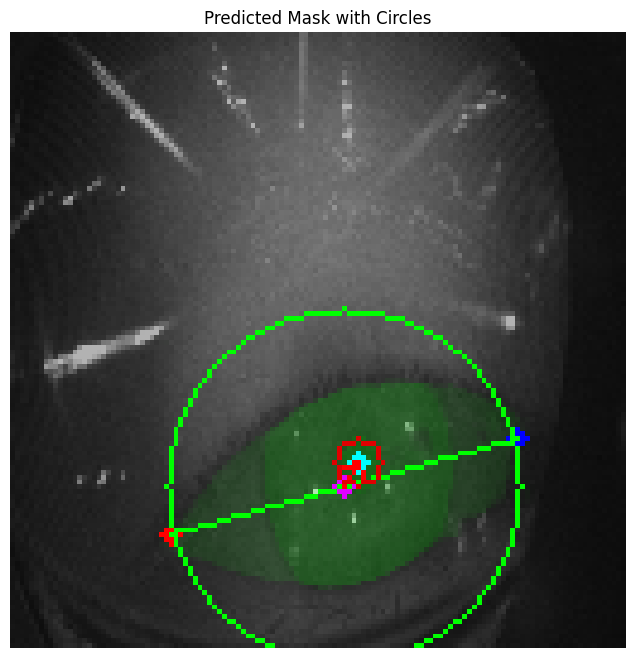

Time taken: 68.337890625 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 136.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(107), np.int32(84))


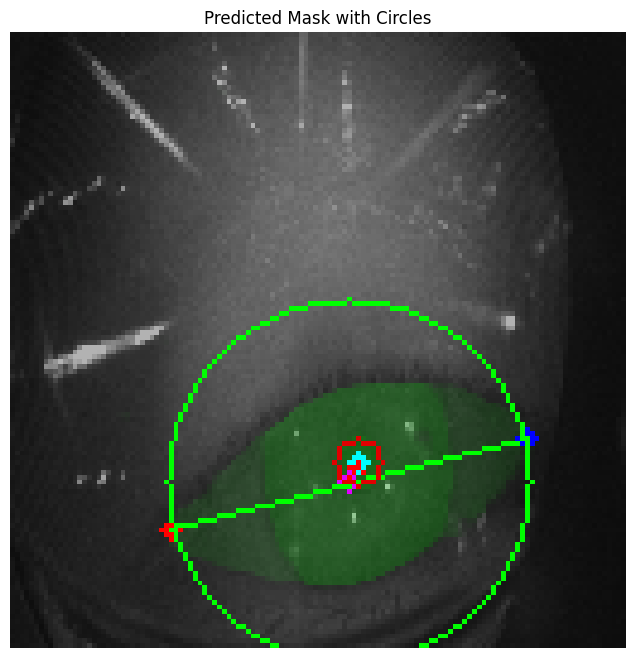

Time taken: 55.185302734375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 137.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(88))


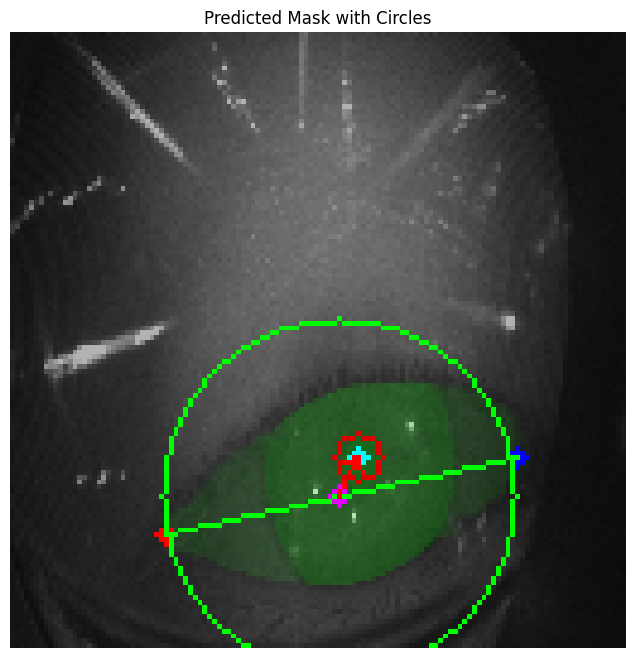

Time taken: 47.608154296875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 138.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(83))


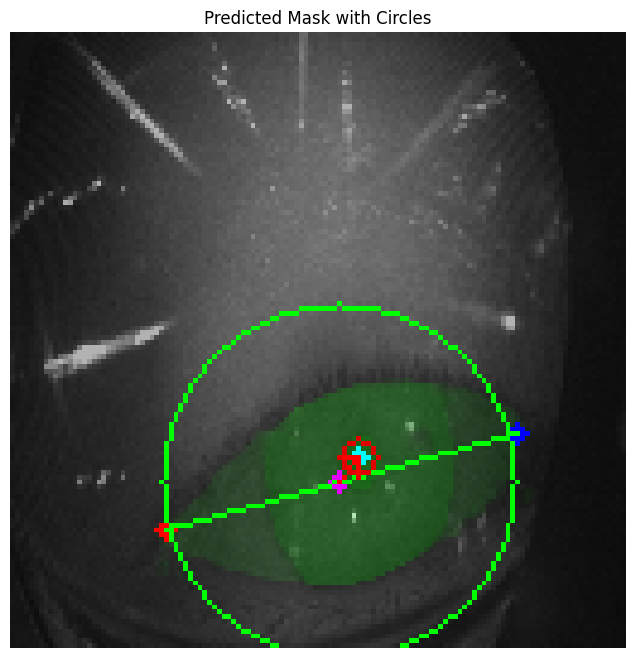

Time taken: 60.785400390625 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(86))
Distance between Leftmost and Middle Point: 36
Error processing 139.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(91))


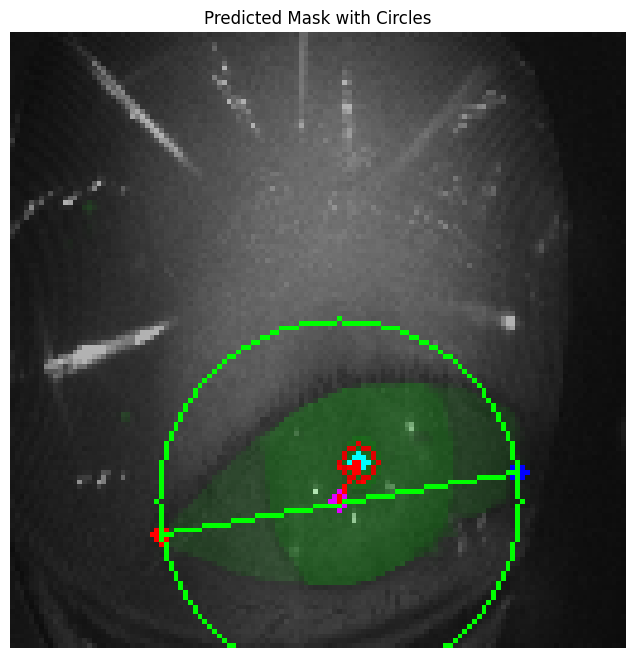

Time taken: 61.8388671875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 14.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(109), np.int32(88))


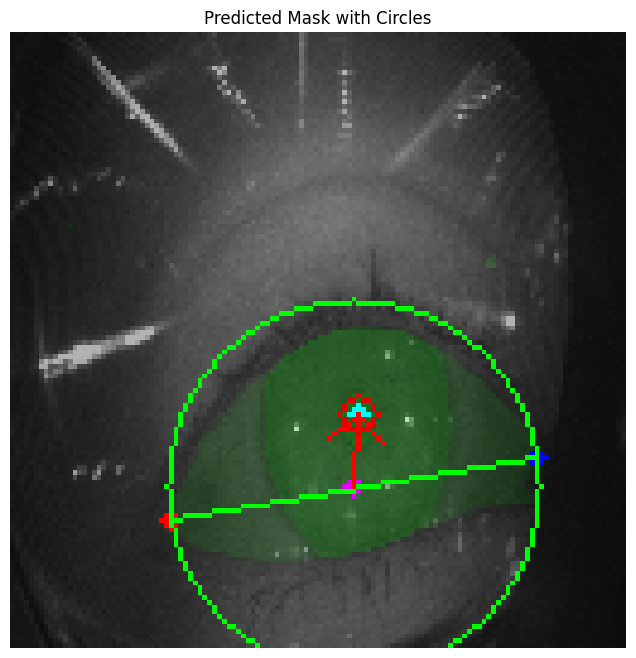

Time taken: 72.2431640625 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 38
Error processing 140.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(107), np.int32(86))


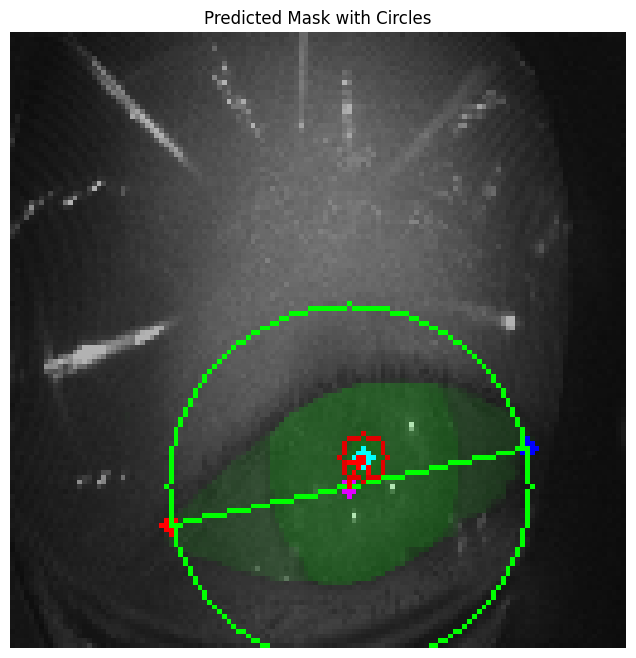

Time taken: 65.422607421875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(105), np.int32(83))
Distance between Leftmost and Middle Point: 38
Error processing 141.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(105))
Rightmost Point: (np.int32(108), np.int32(88))


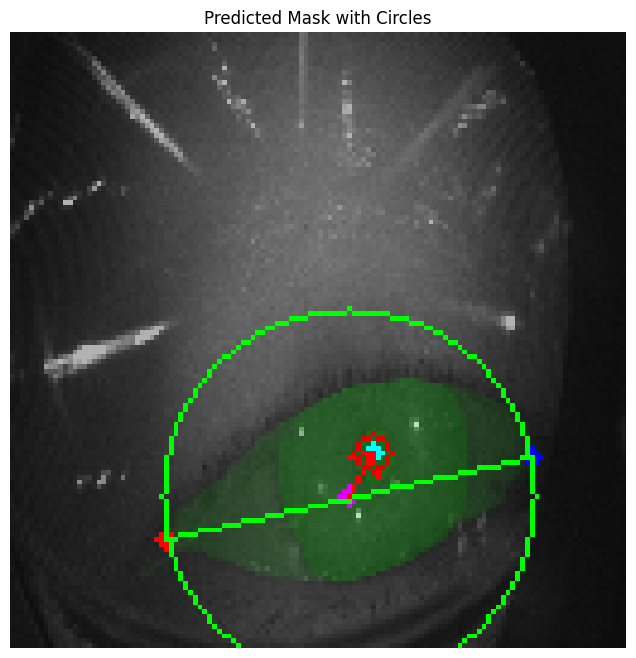

Time taken: 60.879638671875 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(102))
Rightmost Point: (np.int32(105), np.int32(84))
Distance between Leftmost and Middle Point: 36
Error processing 142.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Iris radius: 5
Leftmost Point: (np.int32(36), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(85))


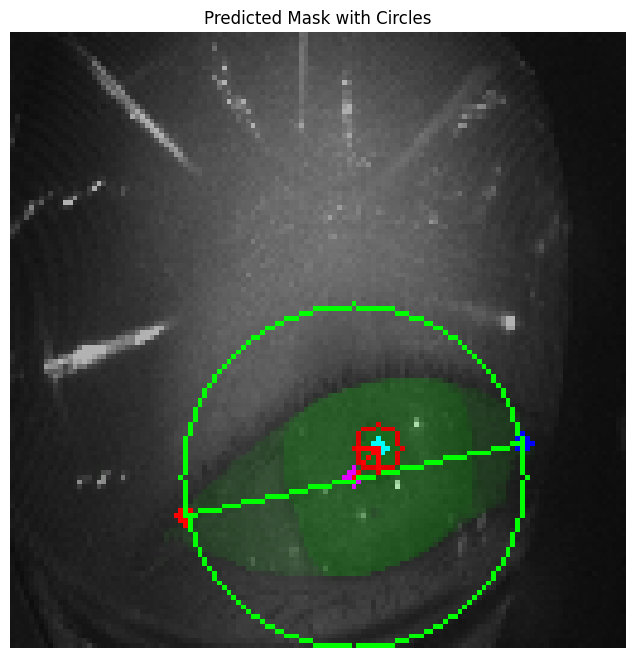

Time taken: 76.043212890625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(104))
Rightmost Point: (np.int32(105), np.int32(83))
Distance between Leftmost and Middle Point: 38
Error processing 143.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(85))


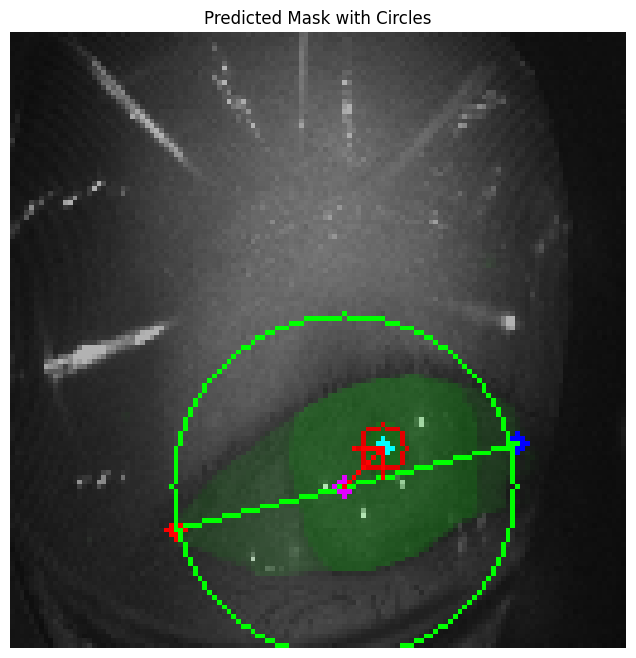

Time taken: 46.1708984375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(103), np.int32(83))
Distance between Leftmost and Middle Point: 36
Error processing 144.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(103))
Rightmost Point: (np.int32(105), np.int32(83))


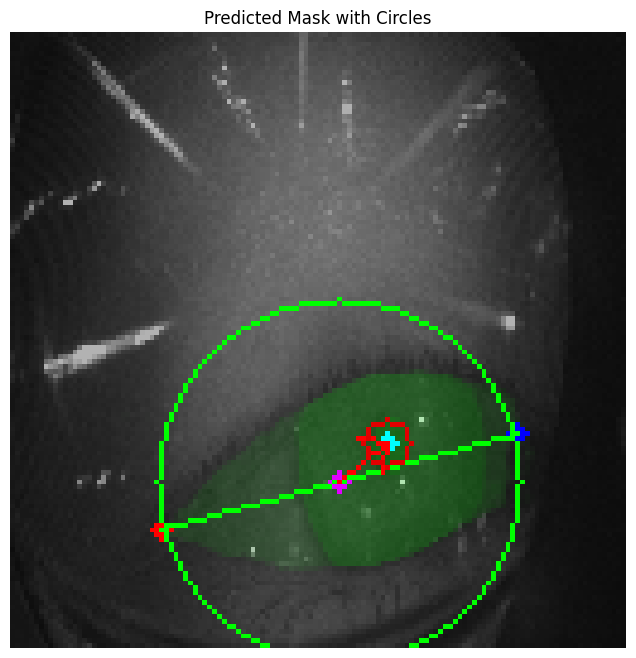

Time taken: 59.57568359375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(104), np.int32(85))
Distance between Leftmost and Middle Point: 36
Error processing 145.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(109), np.int32(87))


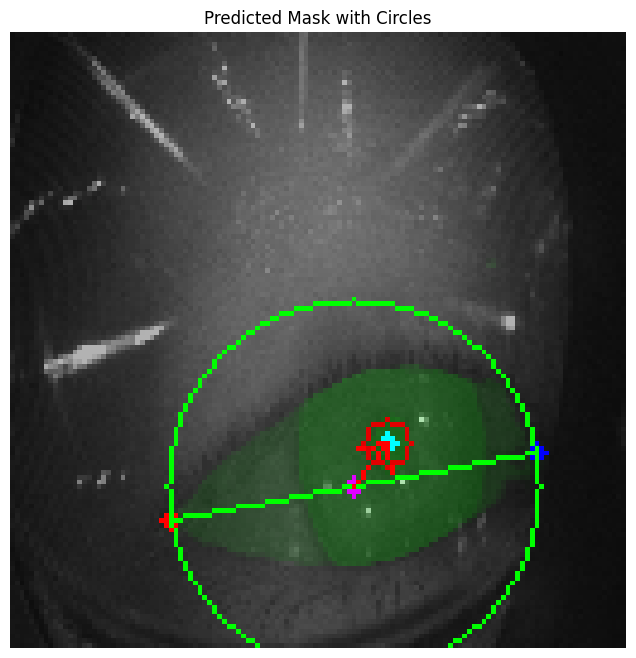

Time taken: 65.195556640625 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(82))
Distance between Leftmost and Middle Point: 36
Error processing 146.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Iris radius: 5
Leftmost Point: (np.int32(37), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(90))


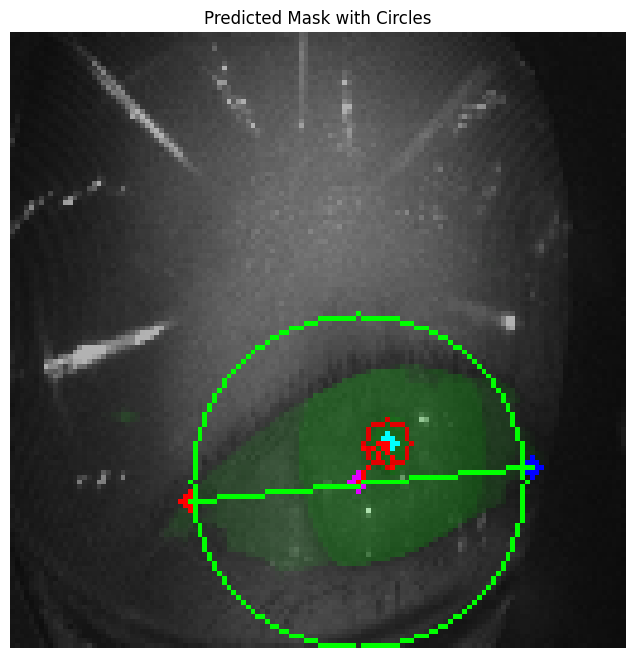

Time taken: 56.22802734375 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(100))
Rightmost Point: (np.int32(102), np.int32(97))
Distance between Leftmost and Middle Point: 34
Error processing 147.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(92))


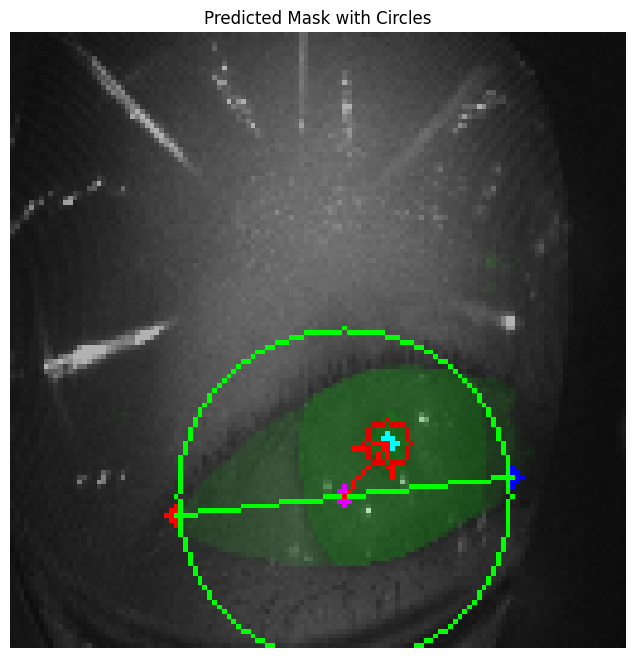

Time taken: 58.640625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(83))
Distance between Leftmost and Middle Point: 36
Error processing 148.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Iris radius: 5
Leftmost Point: (np.int32(36), np.int32(98))
Rightmost Point: (np.int32(104), np.int32(90))


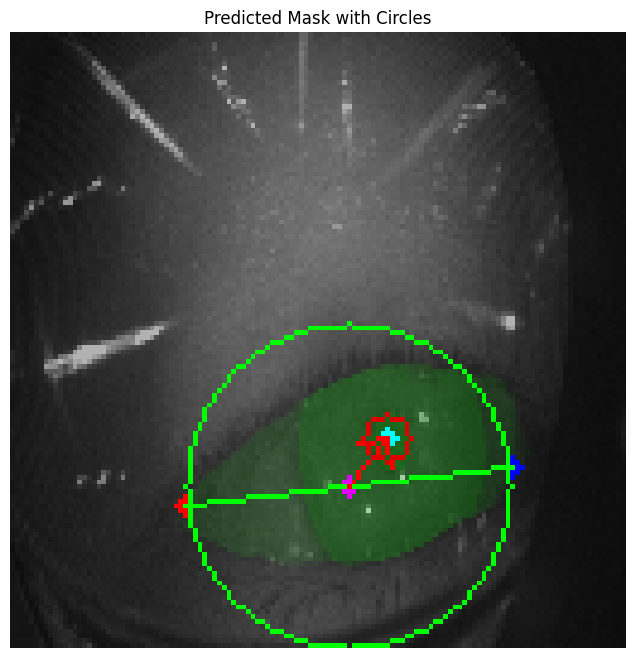

Time taken: 50.0302734375 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(86))
Distance between Leftmost and Middle Point: 36
Error processing 149.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(109), np.int32(88))


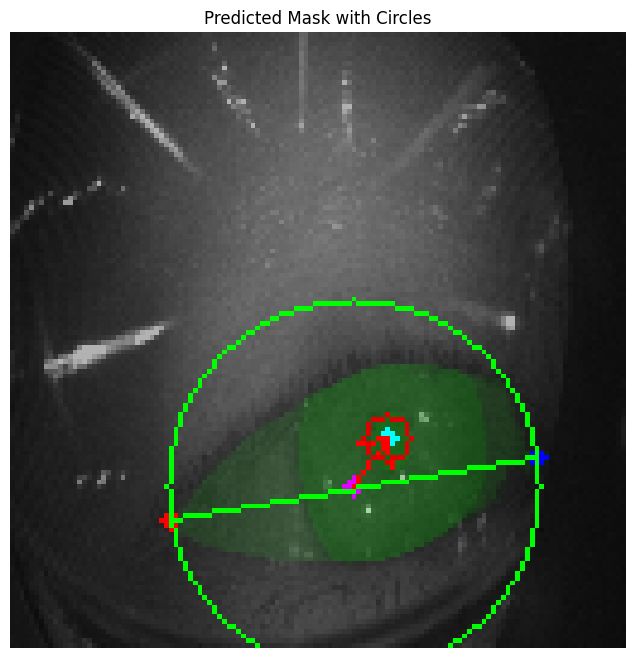

Time taken: 58.523193359375 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(99))
Rightmost Point: (np.int32(104), np.int32(88))
Distance between Leftmost and Middle Point: 36
Error processing 15.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(109), np.int32(88))


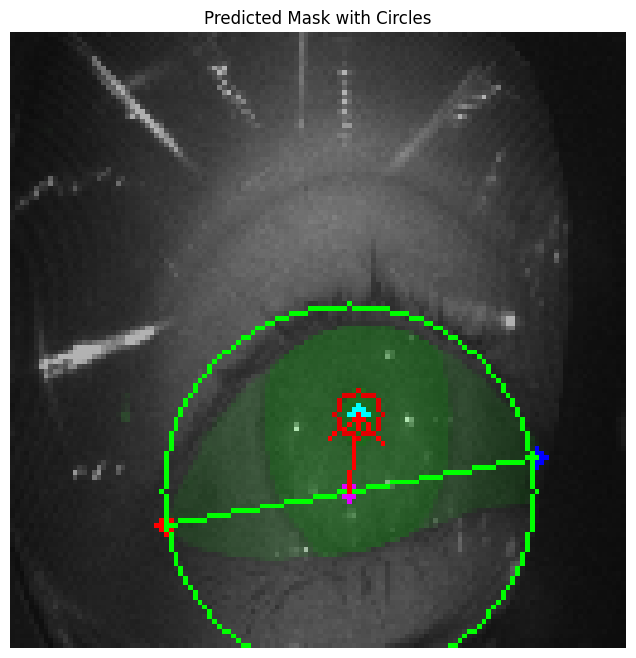

Time taken: 54.93017578125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(90))
Distance between Leftmost and Middle Point: 38
Error processing 150.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Iris radius: 5
Leftmost Point: (np.int32(38), np.int32(96))
Rightmost Point: (np.int32(105), np.int32(84))


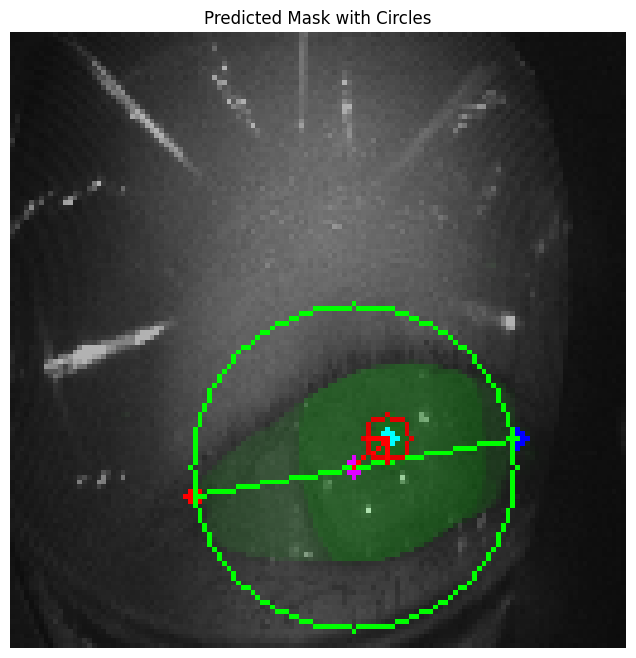

Time taken: 57.188232421875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(103), np.int32(88))
Distance between Leftmost and Middle Point: 36
Error processing 151.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(99))
Rightmost Point: (np.int32(109), np.int32(88))


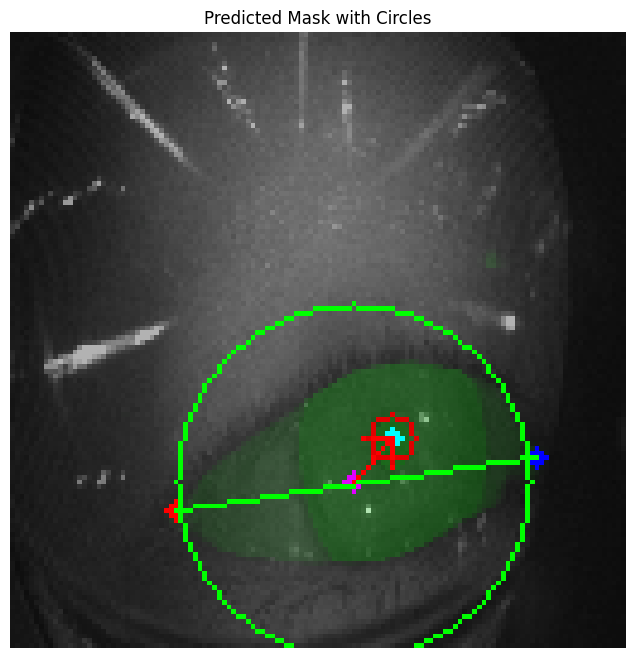

Time taken: 54.39697265625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(103), np.int32(89))
Distance between Leftmost and Middle Point: 36
Error processing 152.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Iris radius: 4
Leftmost Point: (np.int32(35), np.int32(100))
Rightmost Point: (np.int32(109), np.int32(87))


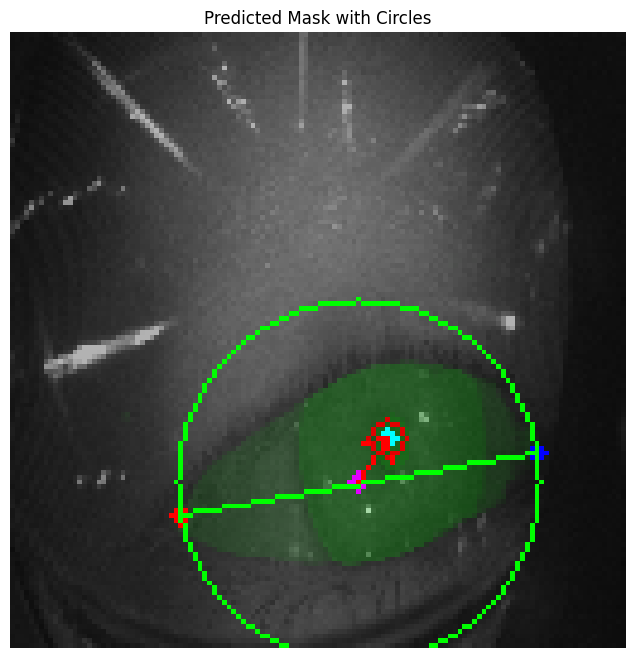

Time taken: 57.167236328125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(105), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 153.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Iris radius: 5
Leftmost Point: (np.int32(36), np.int32(97))
Rightmost Point: (np.int32(106), np.int32(83))


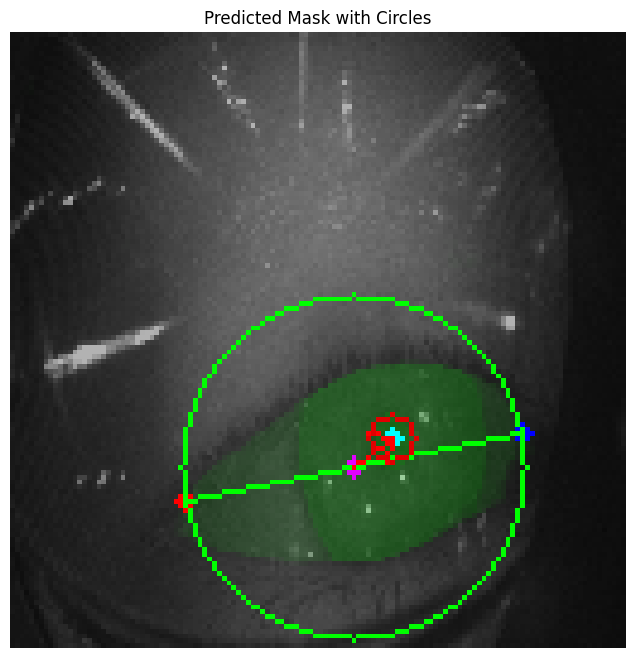

Time taken: 52.74951171875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(104), np.int32(88))
Distance between Leftmost and Middle Point: 36
Error processing 154.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(104), np.int32(86))


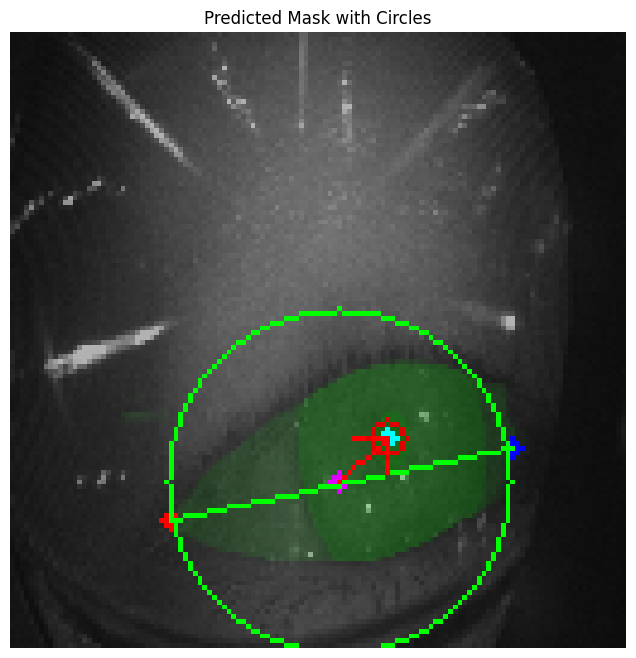

Time taken: 56.307861328125 ms
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(99))
Rightmost Point: (np.int32(102), np.int32(91))
Distance between Leftmost and Middle Point: 34
Error processing 155.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(88))


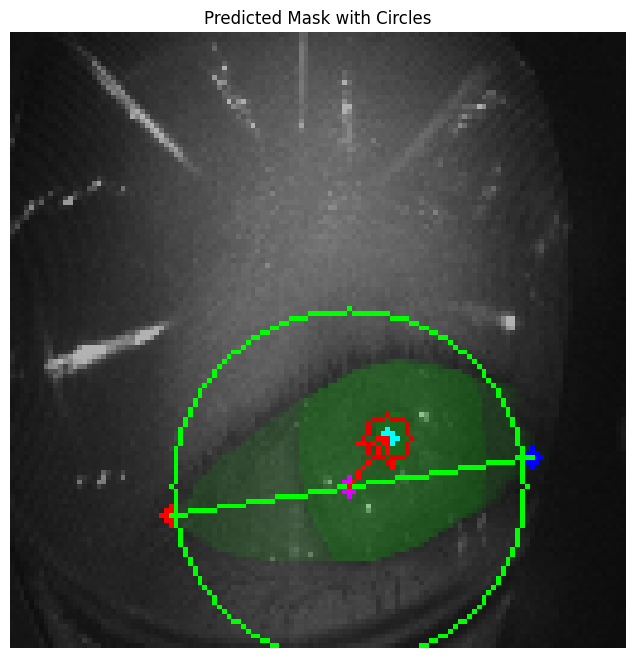

Time taken: 58.63134765625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(103), np.int32(87))
Distance between Leftmost and Middle Point: 36
Error processing 16.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(88))


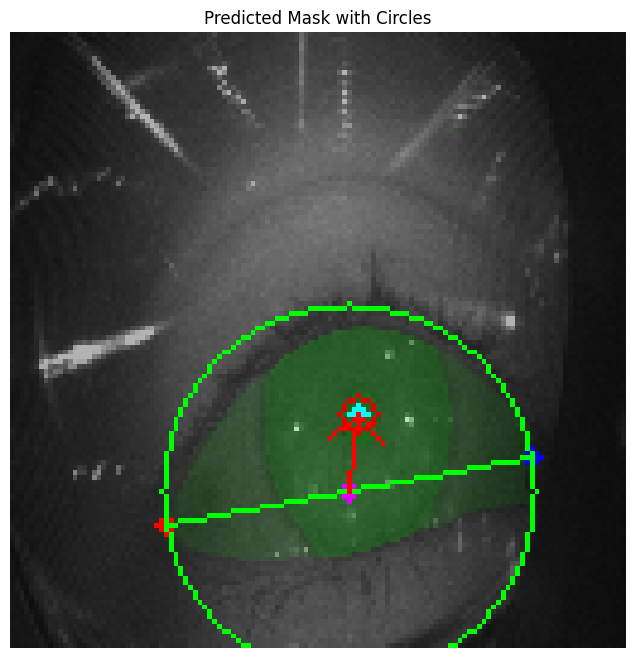

Time taken: 55.546875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(108), np.int32(91))
Distance between Leftmost and Middle Point: 38
Error processing 17.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(90))


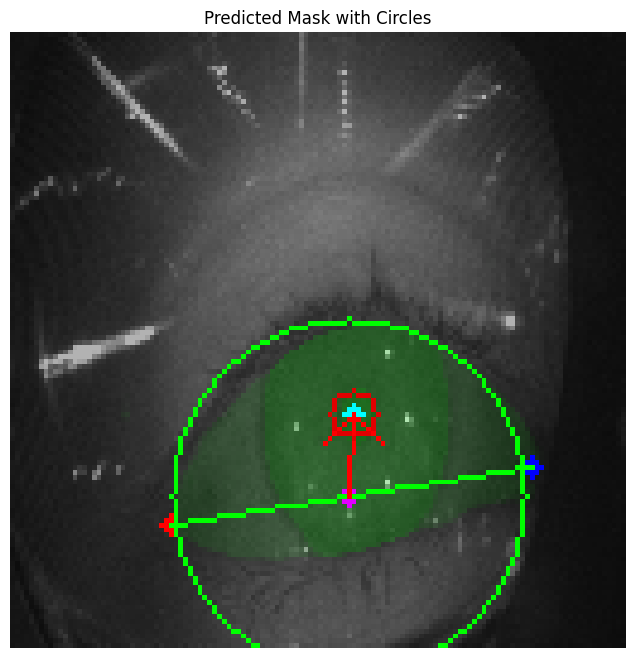

Time taken: 58.39404296875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 37
Error processing 18.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(103))
Rightmost Point: (np.int32(108), np.int32(97))


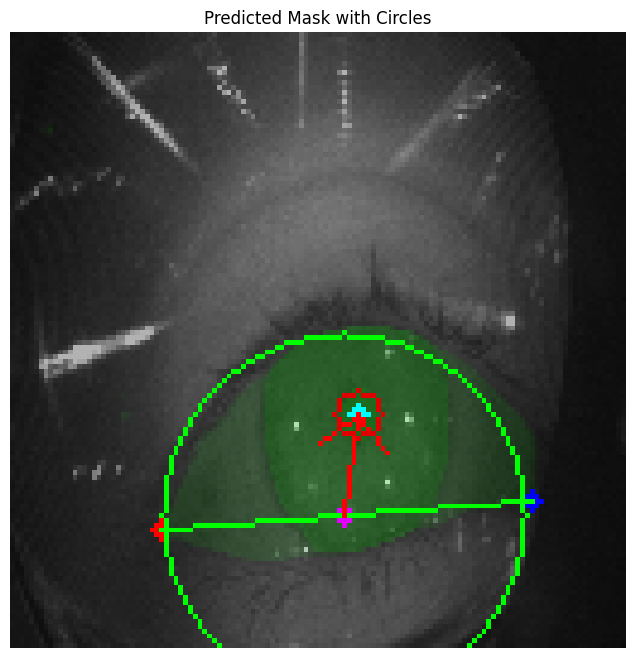

Time taken: 95.521484375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 19.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(96))


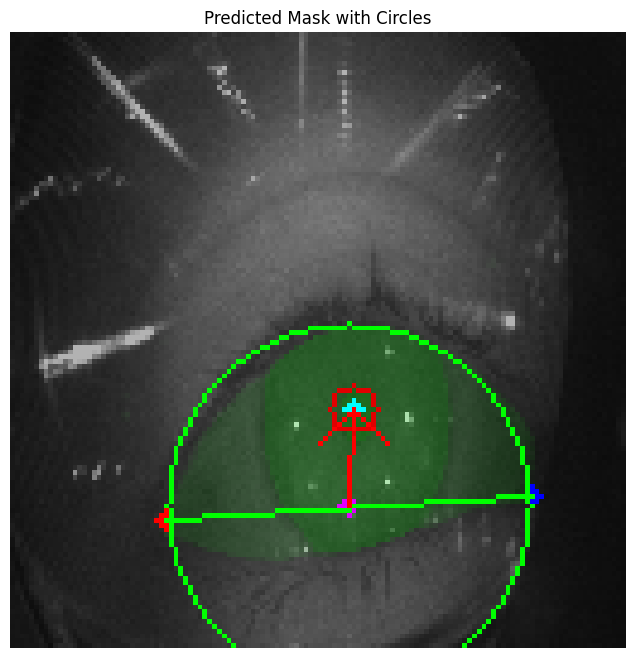

Time taken: 51.400634765625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 37
Error processing 2.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(110), np.int32(87))


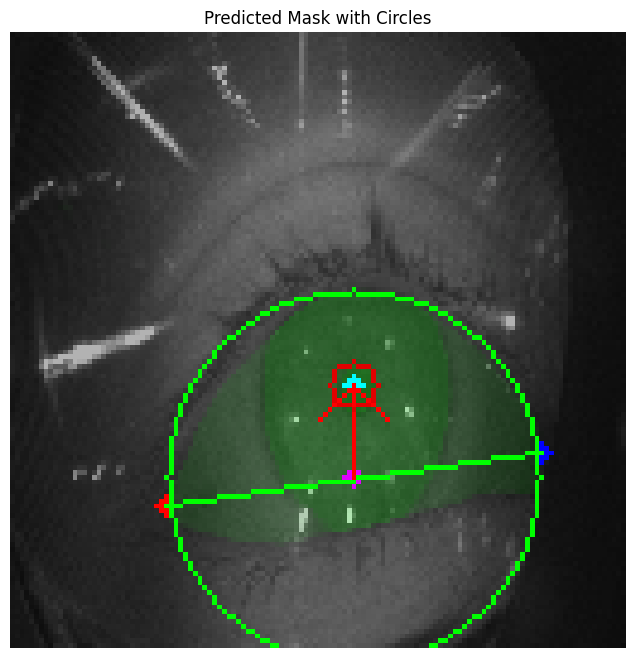

Time taken: 101.10595703125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(92))
Distance between Leftmost and Middle Point: 38
Error processing 20.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(109), np.int32(84))


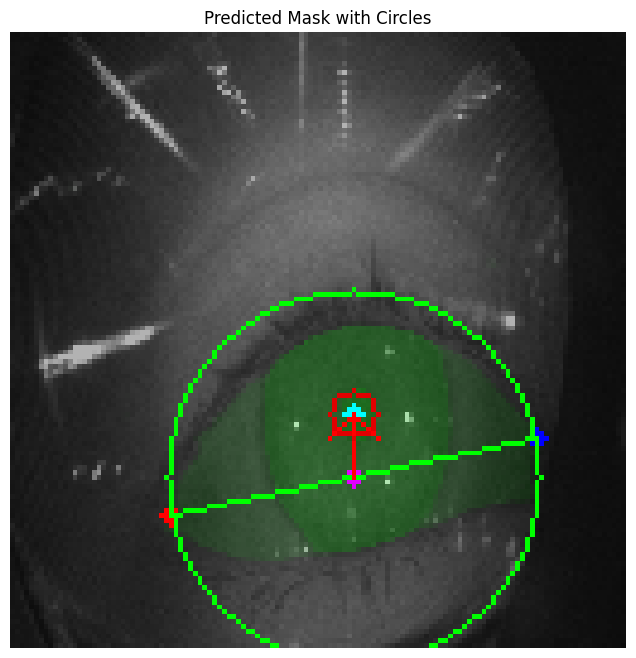

Time taken: 80.22802734375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 38
Error processing 21.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(109), np.int32(84))


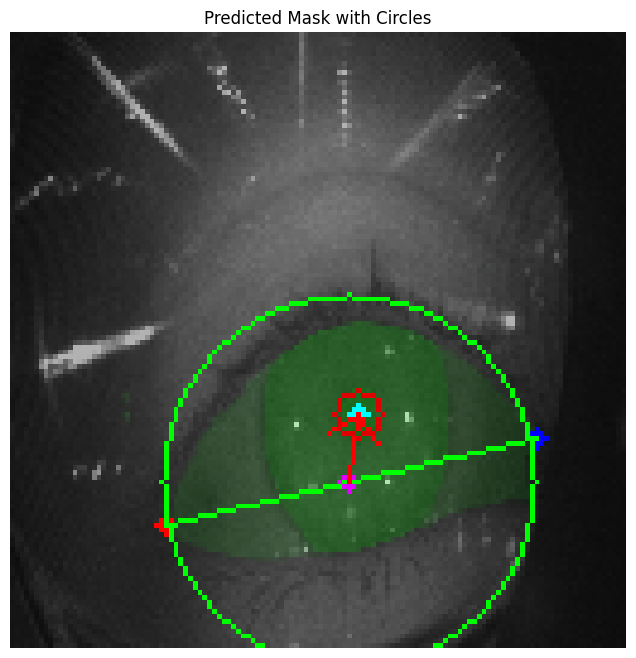

Time taken: 81.32958984375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 22.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(104))
Rightmost Point: (np.int32(108), np.int32(96))


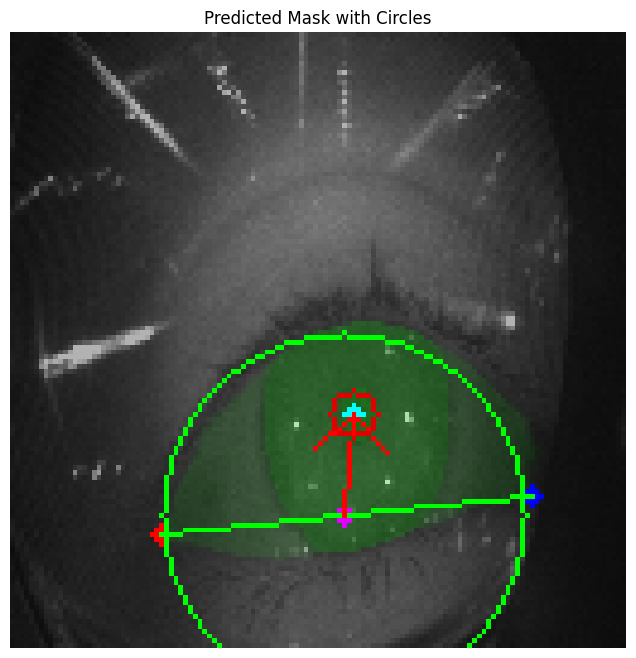

Time taken: 56.4296875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(90))
Distance between Leftmost and Middle Point: 37
Error processing 23.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(102))
Rightmost Point: (np.int32(109), np.int32(89))


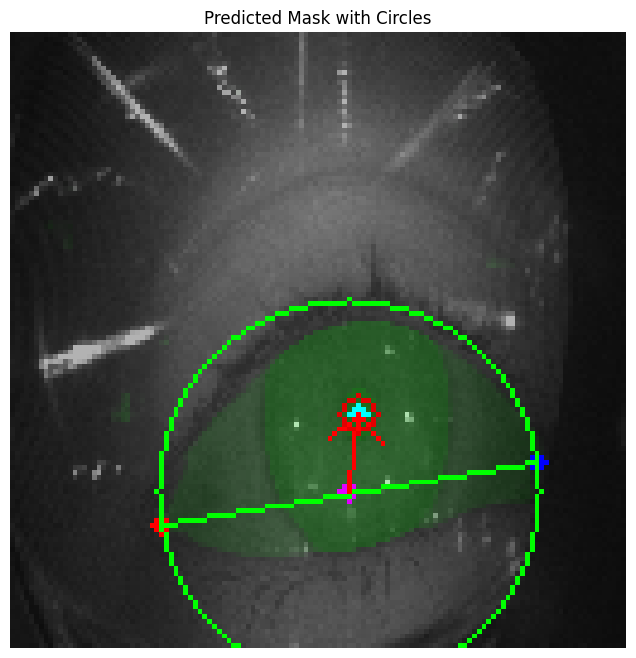

Time taken: 65.056640625 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 24.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(109), np.int32(90))


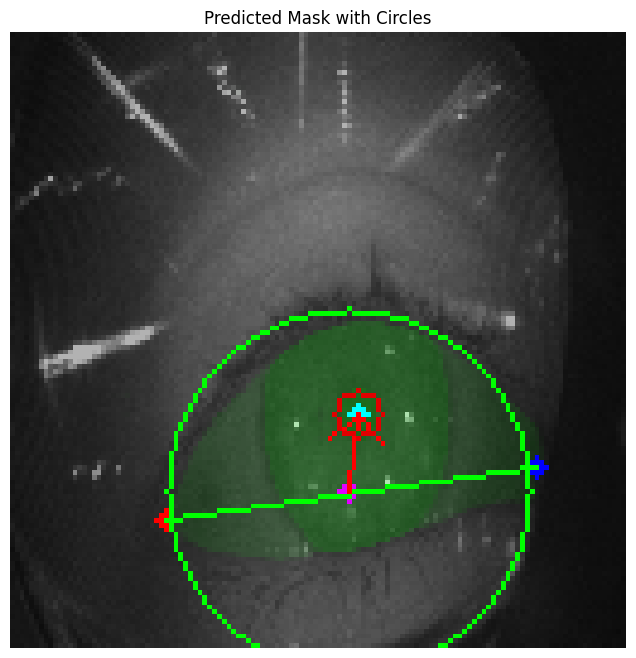

Time taken: 99.239501953125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(109), np.int32(93))
Distance between Leftmost and Middle Point: 38
Error processing 25.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(109), np.int32(87))


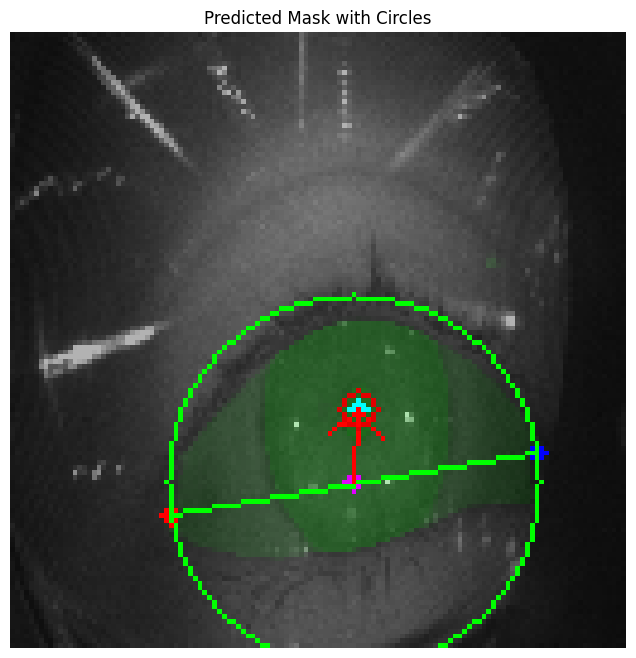

Time taken: 111.542236328125 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(93))
Distance between Leftmost and Middle Point: 38
Error processing 26.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(104))
Rightmost Point: (np.int32(109), np.int32(91))


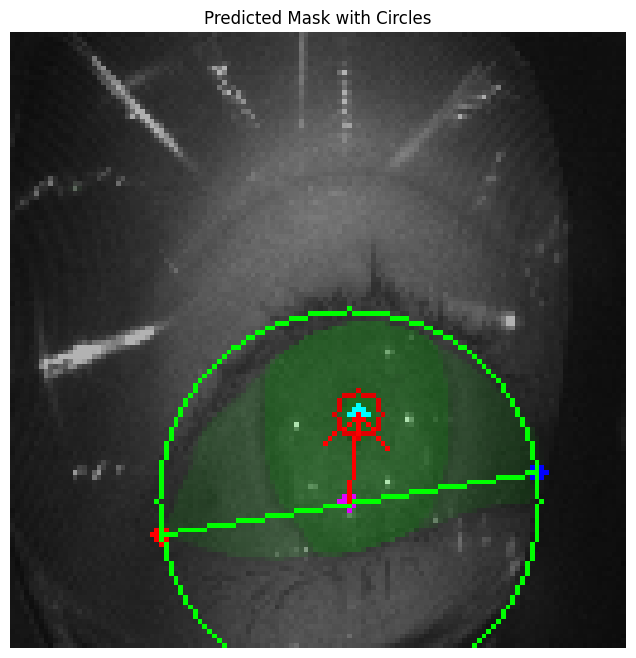

Time taken: 69.193603515625 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 38
Error processing 27.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(102))
Rightmost Point: (np.int32(109), np.int32(84))


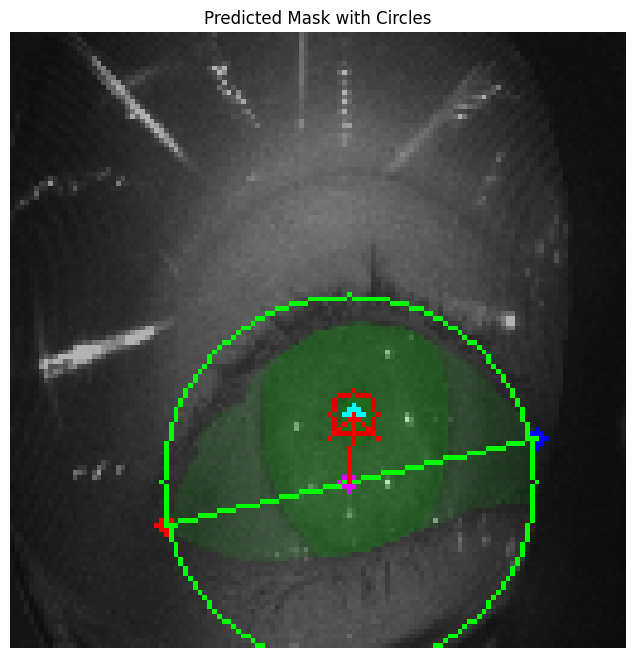

Time taken: 67.96826171875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 38
Error processing 28.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(109), np.int32(90))


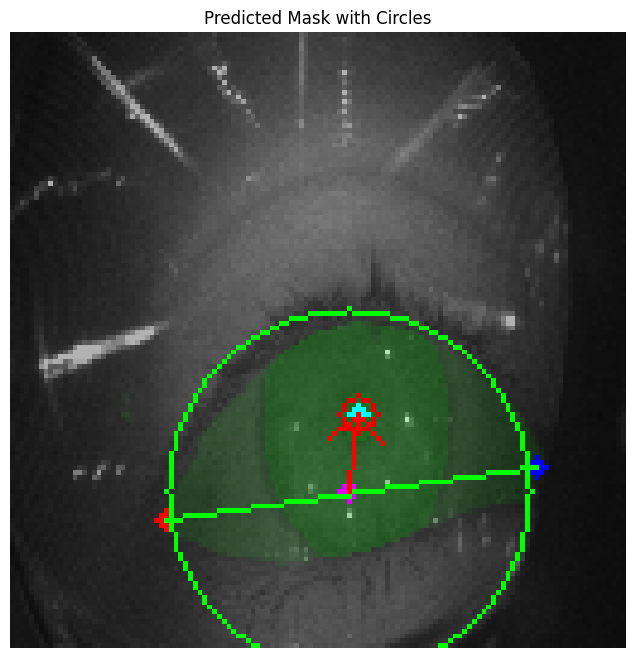

Time taken: 49.06005859375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 29.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(102))
Rightmost Point: (np.int32(108), np.int32(88))


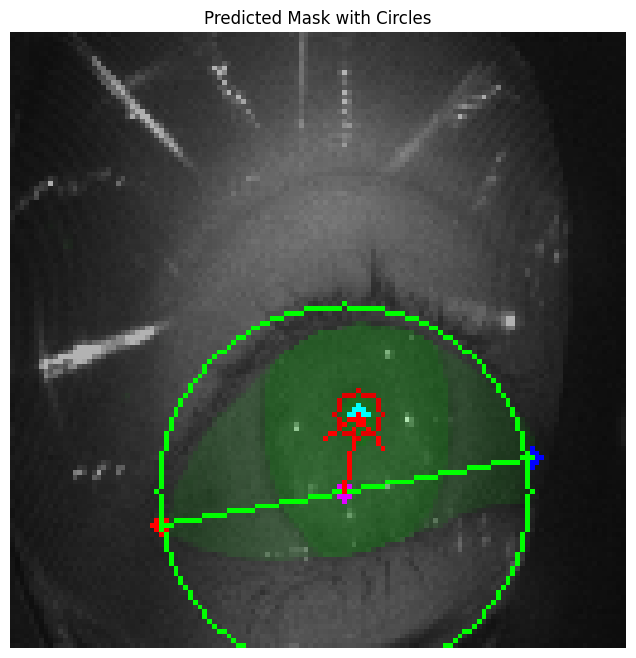

Time taken: 65.276611328125 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(93))
Distance between Leftmost and Middle Point: 38
Error processing 3.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
No iris contours found.
Error processing 3.png: cannot unpack non-iterable NoneType object
Error processing 30.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
No iris contours found.
Error processing 30.png: cannot unpack non-iterable NoneType object
Error processing 31.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.i

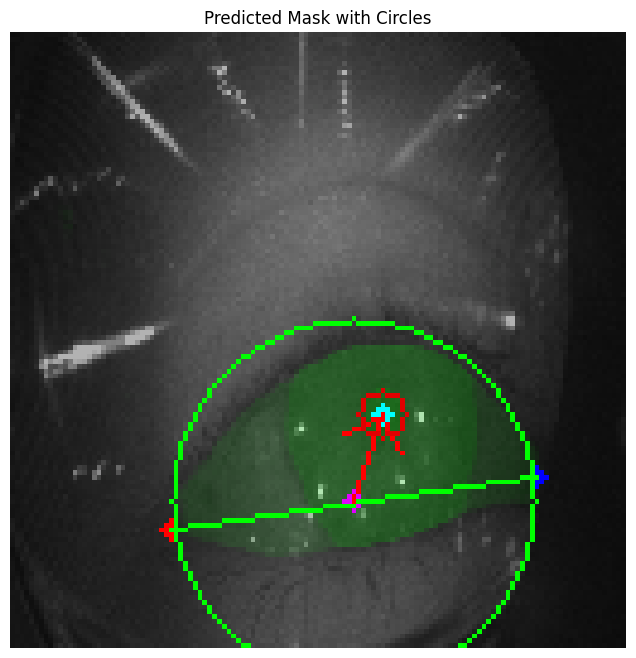

Time taken: 63.28369140625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(106), np.int32(85))
Distance between Leftmost and Middle Point: 37
Error processing 32.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(90))


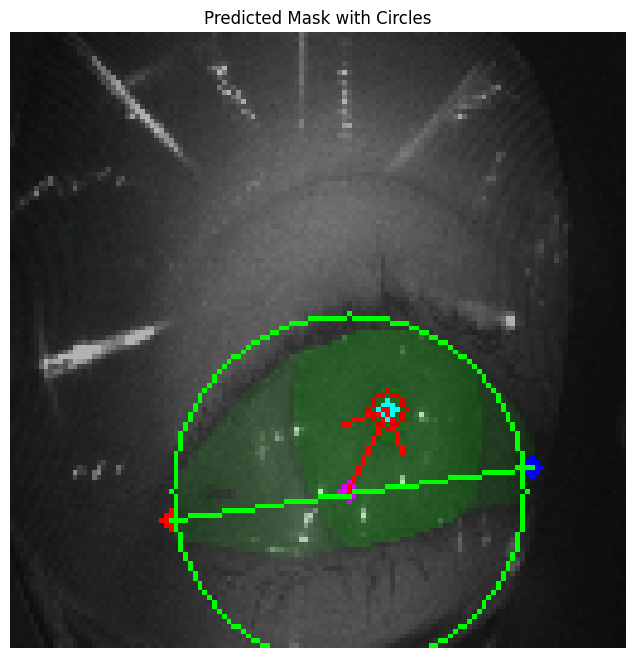

Time taken: 61.515869140625 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(91))
Distance between Leftmost and Middle Point: 37
Error processing 33.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Iris radius: 5
Leftmost Point: (np.int32(34), np.int32(95))
Rightmost Point: (np.int32(108), np.int32(90))


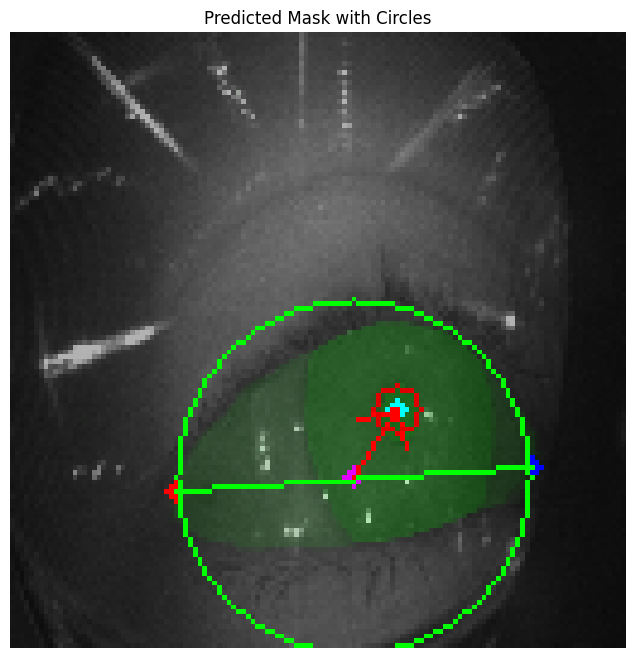

Time taken: 59.750244140625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(106), np.int32(95))
Distance between Leftmost and Middle Point: 36
Error processing 34.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(107), np.int32(87))


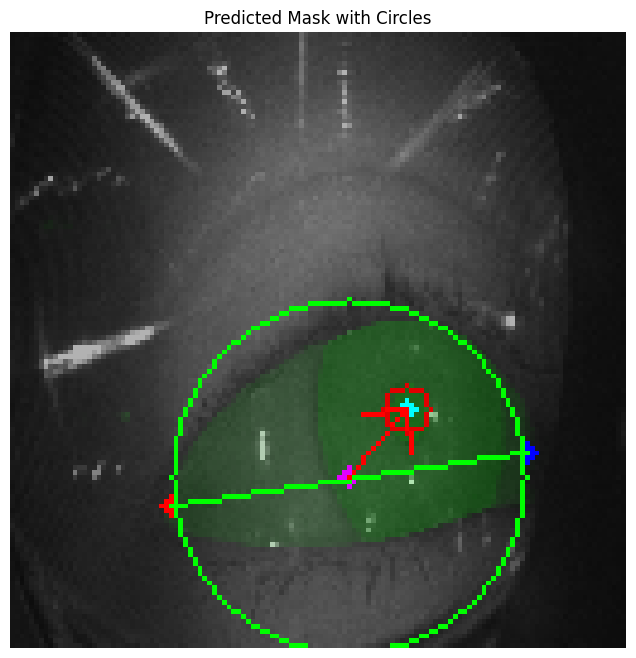

Time taken: 54.75732421875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(107), np.int32(89))
Distance between Leftmost and Middle Point: 37
Error processing 35.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(91))


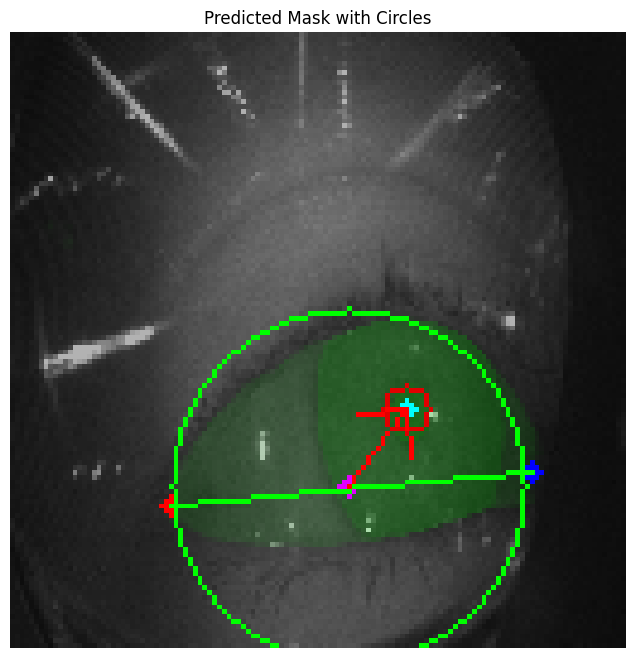

Time taken: 53.10205078125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 38
Error processing 36.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(84))


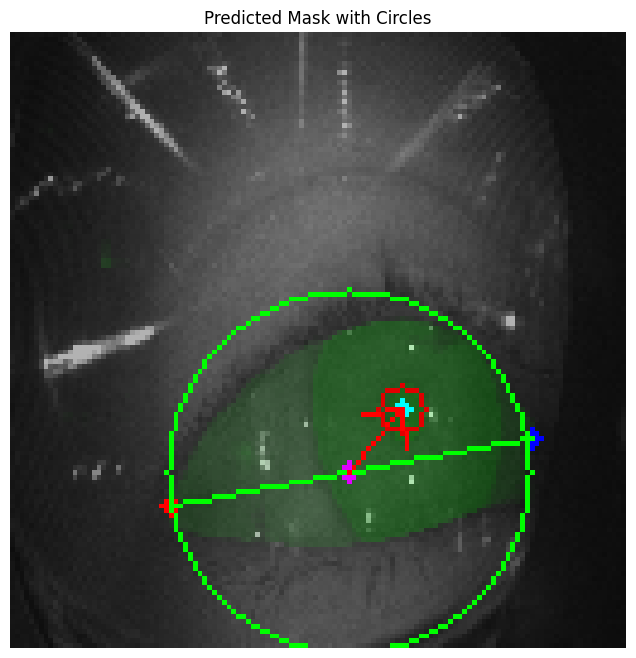

Time taken: 102.9892578125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 37.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(87))


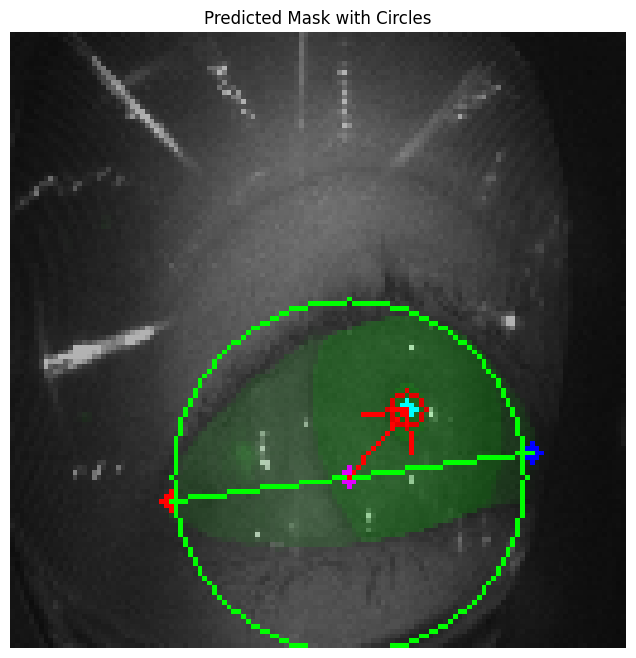

Time taken: 95.790771484375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(87))
Distance between Leftmost and Middle Point: 37
Error processing 38.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(83))


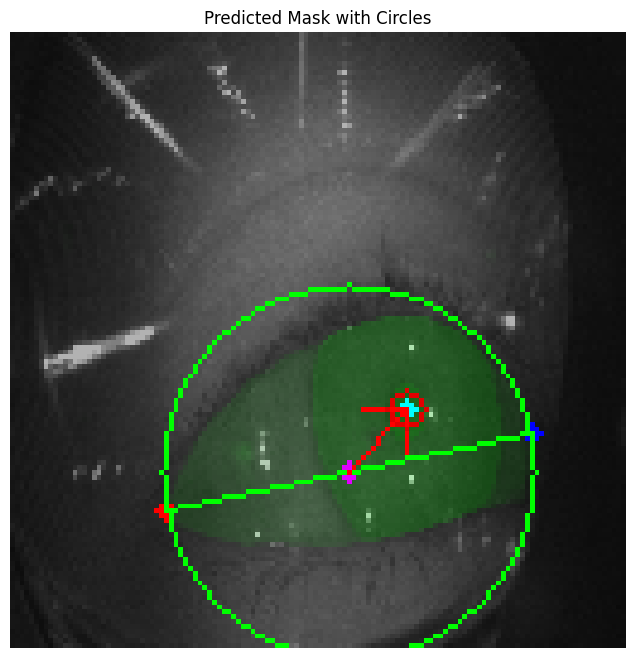

Time taken: 112.6494140625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(109), np.int32(91))
Distance between Leftmost and Middle Point: 38
Error processing 39.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(92))


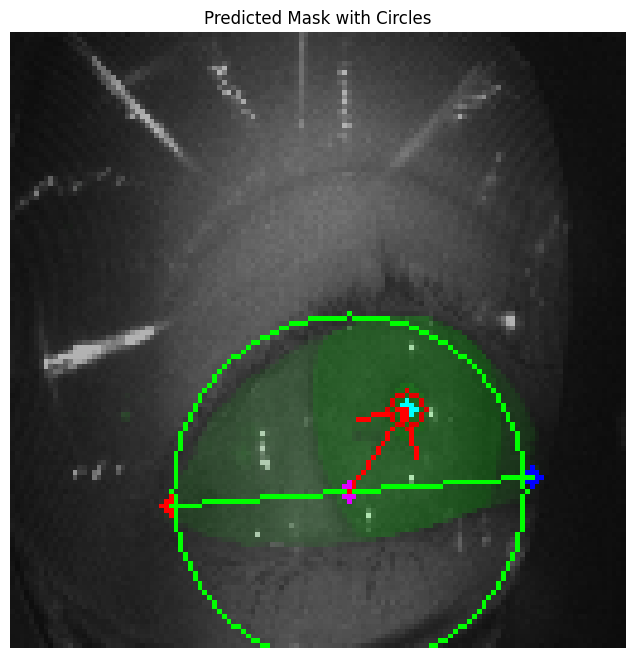

Time taken: 110.84375 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 38
Error processing 4.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(103))
Rightmost Point: (np.int32(109), np.int32(88))


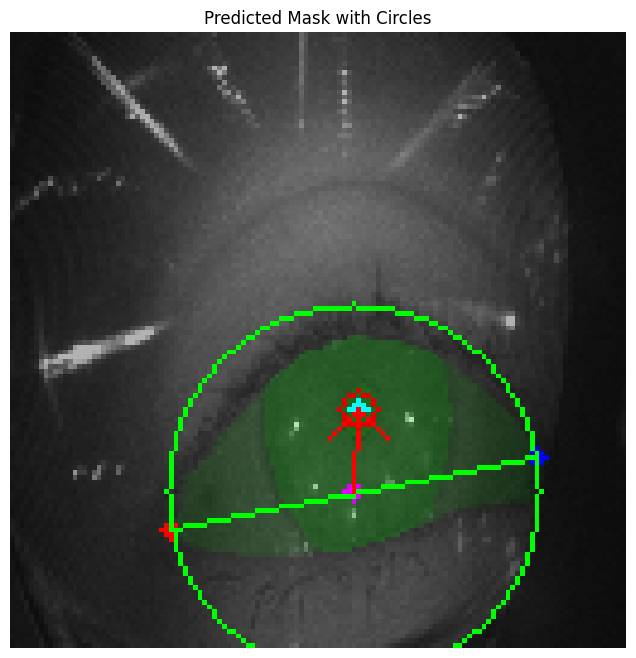

Time taken: 77.983154296875 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 37
Error processing 40.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(85))


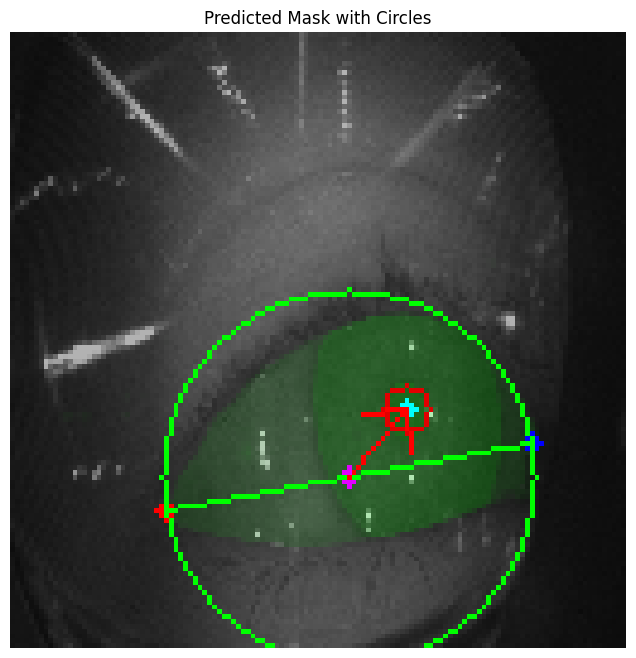

Time taken: 63.475830078125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(108), np.int32(91))
Distance between Leftmost and Middle Point: 37
Error processing 41.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(84))


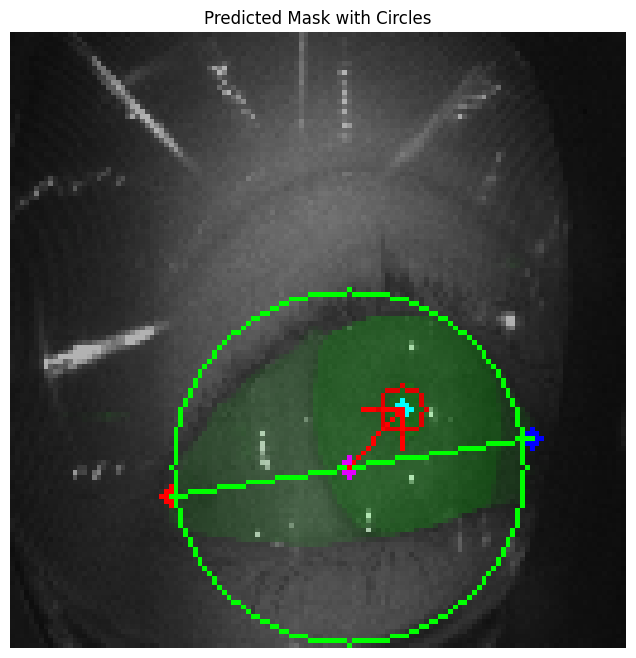

Time taken: 75.7529296875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(94))
Rightmost Point: (np.int32(108), np.int32(91))
Distance between Leftmost and Middle Point: 37
Error processing 42.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(87))


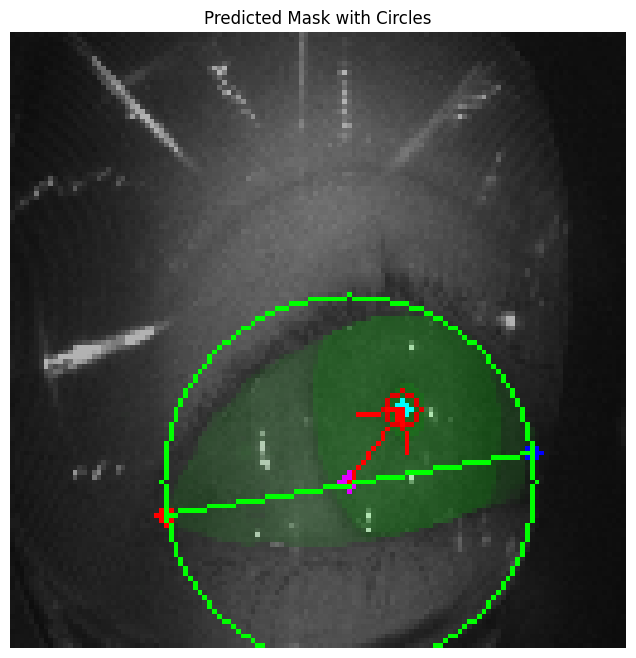

Time taken: 108.444580078125 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(95))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 37
Error processing 43.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(84))


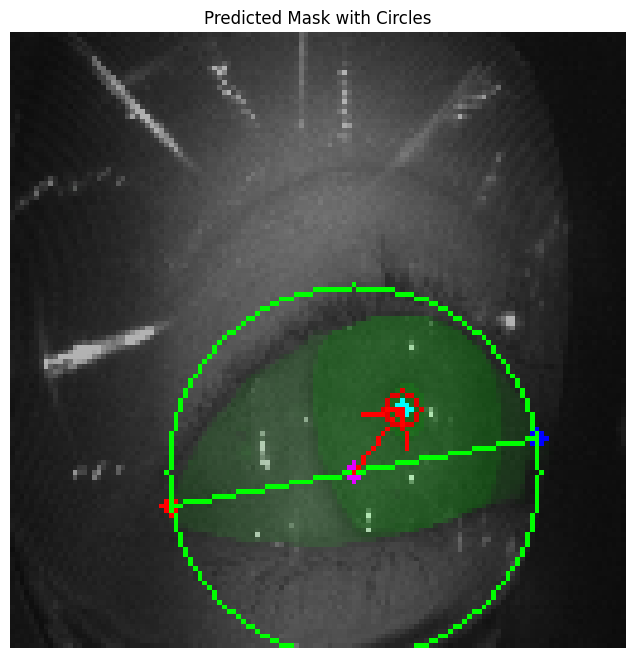

Time taken: 85.614501953125 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(92))
Distance between Leftmost and Middle Point: 38
Error processing 44.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(108), np.int32(87))


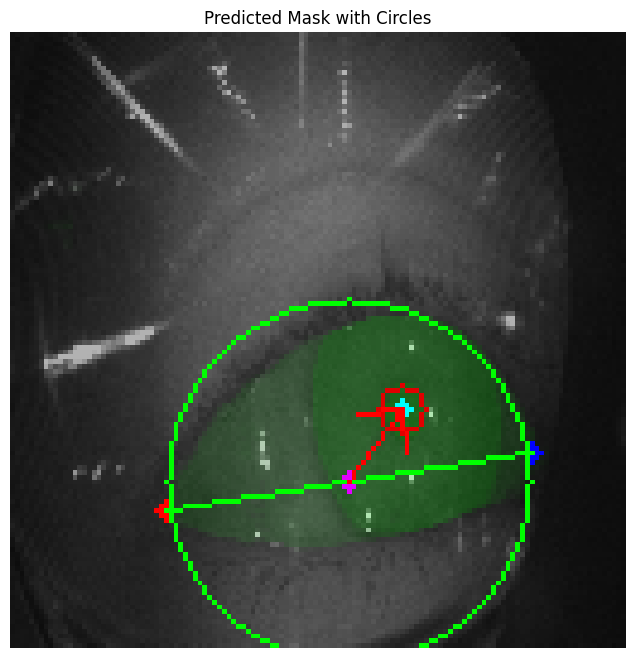

Time taken: 110.274169921875 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(84))
Distance between Leftmost and Middle Point: 39
Error processing 45.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(90))


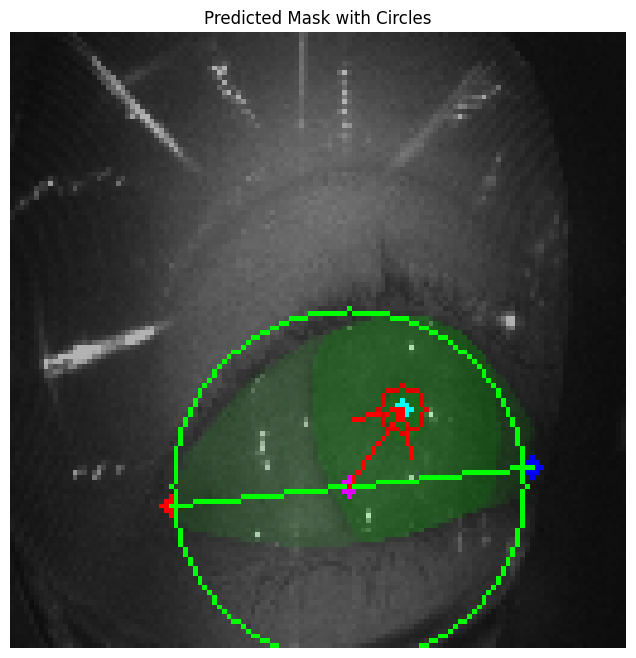

Time taken: 71.030517578125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(107), np.int32(93))
Distance between Leftmost and Middle Point: 37
Error processing 46.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(98))
Rightmost Point: (np.int32(108), np.int32(88))


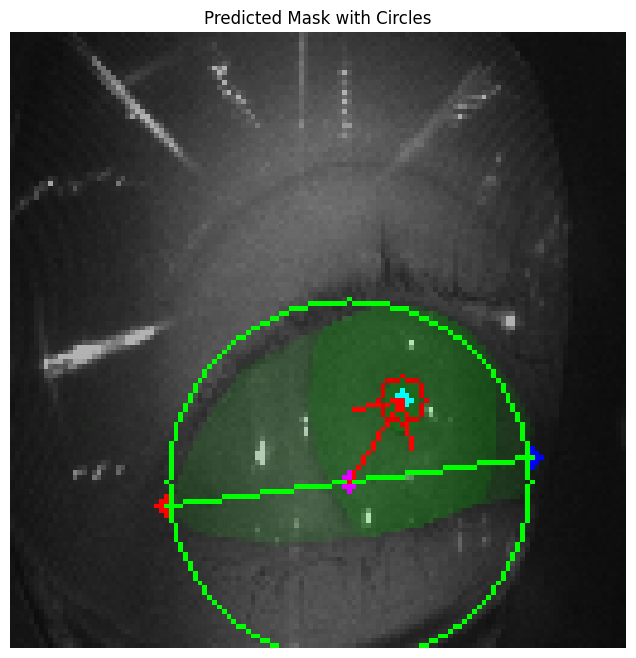

Time taken: 111.07177734375 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(93))
Distance between Leftmost and Middle Point: 38
Error processing 47.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(95))
Rightmost Point: (np.int32(110), np.int32(91))


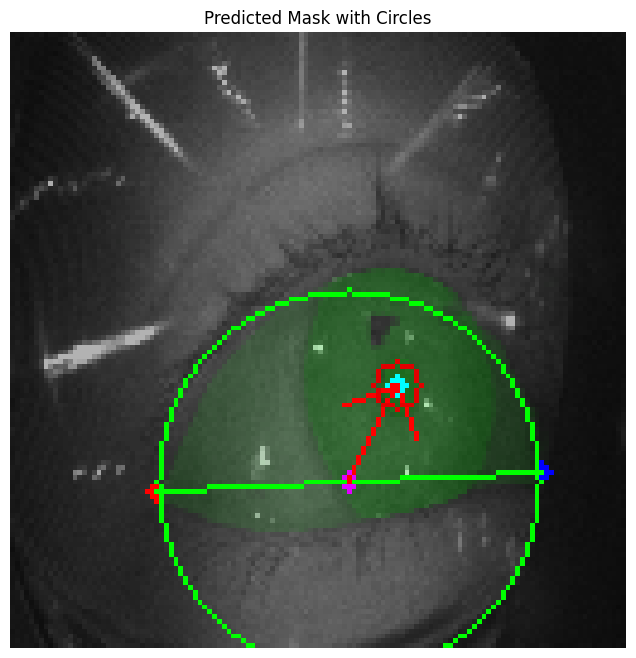

Time taken: 90.117431640625 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(96))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 39
Error processing 48.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(86))


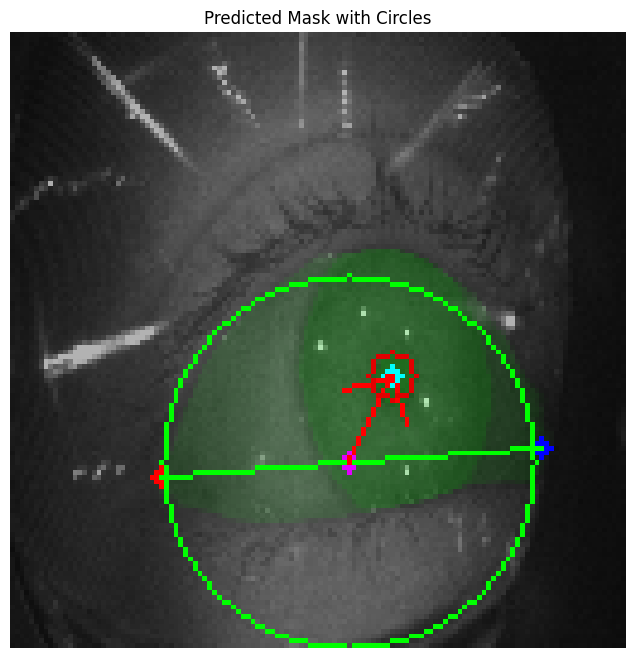

Time taken: 62.8798828125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 40
Error processing 49.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(92))
Rightmost Point: (np.int32(112), np.int32(81))


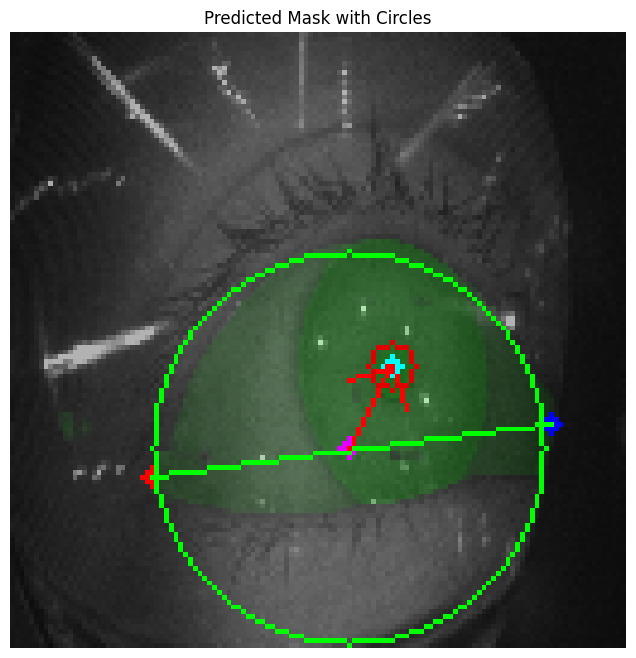

Time taken: 78.05126953125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(90))
Distance between Leftmost and Middle Point: 40
Error processing 5.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(108), np.int32(88))


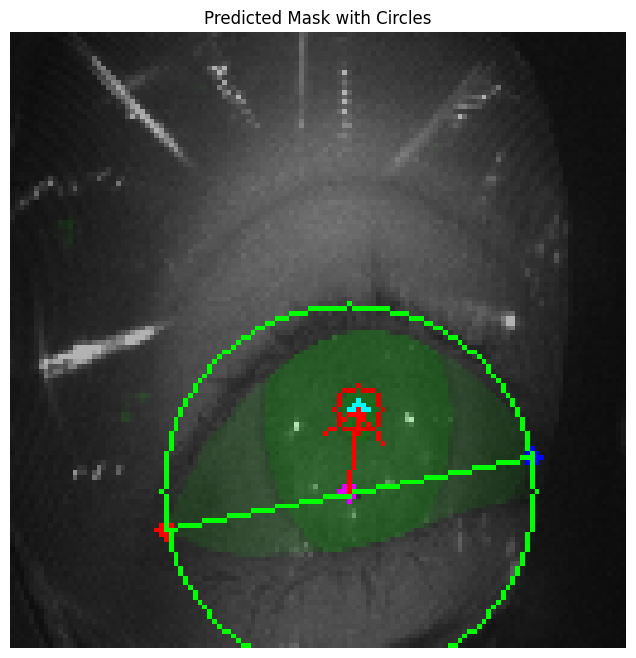

Time taken: 58.861328125 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 37
Error processing 50.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(93))
Rightmost Point: (np.int32(111), np.int32(85))


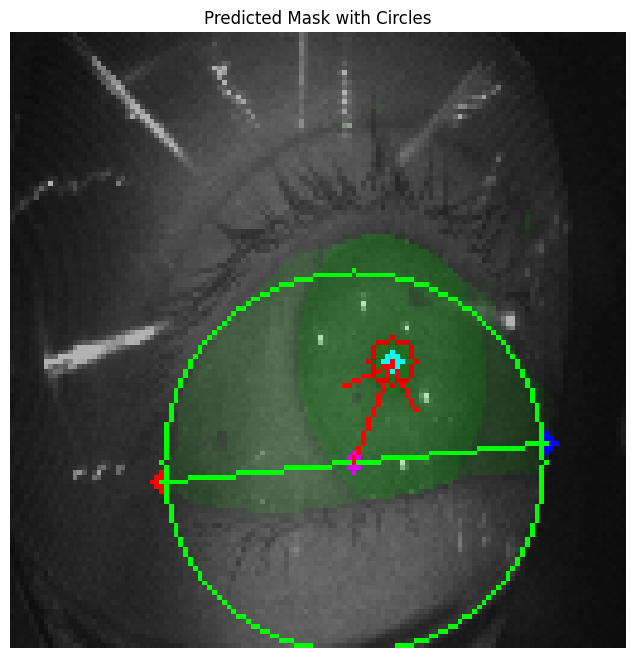

Time taken: 73.208251953125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(110), np.int32(90))
Distance between Leftmost and Middle Point: 40
Error processing 51.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(87))
Rightmost Point: (np.int32(112), np.int32(76))


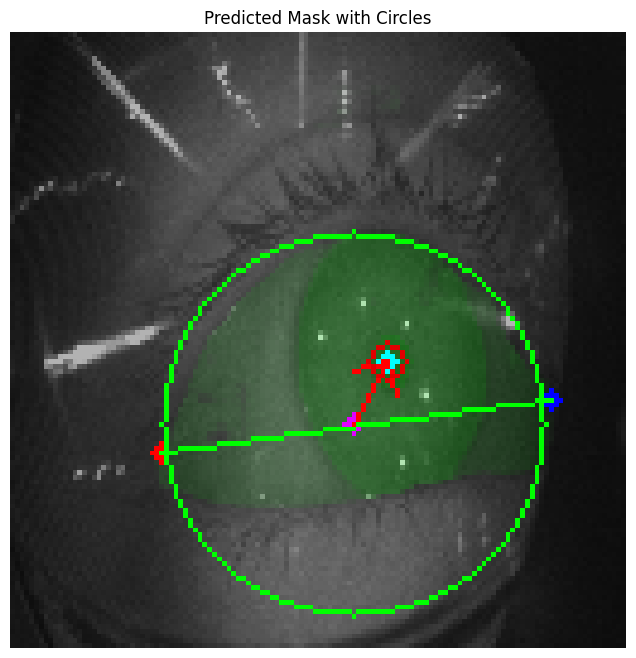

Time taken: 65.898193359375 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 39
Error processing 52.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(91))
Rightmost Point: (np.int32(111), np.int32(76))


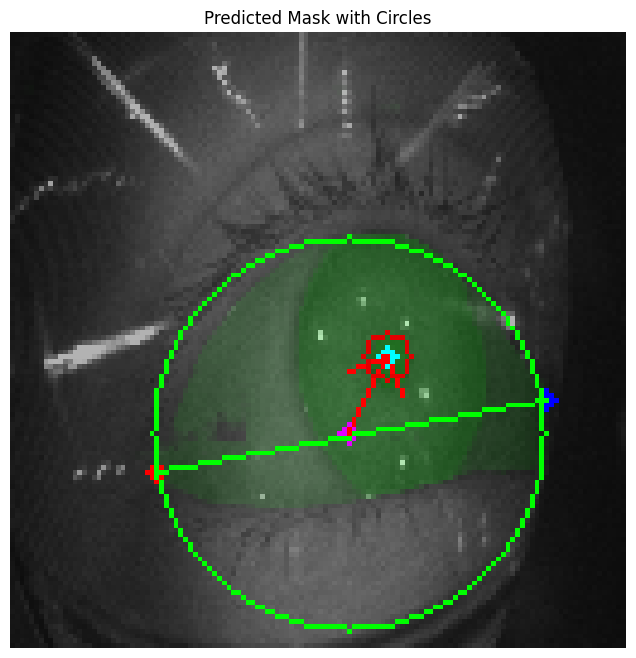

Time taken: 80.64990234375 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 39
Error processing 53.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(88))


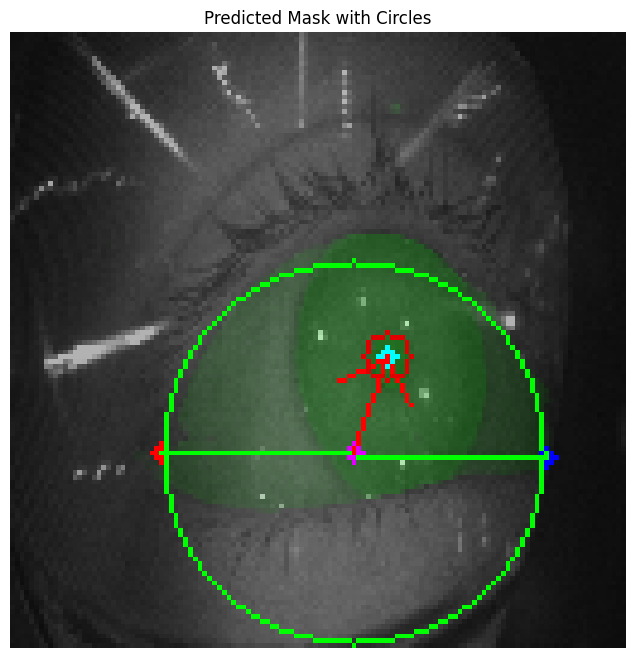

Time taken: 105.494384765625 ms
Iris radius: 4
Leftmost Point: (np.int32(28), np.int32(86))
Rightmost Point: (np.int32(111), np.int32(77))
Distance between Leftmost and Middle Point: 41
Error processing 54.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(85))


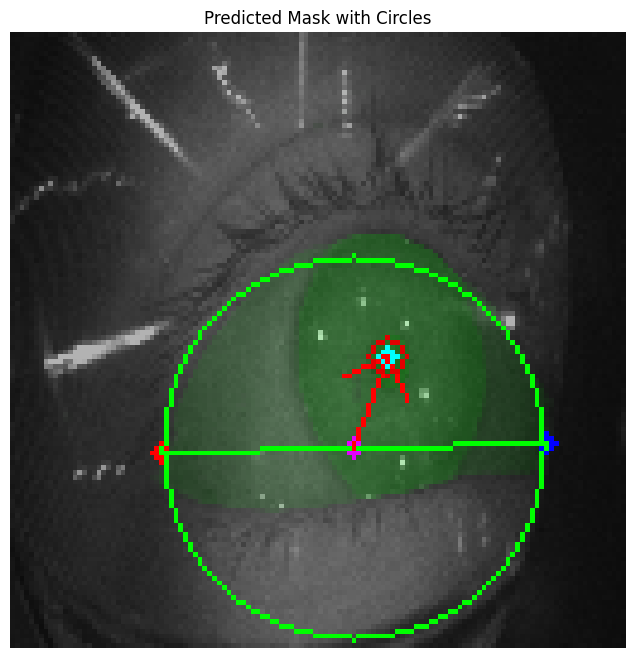

Time taken: 71.6240234375 ms
Iris radius: 4
Leftmost Point: (np.int32(28), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(78))
Distance between Leftmost and Middle Point: 41
Error processing 55.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(87))
Rightmost Point: (np.int32(110), np.int32(90))


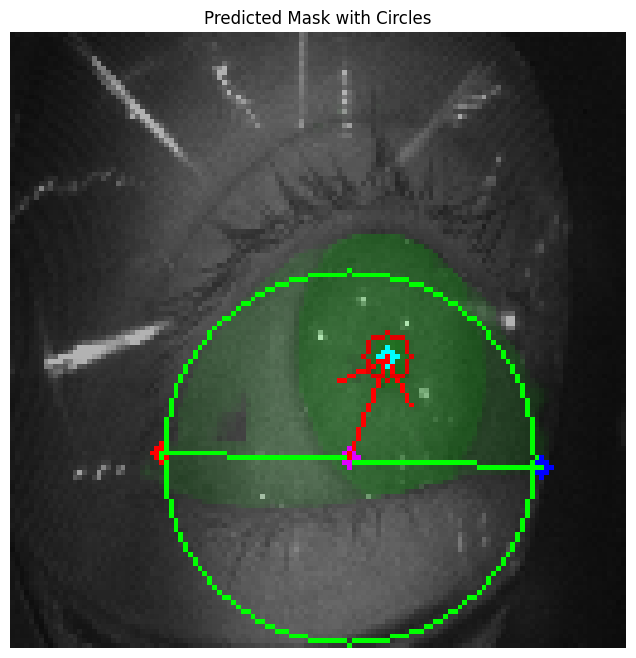

Time taken: 78.314697265625 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 39
Error processing 56.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(87))


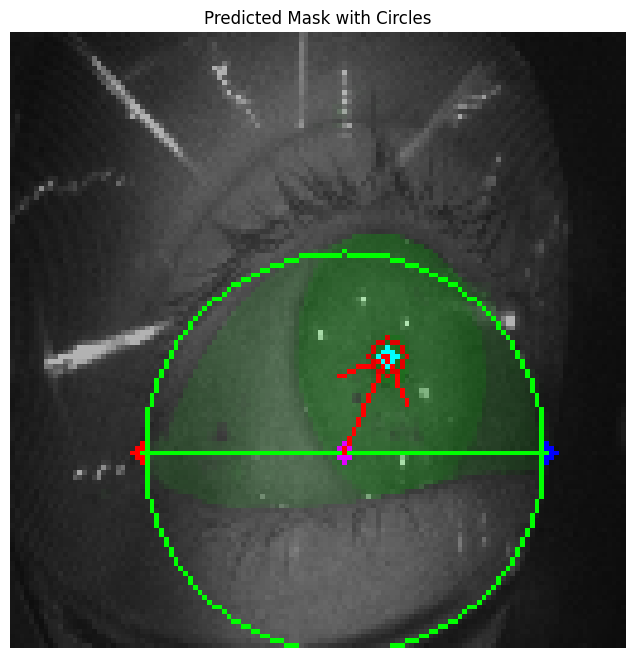

Time taken: 82.990234375 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(111), np.int32(87))
Distance between Leftmost and Middle Point: 40
Error processing 57.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(84))
Rightmost Point: (np.int32(111), np.int32(85))


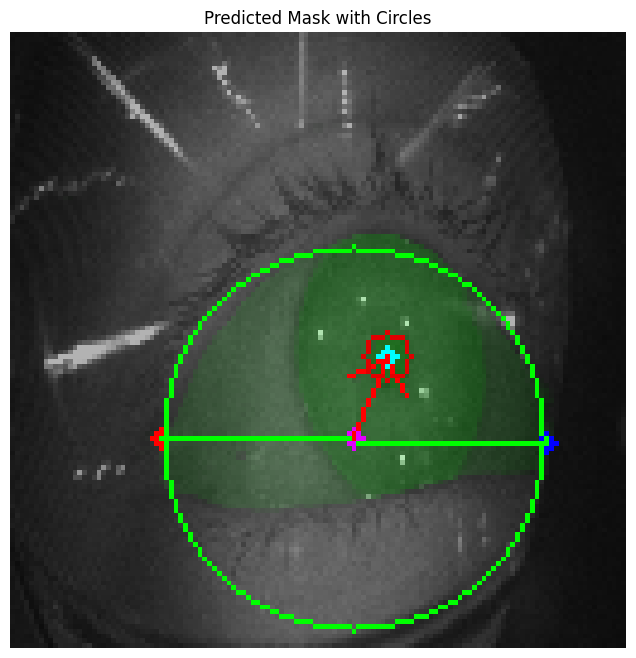

Time taken: 128.124755859375 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(89))
Rightmost Point: (np.int32(109), np.int32(90))
Distance between Leftmost and Middle Point: 39
Error processing 58.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(76))


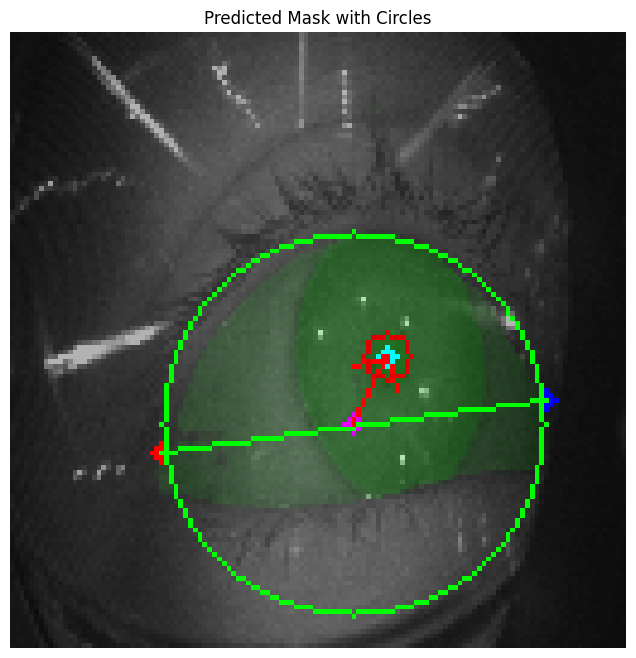

Time taken: 109.36669921875 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(84))
Distance between Leftmost and Middle Point: 39
Error processing 59.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(89))
Rightmost Point: (np.int32(110), np.int32(89))


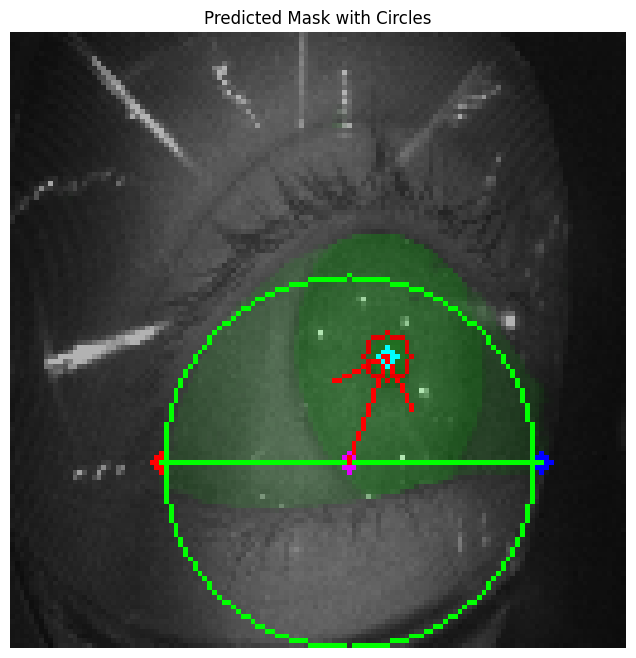

Time taken: 81.050048828125 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(89))
Distance between Leftmost and Middle Point: 39
Error processing 6.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(109), np.int32(88))


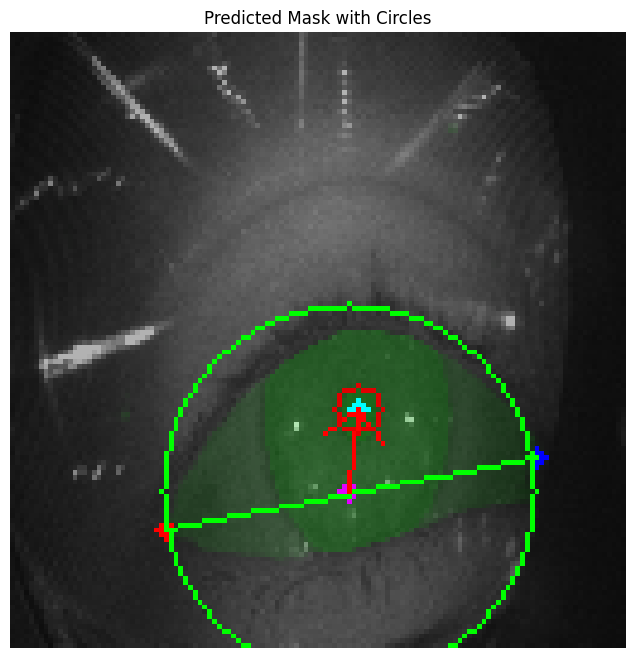

Time taken: 79.73046875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 38
Error processing 60.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(111), np.int32(76))


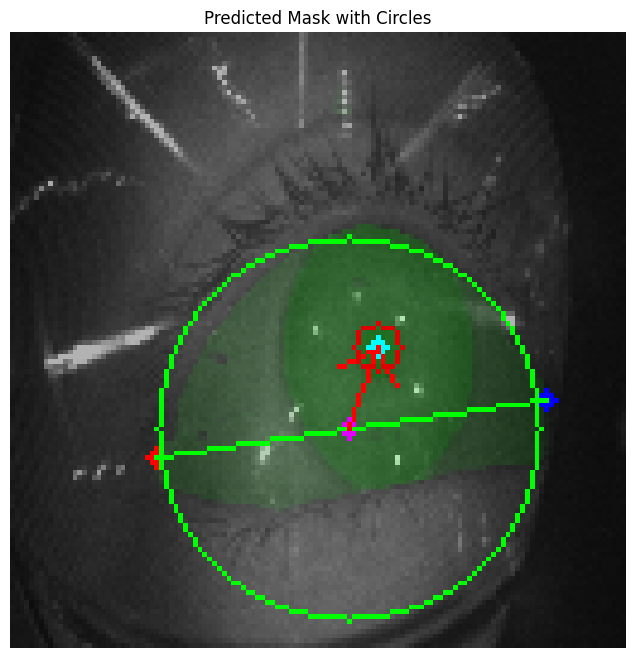

Time taken: 82.464111328125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(111), np.int32(80))
Distance between Leftmost and Middle Point: 40
Error processing 61.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(91))
Rightmost Point: (np.int32(112), np.int32(76))


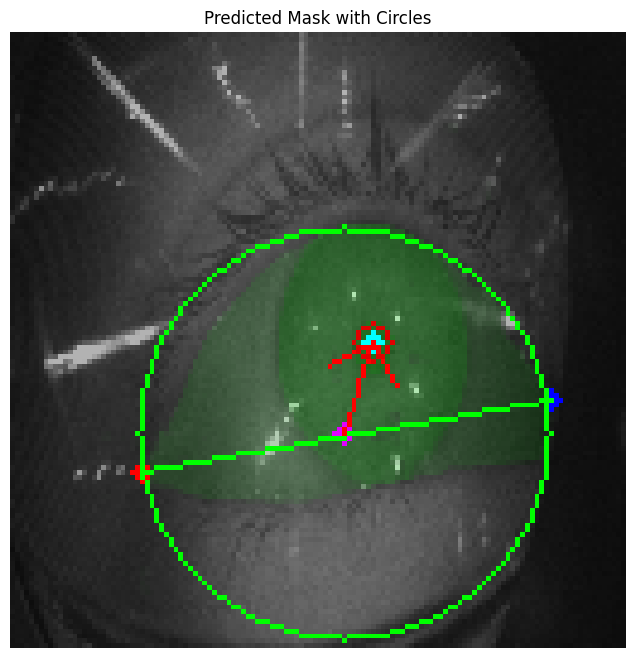

Time taken: 97.3369140625 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(86))
Rightmost Point: (np.int32(111), np.int32(85))
Distance between Leftmost and Middle Point: 40
Error processing 62.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(85))
Rightmost Point: (np.int32(111), np.int32(87))


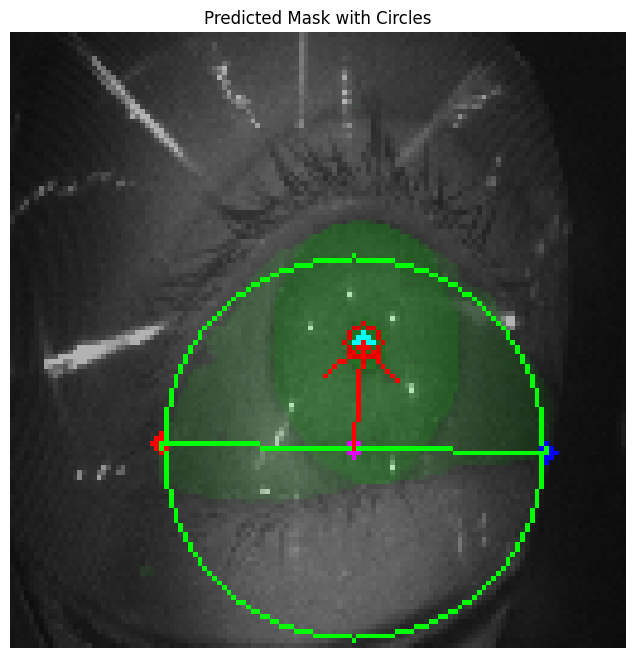

Time taken: 123.93603515625 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(87))
Distance between Leftmost and Middle Point: 40
Error processing 63.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(90))
Rightmost Point: (np.int32(111), np.int32(86))


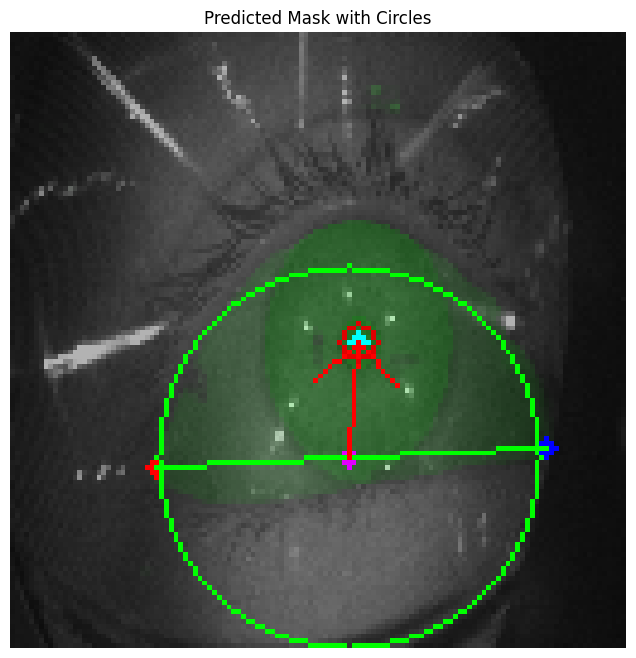

Time taken: 79.63671875 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 39
Error processing 64.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(85))


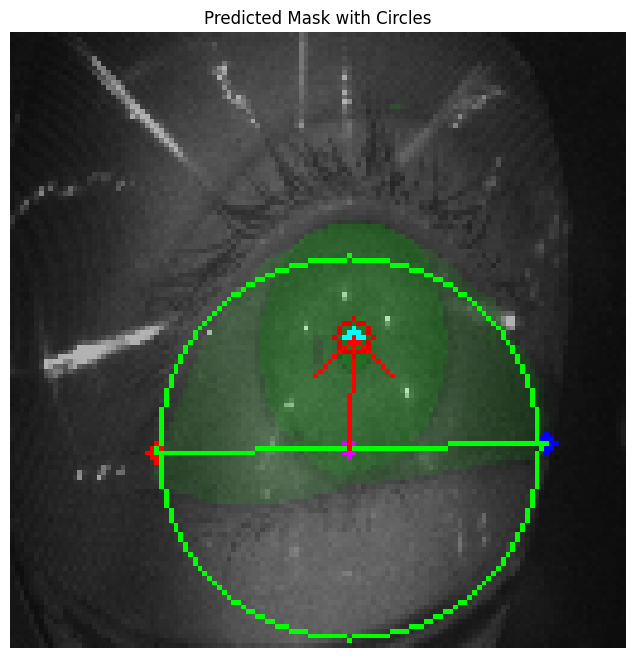

Time taken: 57.796875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(89))
Rightmost Point: (np.int32(110), np.int32(85))
Distance between Leftmost and Middle Point: 40
Error processing 65.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(88))
Rightmost Point: (np.int32(111), np.int32(85))


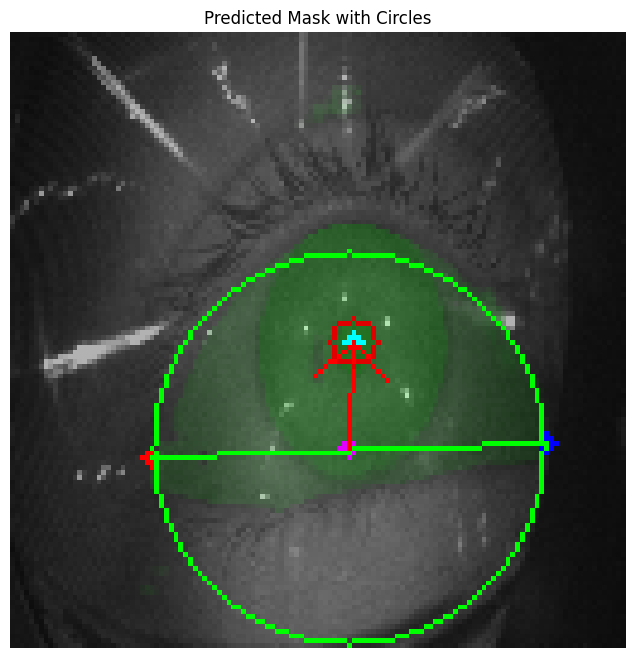

Time taken: 81.3349609375 ms
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(88))
Distance between Leftmost and Middle Point: 39
Error processing 66.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(85))


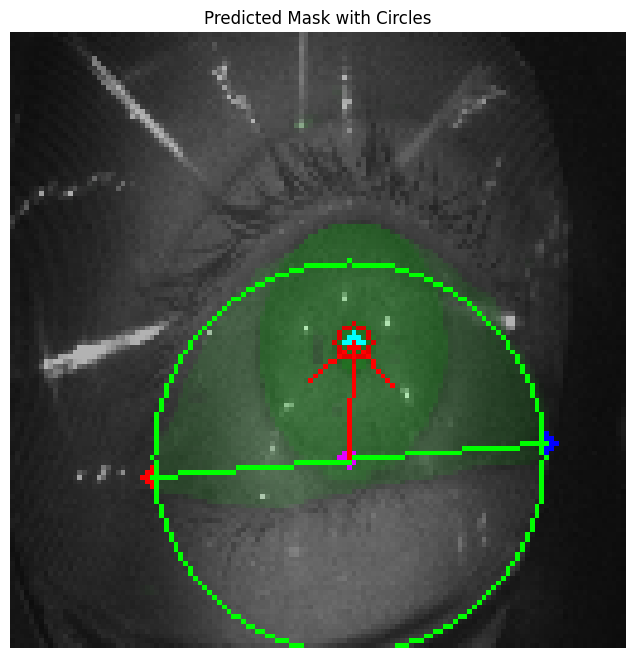

Time taken: 107.765625 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(89))
Rightmost Point: (np.int32(110), np.int32(88))
Distance between Leftmost and Middle Point: 40
Error processing 67.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(91))
Rightmost Point: (np.int32(111), np.int32(85))


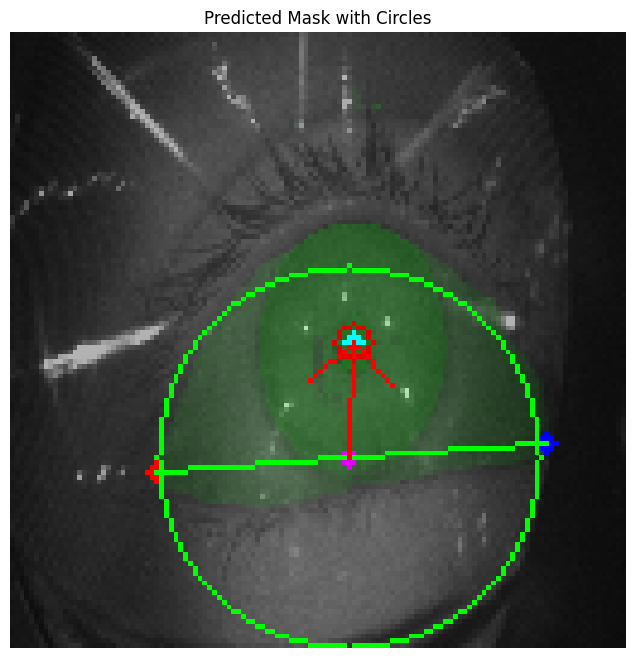

Time taken: 84.994873046875 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(88))
Rightmost Point: (np.int32(110), np.int32(86))
Distance between Leftmost and Middle Point: 40
Error processing 68.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(91))
Rightmost Point: (np.int32(111), np.int32(87))


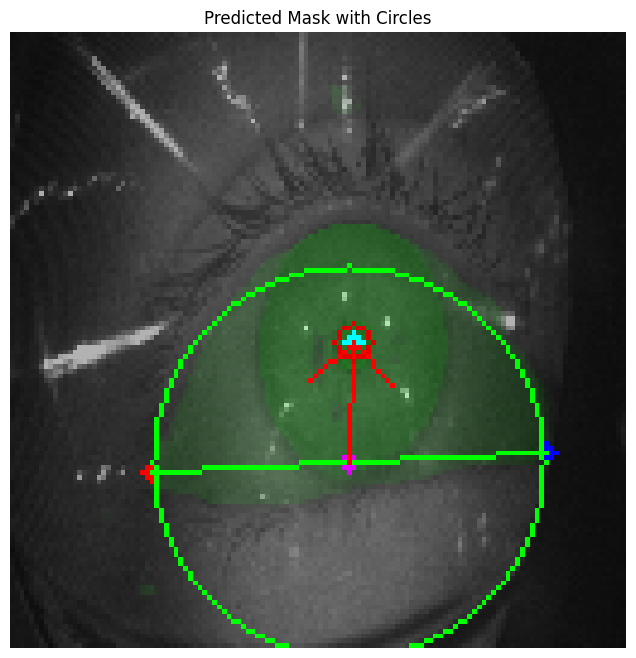

Time taken: 161.3125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(86))
Distance between Leftmost and Middle Point: 40
Error processing 69.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(85))


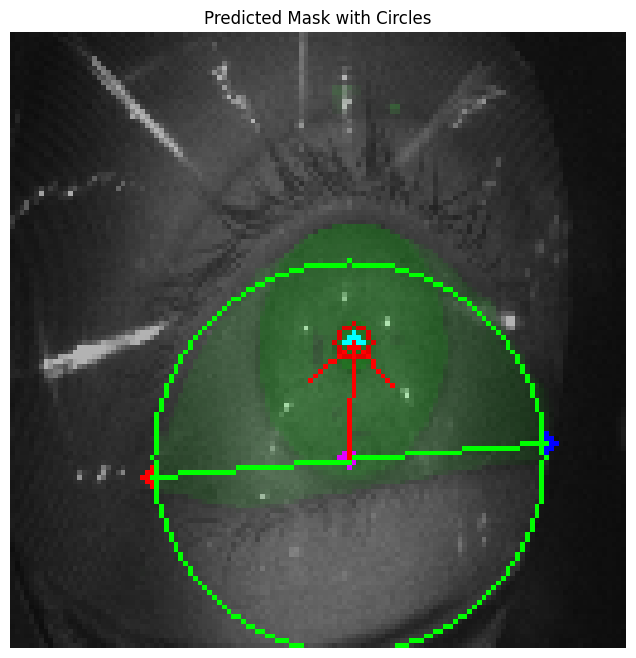

Time taken: 58.2099609375 ms
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(91))
Rightmost Point: (np.int32(111), np.int32(86))
Distance between Leftmost and Middle Point: 41
Error processing 7.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(96))


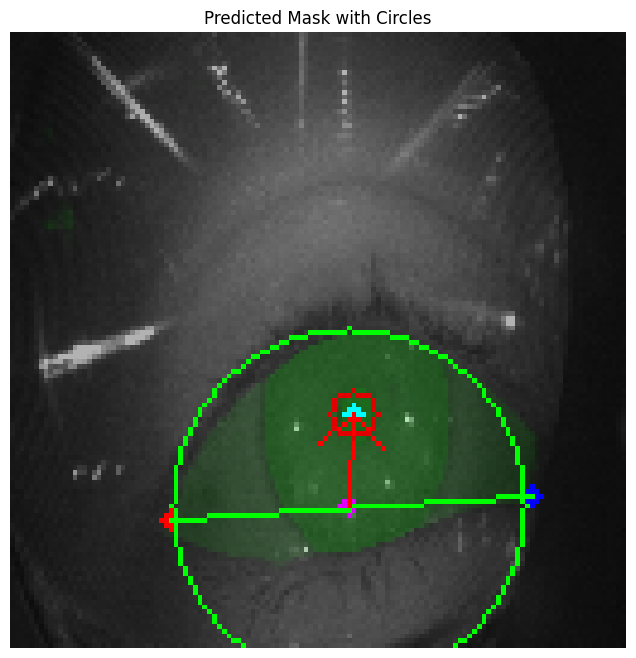

Time taken: 125.01904296875 ms
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(95))
Distance between Leftmost and Middle Point: 38
Error processing 70.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(86))
Rightmost Point: (np.int32(111), np.int32(85))


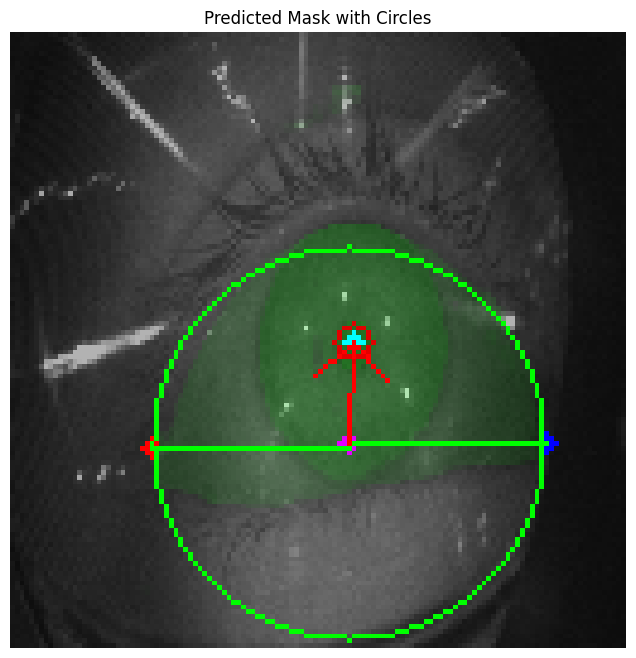

Time taken: 76.14453125 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(86))
Distance between Leftmost and Middle Point: 40
Error processing 71.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(88))
Rightmost Point: (np.int32(109), np.int32(87))


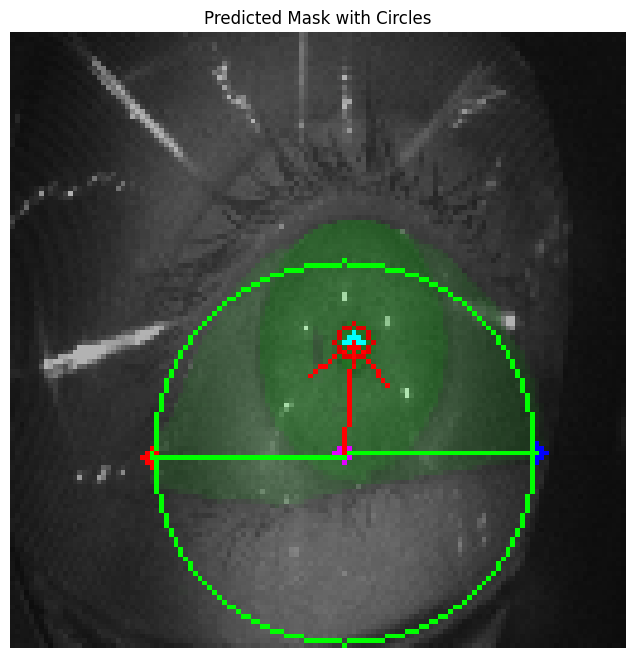

Time taken: 90.844970703125 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(85))
Rightmost Point: (np.int32(110), np.int32(87))
Distance between Leftmost and Middle Point: 40
Error processing 72.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(91))
Rightmost Point: (np.int32(111), np.int32(84))


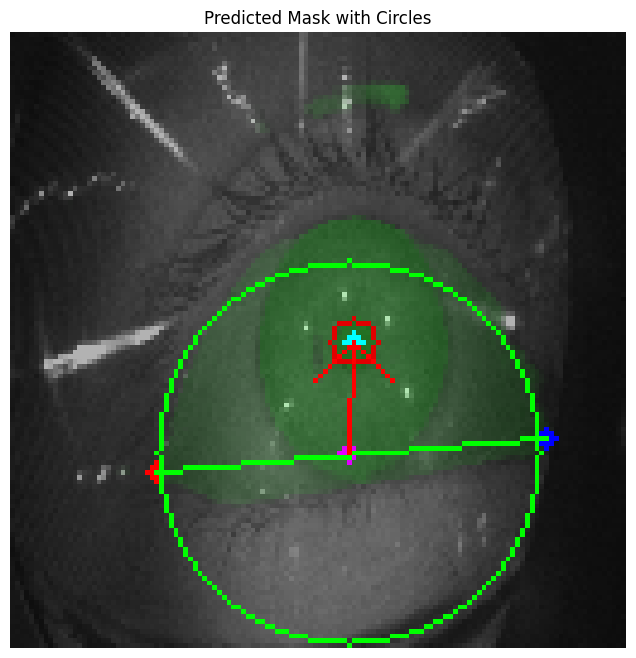

Time taken: 108.44189453125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(109), np.int32(87))
Distance between Leftmost and Middle Point: 39
Error processing 73.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(88))
Rightmost Point: (np.int32(111), np.int32(85))


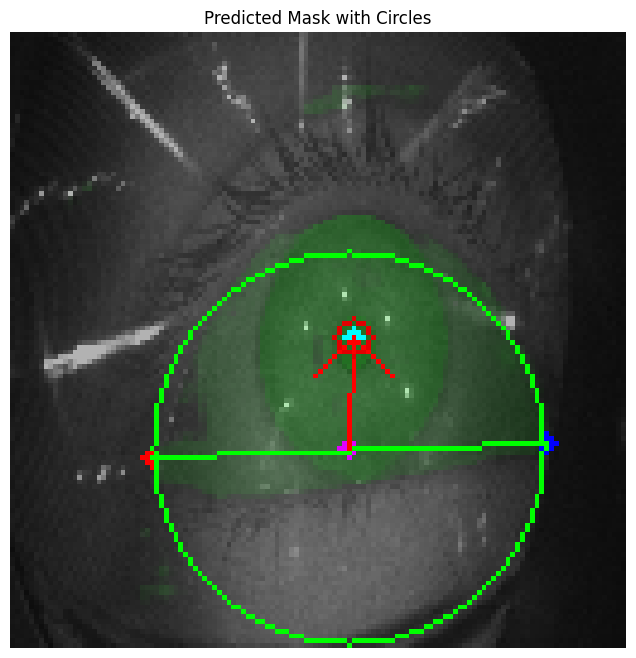

Time taken: 115.553955078125 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(86))
Rightmost Point: (np.int32(110), np.int32(85))
Distance between Leftmost and Middle Point: 40
Error processing 74.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
No iris contours found.
Error processing 74.png: cannot unpack non-iterable NoneType object
Error processing 75.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(85))


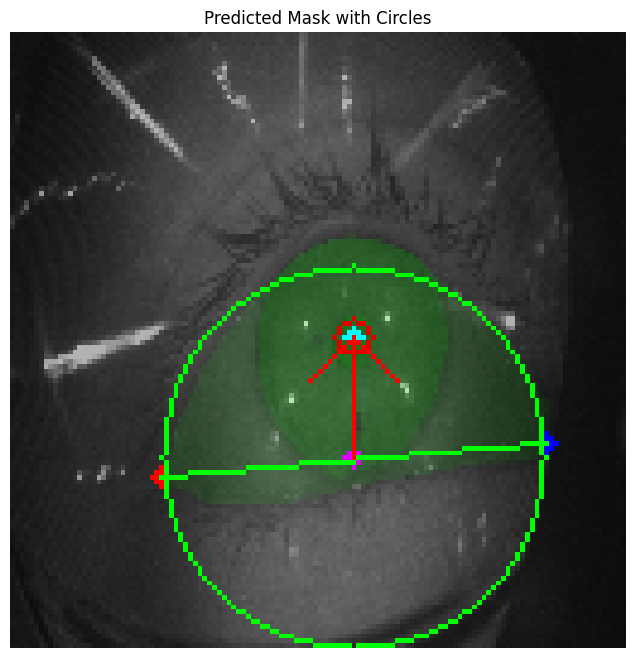

Time taken: 62.765625 ms
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(91))
Rightmost Point: (np.int32(111), np.int32(87))
Distance between Leftmost and Middle Point: 40
Error processing 76.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(93))
Rightmost Point: (np.int32(111), np.int32(85))


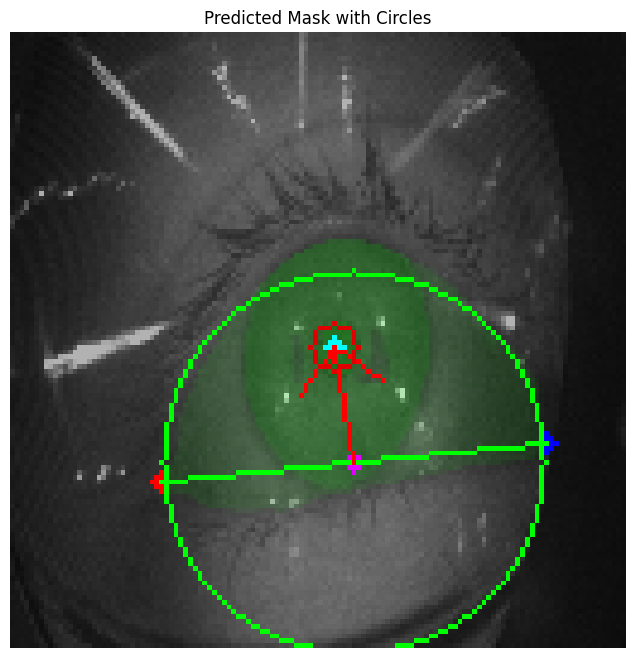

Time taken: 78.742919921875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(109), np.int32(86))
Distance between Leftmost and Middle Point: 39
Error processing 77.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(87))
Rightmost Point: (np.int32(112), np.int32(81))


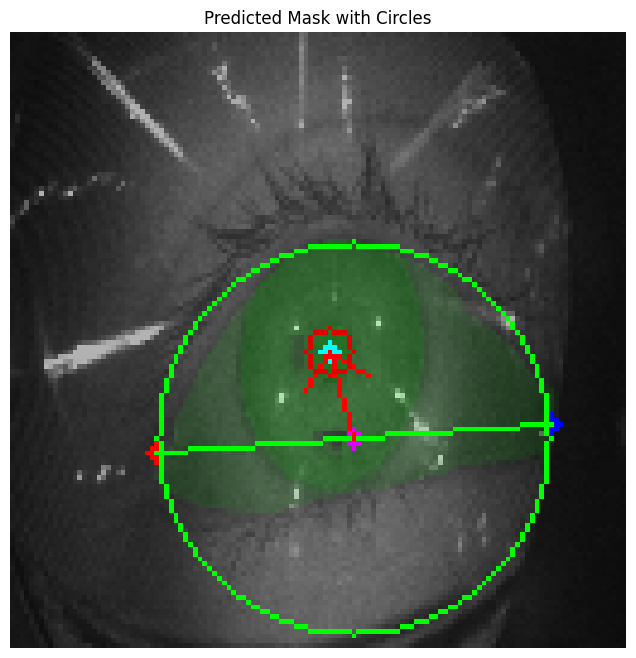

Time taken: 63.864990234375 ms
Iris radius: 5
Leftmost Point: (np.int32(27), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(85))
Distance between Leftmost and Middle Point: 41
Error processing 78.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(93))
Rightmost Point: (np.int32(110), np.int32(76))


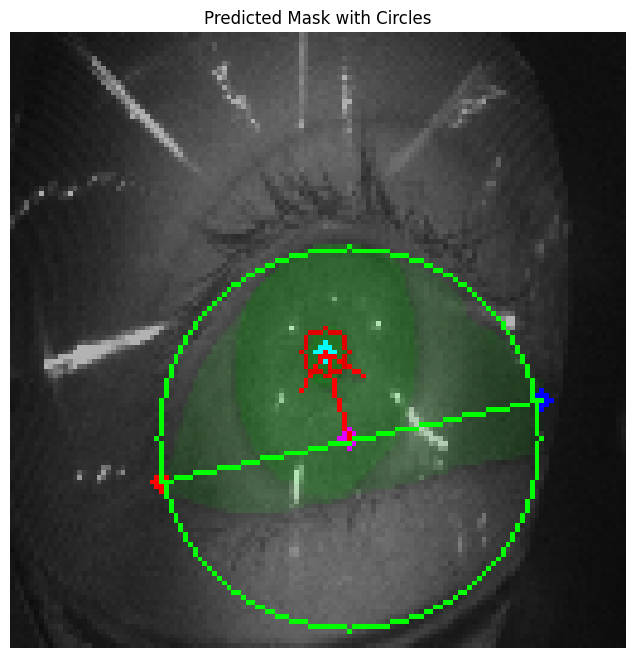

Time taken: 88.89697265625 ms
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(90))
Rightmost Point: (np.int32(109), np.int32(85))
Distance between Leftmost and Middle Point: 40
Error processing 79.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(93))
Rightmost Point: (np.int32(109), np.int32(77))


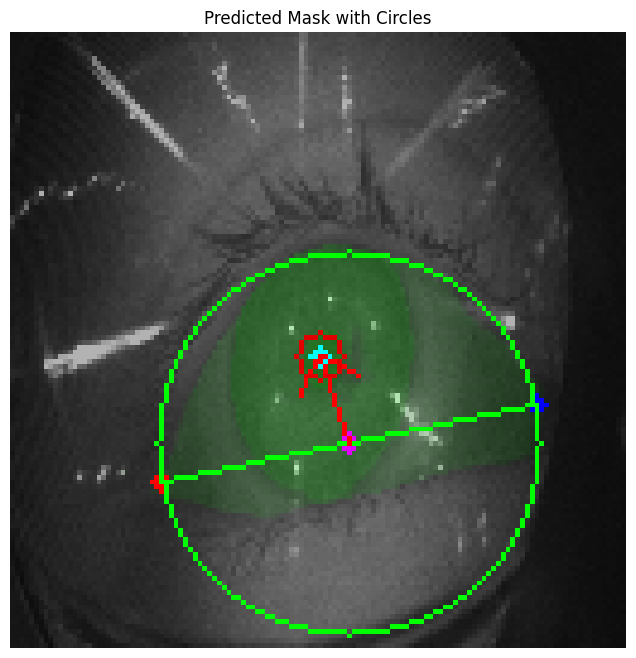

Time taken: 77.705810546875 ms
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(77))
Distance between Leftmost and Middle Point: 42
Error processing 8.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(104))
Rightmost Point: (np.int32(108), np.int32(97))


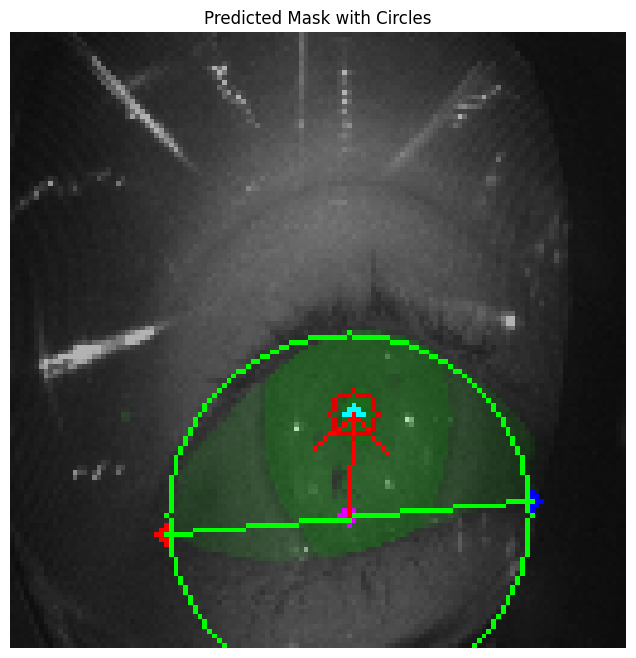

Time taken: 99.4853515625 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(94))
Distance between Leftmost and Middle Point: 37
Error processing 80.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(95))
Rightmost Point: (np.int32(109), np.int32(85))


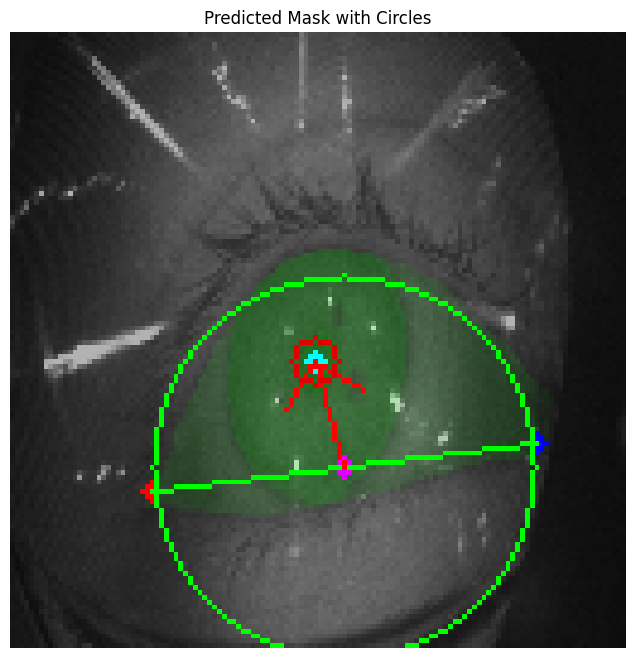

Time taken: 77.4326171875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(94))
Rightmost Point: (np.int32(109), np.int32(81))
Distance between Leftmost and Middle Point: 40
Error processing 81.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(93))
Rightmost Point: (np.int32(110), np.int32(77))


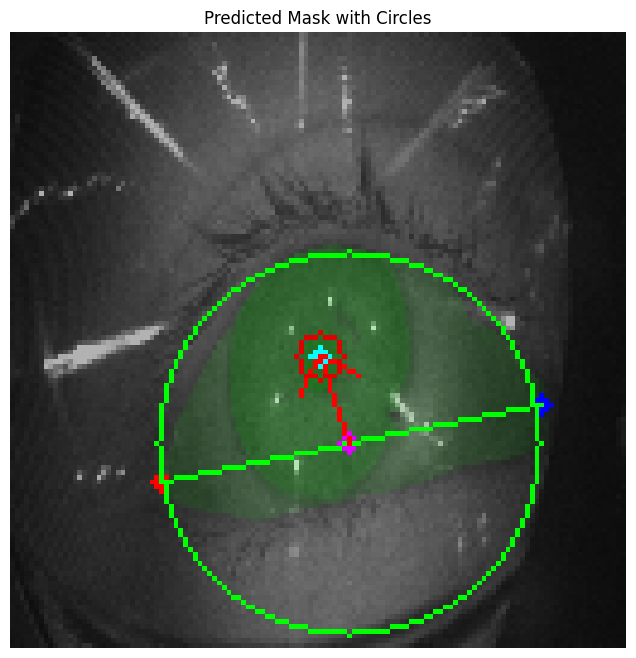

Time taken: 70.472900390625 ms
Iris radius: 5
Leftmost Point: (np.int32(28), np.int32(89))
Rightmost Point: (np.int32(107), np.int32(86))
Distance between Leftmost and Middle Point: 39
Error processing 82.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(87))
Rightmost Point: (np.int32(111), np.int32(76))


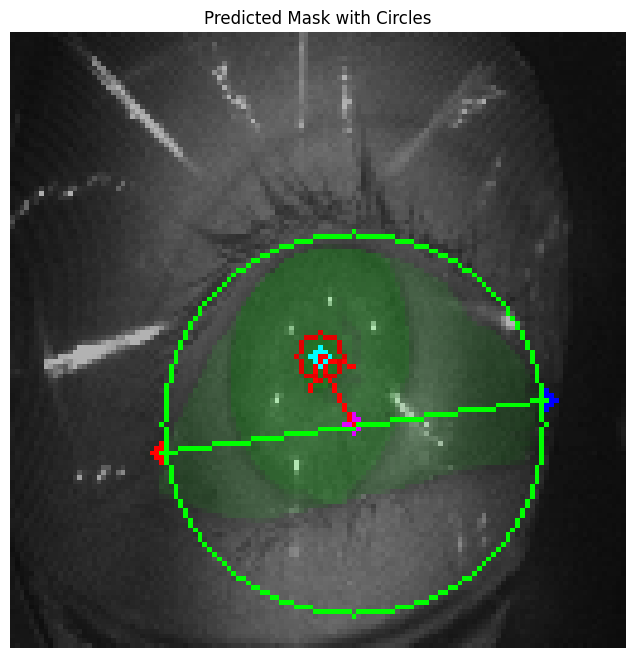

Time taken: 65.190185546875 ms
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(93))
Rightmost Point: (np.int32(109), np.int32(77))
Distance between Leftmost and Middle Point: 41
Error processing 83.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(86))
Rightmost Point: (np.int32(108), np.int32(76))


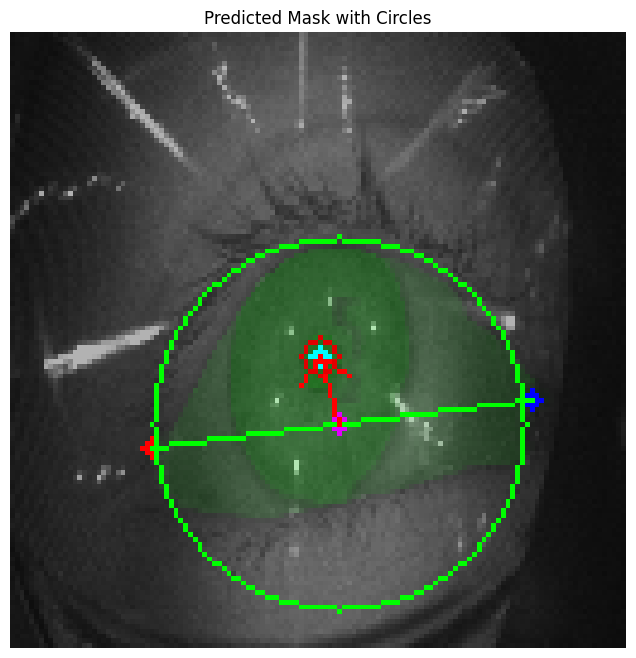

Time taken: 69.7568359375 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(109), np.int32(78))
Distance between Leftmost and Middle Point: 40
Error processing 84.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(94))
Rightmost Point: (np.int32(110), np.int32(85))


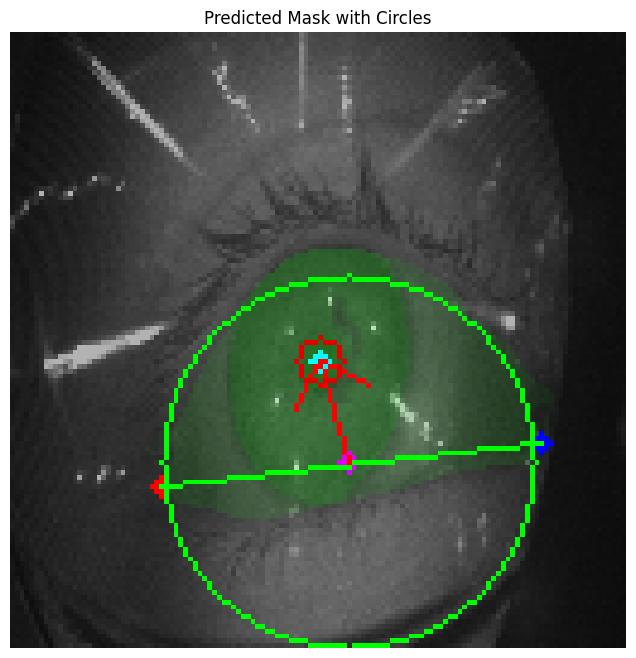

Time taken: 66.431640625 ms
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 39
Error processing 85.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Iris radius: 5
Leftmost Point: (np.int32(32), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(84))


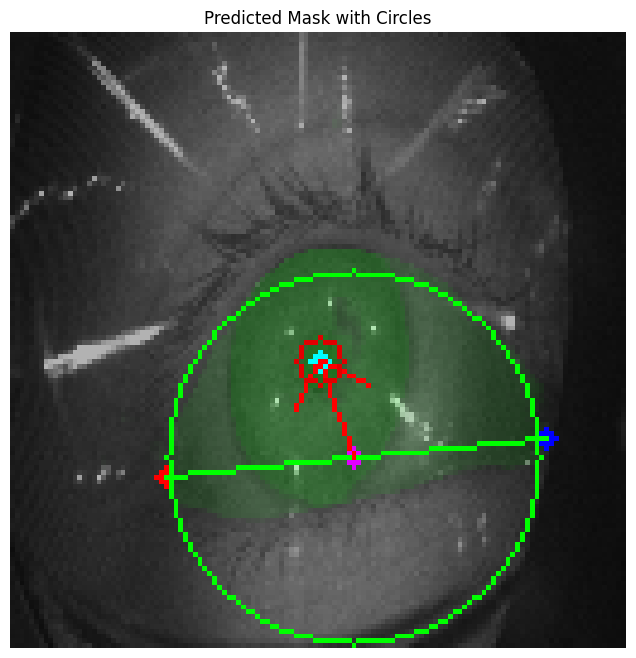

Time taken: 80.303955078125 ms
Iris radius: 5
Leftmost Point: (np.int32(28), np.int32(90))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 40
Error processing 86.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(93))
Rightmost Point: (np.int32(112), np.int32(76))


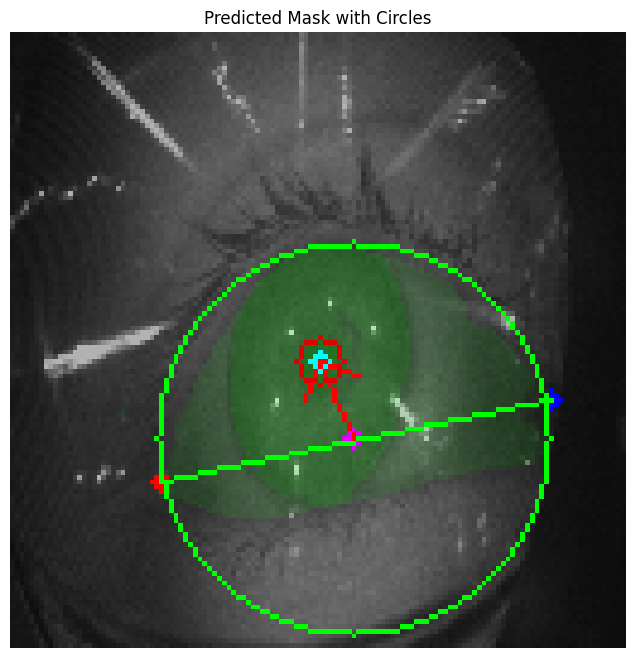

Time taken: 81.3447265625 ms
Iris radius: 5
Leftmost Point: (np.int32(28), np.int32(90))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 40
Error processing 87.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Iris radius: 5
Leftmost Point: (np.int32(31), np.int32(93))
Rightmost Point: (np.int32(109), np.int32(81))


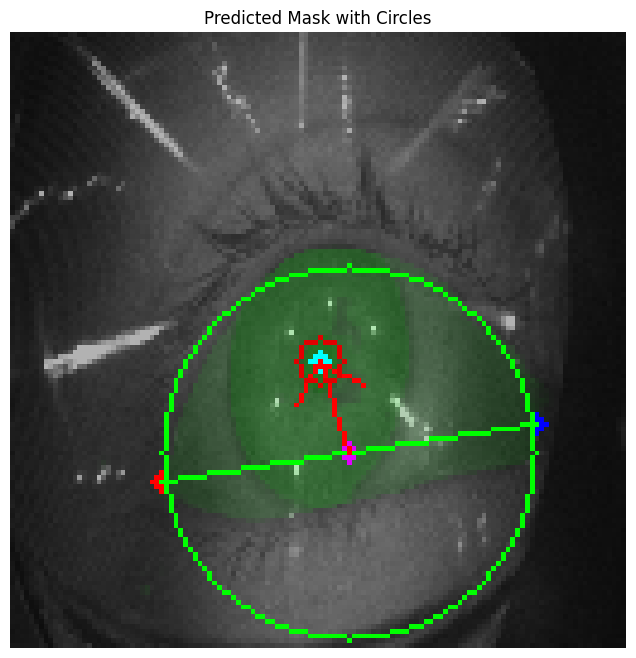

Time taken: 99.252685546875 ms
Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(92))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 39
Error processing 88.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(93))
Rightmost Point: (np.int32(109), np.int32(75))


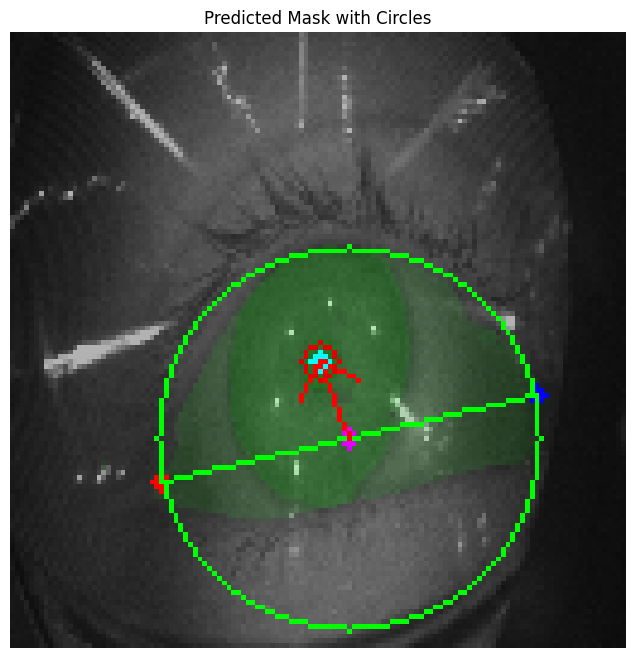

Time taken: 79.135498046875 ms
Iris radius: 5
Leftmost Point: (np.int32(29), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(78))
Distance between Leftmost and Middle Point: 42
Error processing 89.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Iris radius: 4
Leftmost Point: (np.int32(30), np.int32(95))
Rightmost Point: (np.int32(111), np.int32(76))


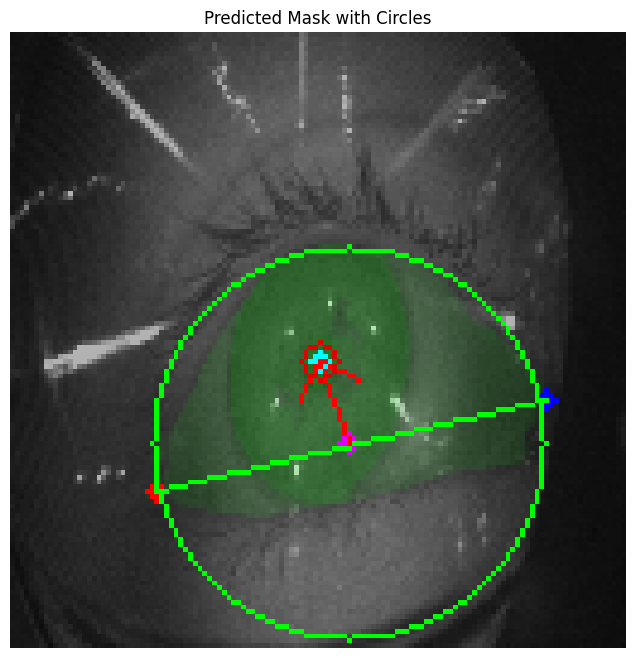

Time taken: 68.0771484375 ms
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(91))
Rightmost Point: (np.int32(108), np.int32(88))
Distance between Leftmost and Middle Point: 40
Error processing 9.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(103))
Rightmost Point: (np.int32(109), np.int32(87))


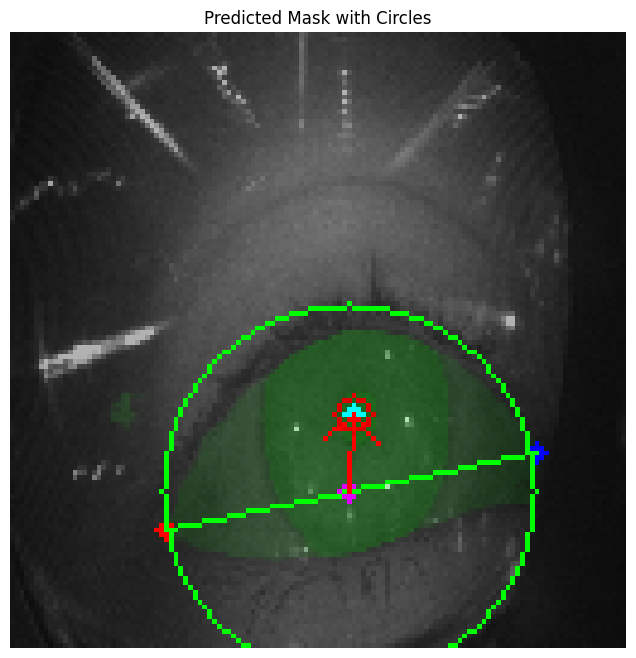

Time taken: 81.935302734375 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(93))
Distance between Leftmost and Middle Point: 37
Error processing 90.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(76))


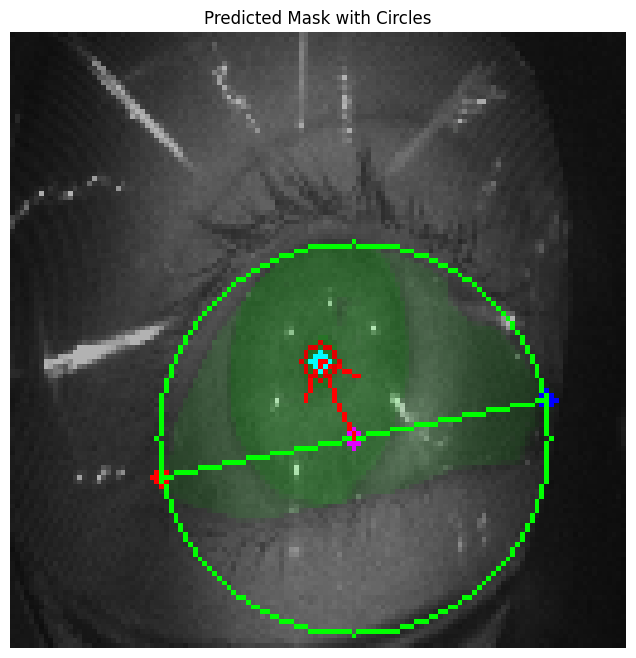

Time taken: 81.578369140625 ms
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(92))
Rightmost Point: (np.int32(108), np.int32(86))
Distance between Leftmost and Middle Point: 40
Error processing 91.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(95))
Rightmost Point: (np.int32(110), np.int32(72))


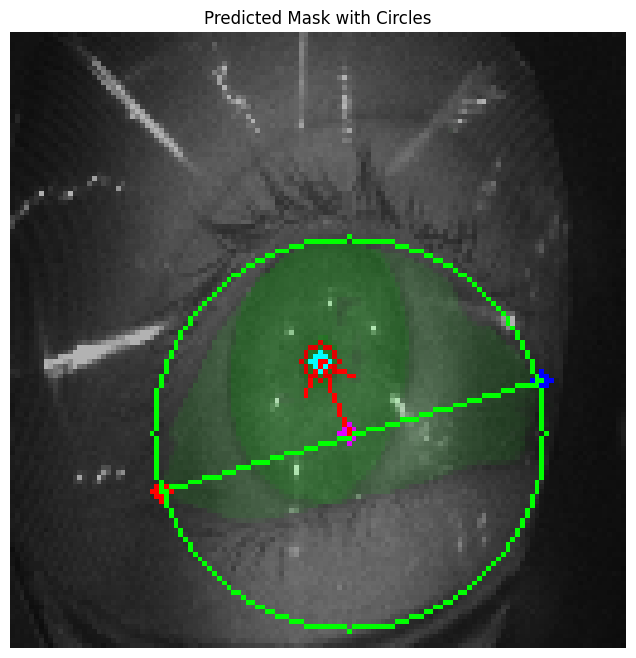

Time taken: 78.55078125 ms
Iris radius: 4
Leftmost Point: (np.int32(26), np.int32(91))
Rightmost Point: (np.int32(109), np.int32(85))
Distance between Leftmost and Middle Point: 41
Error processing 92.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(95))
Rightmost Point: (np.int32(111), np.int32(74))


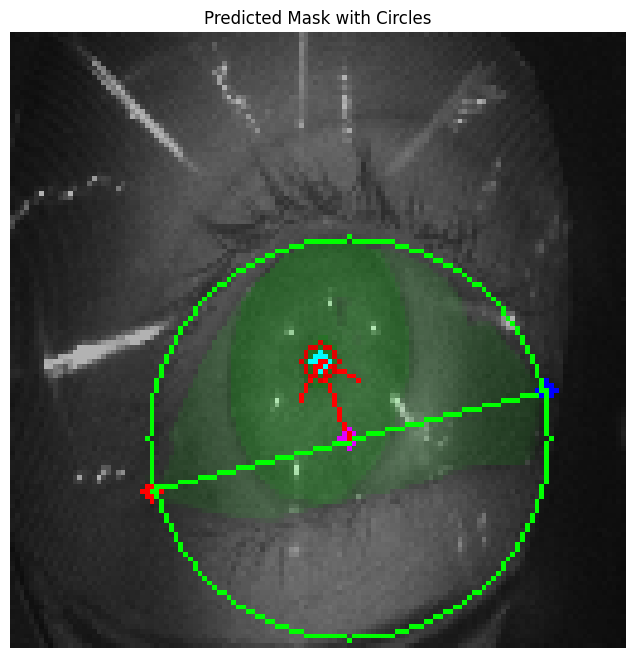

Time taken: 105.066162109375 ms
Iris radius: 4
Leftmost Point: (np.int32(27), np.int32(89))
Rightmost Point: (np.int32(109), np.int32(86))
Distance between Leftmost and Middle Point: 41
Error processing 93.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Iris radius: 4
Leftmost Point: (np.int32(29), np.int32(95))
Rightmost Point: (np.int32(111), np.int32(80))


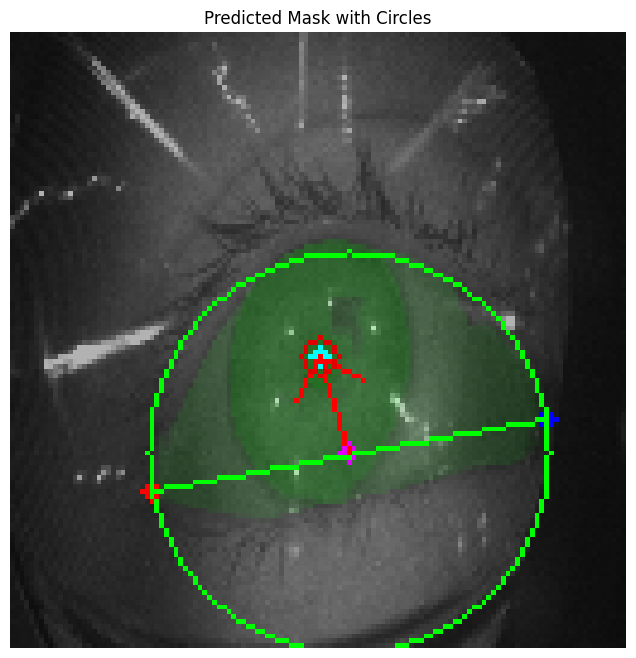

Time taken: 75.41552734375 ms
Iris radius: 4
Leftmost Point: (np.int32(28), np.int32(90))
Rightmost Point: (np.int32(110), np.int32(77))
Distance between Leftmost and Middle Point: 42
Error processing 94.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Iris radius: 4
Leftmost Point: (np.int32(31), np.int32(92))
Rightmost Point: (np.int32(111), np.int32(74))


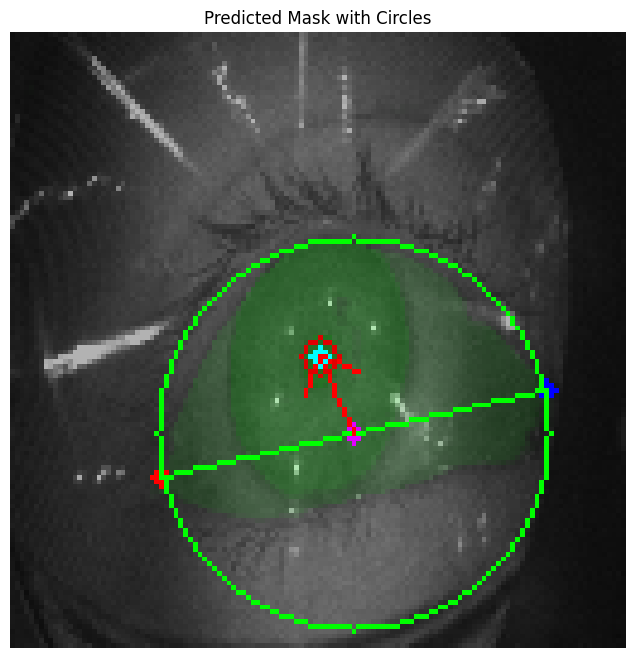

Time taken: 101.519775390625 ms
Iris radius: 4
Leftmost Point: (np.int32(26), np.int32(91))
Rightmost Point: (np.int32(108), np.int32(87))
Distance between Leftmost and Middle Point: 41
Error processing 95.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Iris radius: 3
Leftmost Point: (np.int32(36), np.int32(97))
Rightmost Point: (np.int32(109), np.int32(87))


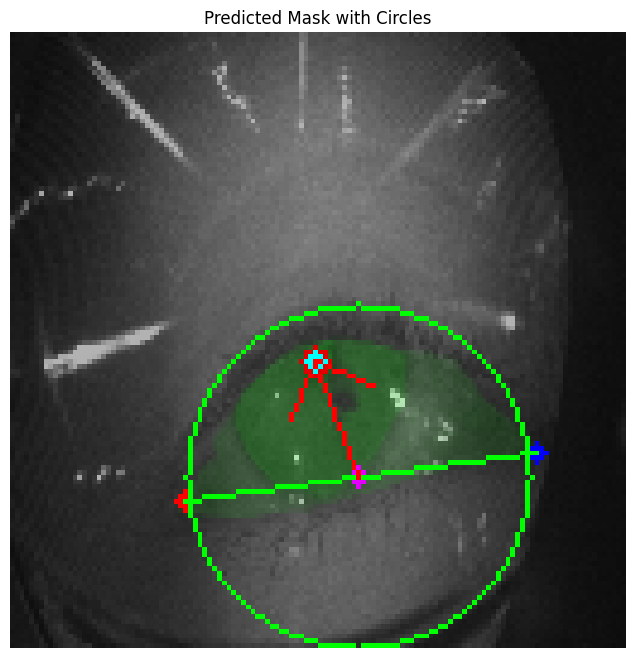

Time taken: 73.884765625 ms
Iris radius: 4
Leftmost Point: (np.int32(35), np.int32(98))
Rightmost Point: (np.int32(109), np.int32(86))
Distance between Leftmost and Middle Point: 37
Error processing 96.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 2
Leftmost Point: (np.int32(34), np.int32(96))
Rightmost Point: (np.int32(110), np.int32(89))


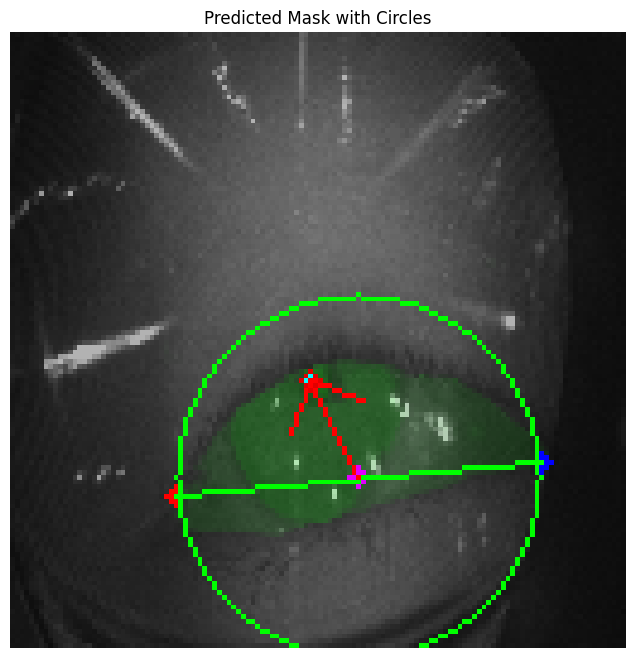

Time taken: 104.333740234375 ms
Iris radius: 3
Leftmost Point: (np.int32(34), np.int32(101))
Rightmost Point: (np.int32(108), np.int32(89))
Distance between Leftmost and Middle Point: 37
Error processing 97.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(96))
Rightmost Point: (np.int32(108), np.int32(89))


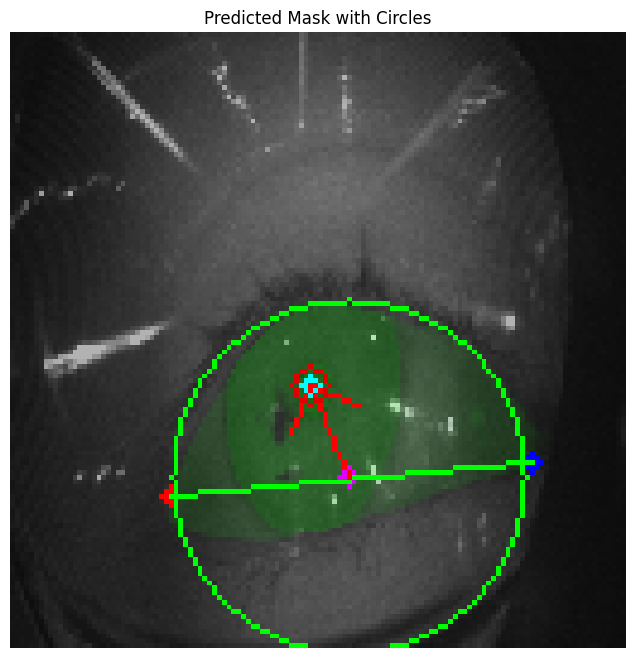

Time taken: 139.07470703125 ms
Iris radius: 5
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(85))
Distance between Leftmost and Middle Point: 37
Error processing 98.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(97))
Rightmost Point: (np.int32(108), np.int32(90))


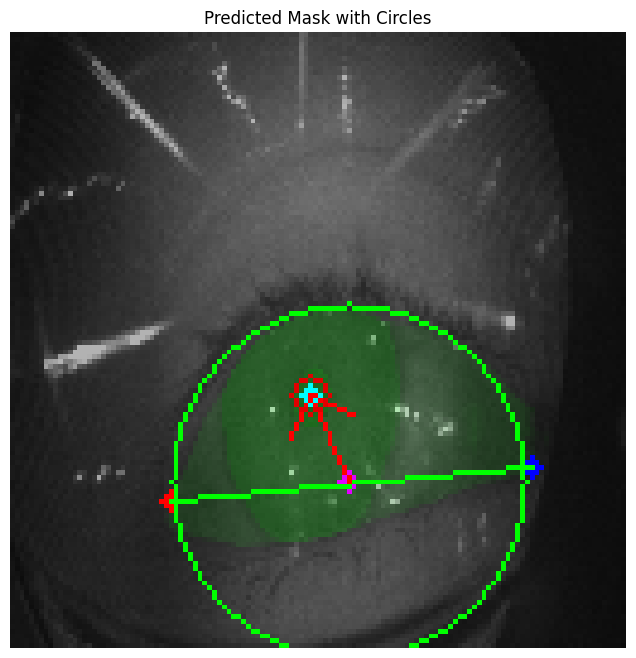

Time taken: 82.316650390625 ms
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(99))
Rightmost Point: (np.int32(109), np.int32(83))
Distance between Leftmost and Middle Point: 39
Error processing 99.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Iris radius: 4
Leftmost Point: (np.int32(32), np.int32(100))
Rightmost Point: (np.int32(108), np.int32(88))


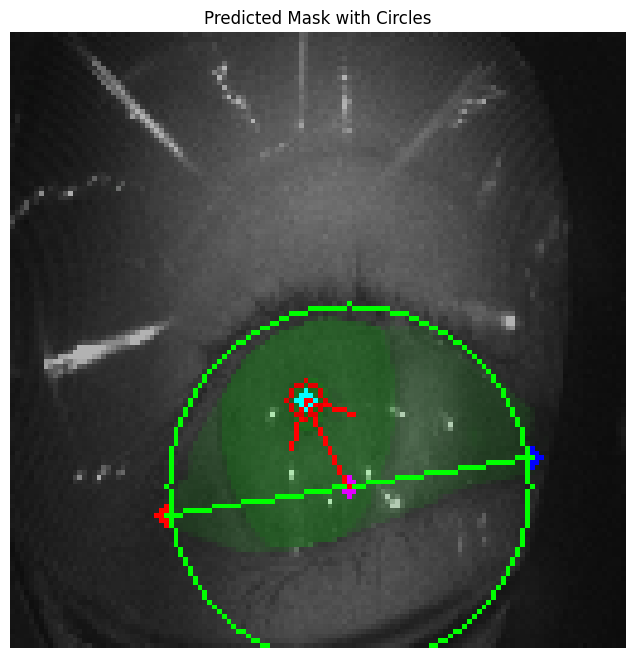

Time taken: 81.072998046875 ms
Iris radius: 4
Leftmost Point: (np.int32(33), np.int32(98))
Rightmost Point: (np.int32(106), np.int32(87))
Distance between Leftmost and Middle Point: 36
Error processing label_102.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error processing label_108.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error processing label_120.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error processing label_132.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error processing label_137.npy: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



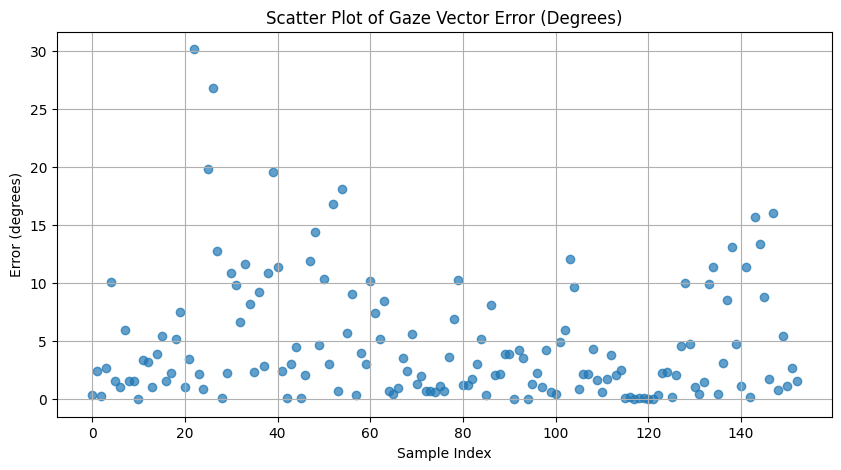

Mean error (degrees): 4.702889829966458


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

image_dir_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/S_0'
image_files = sorted(os.listdir(image_dir_path))

K = np.array([[600, 0, 320],
              [0, 600, 240],
              [0,   0,   1]])

def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
# model = load_model('light_weight_unet_gaze_estimation_model.h5', custom_objects={'dice_loss': dice_loss})
model = load_model('light_weight_unet_gaze_estimation_model_2.h5', custom_objects={'dice_loss': dice_loss})
model_2 = load_model('light_weight_unet_gaze_estimation_model.h5', custom_objects={'dice_loss': dice_loss})


gaze_vectors_predict = []
gaze_vectors_actual = []
image_nums = []

for image_file in image_files:
    image_num = image_file.split('.')[0]
    image_path = os.path.join(image_dir_path, image_file)
    label_path = os.path.join(image_dir_path, f"{image_num}.npy")
    try:
        iris_center_predict, middle_point_vector_predict = calculate_gaze_vector_image(image_path, model_2, resize=True, debug=True)
        iris_center_actual, middle_point_vector_actual = calculate_gaze_vector_from_lable_img(label_path)
        gaze_vector_predict = calculate_gaze_vector(iris_center_predict, middle_point_vector_predict, K)
        gaze_vector_actual = calculate_gaze_vector(iris_center_actual, middle_point_vector_actual, K)
        gaze_vectors_predict.append(gaze_vector_predict)
        gaze_vectors_actual.append(gaze_vector_actual)
        image_nums.append(image_num)
    except Exception as e:
        print(f"Error processing {image_file}: {e}")

gaze_vectors_predict = np.array(gaze_vectors_predict)
gaze_vectors_actual = np.array(gaze_vectors_actual)
image_nums = np.array(image_nums)

# Calculate error degree (angle between predicted and actual gaze vectors)
cos_sim = np.sum(gaze_vectors_predict * gaze_vectors_actual, axis=1) / (
    np.linalg.norm(gaze_vectors_predict, axis=1) * np.linalg.norm(gaze_vectors_actual, axis=1) + 1e-8)
cos_sim = np.clip(cos_sim, -1.0, 1.0)
error_degrees = np.degrees(np.arccos(cos_sim))

print("Mean error (degrees):", np.mean(error_degrees))

plt.figure(figsize=(10, 5))
plt.scatter(range(len(error_degrees)), error_degrees, alpha=1, label='Error (degrees)')
plt.axhline(np.mean(error_degrees), color='red', linestyle='--', label='Mean Error')
plt.xlabel('Sample Index')
plt.ylabel('Error (degrees)')
plt.title('Scatter Plot of Gaze Vector Error (Degrees)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_141667/2324413134.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


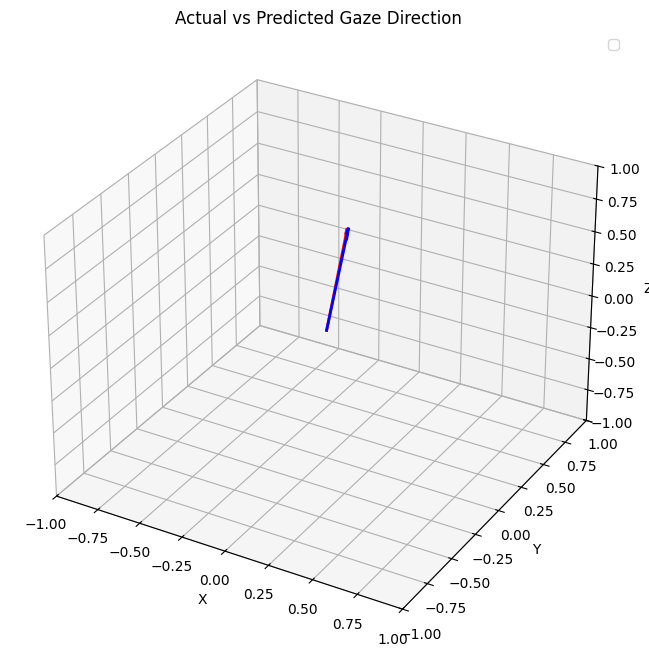

In [37]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

index = 100

ax.quiver(0, 0, 0,
        gaze_vectors_actual[index,0], gaze_vectors_actual[index,1], gaze_vectors_actual[index,2],
        color=(1, 0, 0), linewidth=2, arrow_length_ratio=0.1)


ax.quiver(0, 0, 0,
        gaze_vectors_predict[index,0], gaze_vectors_predict[index,1], gaze_vectors_predict[index,2],
        color=(0, 0, 1), linewidth=2, arrow_length_ratio=0.1)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Actual vs Predicted Gaze Direction')
ax.legend()
plt.show()

Iris radius: 5
Leftmost Point: (np.int32(30), np.int32(93))
Rightmost Point: (np.int32(111), np.int32(91))
Distance between Leftmost and Middle Point: 40


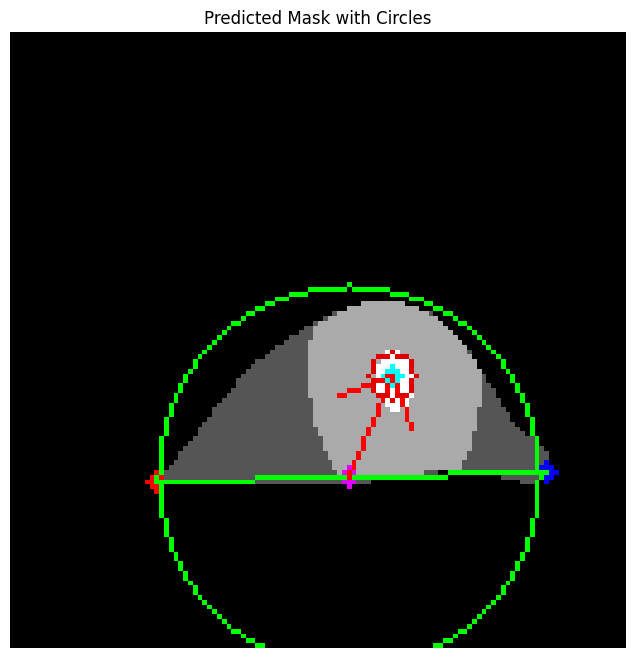

[  9 -21]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def calculate_gaze_vector_from_lable_img(label_path):
    label = np.load(label_path)
    label = cv2.resize(label, (128, 128))
    label = label / np.max(label)

    scalar_lower_bound = 0.2
    scalar_upper_bound = 0.5
    scalar_region_mask = np.logical_and(label >= scalar_lower_bound, label <= scalar_upper_bound).astype(np.uint8)

    iris_lower_bound = 0.75
    iris_upper_bound = 1
    iris_region_mask = np.logical_and(label >= iris_lower_bound, label <= iris_upper_bound).astype(np.uint8)

    # Find contours from the binary mask
    unfiltered_scalar_contours, _ = cv2.findContours(scalar_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    iris_contours, _ = cv2.findContours(iris_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(iris_contours) == 0:
        print("No iris contours found.")
        return None

    scalar_contours = [cnt for cnt in unfiltered_scalar_contours if cv2.contourArea(cnt) > 25]

    # Find the iris contour with the largest area
    largest_iris_contour = max(iris_contours, key=cv2.contourArea)

    M = cv2.moments(largest_iris_contour)

    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        # fallback if the area is too small
        center_x, center_y = 0, 0

    iris_center = (center_x, center_y)

    # Calculate iris radius as the mean distance from center to all contour points
    distances = [np.linalg.norm(np.array([center_x, center_y]) - point[0]) for point in largest_iris_contour]
    iris_radius = round(np.mean(distances)) if distances else 0
    print(f"Iris radius: {iris_radius}")

    # Initialize leftmost and rightmost points
    leftmost = (128, 128)
    rightmost = (0, 0)

    # Find extreme points from all contours
    for contour in scalar_contours:
        for point in contour:
            x, y = point[0]
            if x < leftmost[0]:
                leftmost = (x, y)
            if x > rightmost[0]:
                rightmost = (x, y)

    print(f"Leftmost Point: {leftmost}")
    print(f"Rightmost Point: {rightmost}")

    scelar_vector =  np.array(rightmost) - np.array(leftmost)
    middle_point = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    distance_left_middle = round(np.linalg.norm(np.array(leftmost) - np.array(middle_point)))
    print(f"Distance between Leftmost and Middle Point: {distance_left_middle}")
    # Convert predicted mask to RGB to draw colored circles
    predicted_mask_rgb = cv2.cvtColor((label * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Draw circles at leftmost and rightmost points
    cv2.circle(predicted_mask_rgb, leftmost, radius=2, color=(255, 0, 0), thickness=-1)  # Blue circle
    cv2.circle(predicted_mask_rgb, rightmost, radius=2, color=(0, 0, 255), thickness=-1) # Red circle
    cv2.circle(predicted_mask_rgb, iris_center, radius=2, color=(0, 255, 255), thickness=-1) # Red circle
    cv2.circle(predicted_mask_rgb, middle_point, radius=2, color=(225, 0, 255), thickness=-1)  # Magenta circle
    cv2.line(predicted_mask_rgb, leftmost, rightmost, color=(0, 255, 0), thickness=1)
    cv2.arrowedLine(predicted_mask_rgb, middle_point, iris_center, color=(255, 0, 0), thickness=1, tipLength=0.5)
    cv2.circle(predicted_mask_rgb, middle_point, radius=distance_left_middle, color=(0, 255, 0), thickness=1)  # Green circle
    cv2.circle(predicted_mask_rgb, iris_center, radius=iris_radius, color=(225, 0, 0), thickness=1) 

    plt.figure(figsize=(8, 8))
    plt.imshow(predicted_mask_rgb)
    plt.title('Predicted Mask with Circles')
    plt.axis('off')
    plt.show()

    iris_center_vector = np.array(iris_center)
    middle_point_vector = np.array(middle_point)
    return iris_center_vector - middle_point_vector


image_label_path =  '/home/yasas/GazeEstimation/openEDS/openEDS/test/labels'
print(calculate_gaze_vector_from_lable_img('/home/yasas/GazeEstimation/openEDS/openEDS/test/labels/005310.npy'))

# image_files = sorted(os.listdir(image_label_path))


# for image_file in image_files:
#     image_path = os.path.join(image_label_path, image_file)
#     print(image_path)
#     print(f"Processing {image_path}...")
#     calculate_gaze_vector_from_lable_img(image_path)